### Newsbot to write a daily AI news summary using langgraph
- Save a list of HTML files from sources.yaml (tech news sites)
- Extract URLs for the news stories
- Filter URLs to remove duplicates, articles seen before, and non-AI articles (using a ChatGPT prompt)
- Perform headline topic analysis and sort by topic to help the AI structure the response by topic
- Scrape and summarize individual articles
- Compose and email the summary
- Used to generate a daily newsletter at skynetandchill.com and potentially an autogenerated podcast


possible TODOs:

- try using google / model swap
- rate on various dimensions
- when doing summary, store the log length of the text for the summary
- store rating by source, bloomberg is high, normal pubs, prob garbage

spammy = has a relatively fact free headline with sensaitonal language.
only covers a stock movement or prediction without any basis in fact or sensational language
2 magnificent stocks
200 words is 0
divide chars by 1000 and take the log base 10
subtract 1 for spammy
add 1 for top source
delete less than 0 
only ai incidentally , ie ai predictions for nfl against the spread

"For each of the 100 summarized news stories, provide a rating on a scale of 1-10 for the following criteria:

Length (1 being too short or too long, 10 being optimal length)

Reputation of source (1 being unreliable, 10 being highly reputable)

Relevance/Importance (1 being trivial, 10 being highly significant)

Spamminess (1 being very spammy, 10 being not spammy at all)
- use exponential backoff to deal with rate limit issues (using metadata is not really well supported across llm providers, openai only gives time to reset in the http headers and not in the API itelf)
- do tests with promptfoo, promptlayer, do prompt optimization with eg dspy or your own thing
- scrape, extract, filter headlines, download pages, summarize, filter, categorize and sort, compose, rewrite


In [1]:
# to selectively re-import as needed
import sys
# del sys.modules['ainb_llm']
# del sys.modules['ainb_const']
# del sys.modules['ainb_utilities']
# del sys.modules['ainb_webscrape']
# del sys.modules['AInewsbot_langgraph']



In [2]:
import os
import shutil
# import dotenv
# import subprocess

from collections import Counter
import json
import uuid
import re
# import operator
import pickle
from datetime import datetime, timedelta

import langchain
from langchain_openai import ChatOpenAI
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_anthropic import ChatAnthropic

from langchain_core.messages import SystemMessage, HumanMessage
from langchain_core.prompts import (ChatPromptTemplate, PromptTemplate,
                                    SystemMessagePromptTemplate, HumanMessagePromptTemplate)
from langchain_core.output_parsers import StrOutputParser, PydanticOutputParser

from langgraph.checkpoint.memory import MemorySaver
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.checkpoint.sqlite.aio import AsyncSqliteSaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.errors import NodeInterrupt
from langchain.globals import set_debug

import numpy as np
import pandas as pd
import umap

import sklearn

import bs4

from tenacity import (
    retry,
    stop_after_attempt,
    wait_exponential,
    retry_if_exception_type
)

import asyncio
from asyncio import Semaphore

from IPython.display import HTML, Image, Markdown, display

# import pyperclip
# import shlex

import openai
from openai import OpenAI

from pydantic import BaseModel, Field
from typing import List, TypedDict, Annotated, Any

from google.cloud import aiplatform
from vertexai.language_models import TextGenerationModel
import google.generativeai as genai
import httpx

import trafilatura   # web scrape uses this to get clean news stories w/o a lot of js and boilerplate

from ainb_const import (
                        FINAL_SUMMARY_PROMPT,
                        REWRITE_PROMPT,
                        SCREENSHOT_DIR, SUMMARIZE_SYSTEM_PROMPT, SUMMARIZE_USER_PROMPT
                       )

from ainb_utilities import log

from AInewsbot_langgraph import (Agent, AgentState, newscatcher_sources, initialize_agent,
                                )


import podcastfy
from podcastfy.client import generate_podcast, process_content

from selenium.webdriver.support.ui import WebDriverWait
from IPython.display import Audio, display, Markdown

import pdb

# need this to run async in jupyter since it already has an asyncio event loop running
import asyncio
import nest_asyncio
nest_asyncio.apply()

# Activate global verbose logging
set_debug(False)


In [3]:
print(f"Python            {sys.version}")
print(f"LangChain         {langchain.__version__}")
print(f"OpenAI            {openai.__version__}")
# print(f"smtplib           {smtplib.sys.version}")
print(f"trafilatura       {trafilatura.__version__}")
# print(f"bs4               {bs4.__version__}")
print(f"numpy             {np.__version__}")
print(f"pandas            {pd.__version__}")
print(f"sklearn           {sklearn.__version__}")
print(f"umap              {umap.__version__}")
print(f"podcastfy         {podcastfy.__version__}")


Python            3.11.11 (main, Dec 11 2024, 10:25:04) [Clang 14.0.6 ]
LangChain         0.3.19
OpenAI            1.64.0
trafilatura       2.0.0
numpy             1.26.4
pandas            2.2.3
sklearn           1.6.1
umap              0.5.7
podcastfy         0.4.1


# Instantiate agent and run LangGraph workflow graph end to end

2025-03-03 06:51:50,851 - AInewsbot - INFO - Initializing with before_date=2025-03-02 15:00, do_download=False, thread_id=cafc52ce8e424fabb52b748dd2f5d3ae
2025-03-03 06:51:50,966 - AInewsbot - INFO - thread_id: cafc52ce8e424fabb52b748dd2f5d3ae


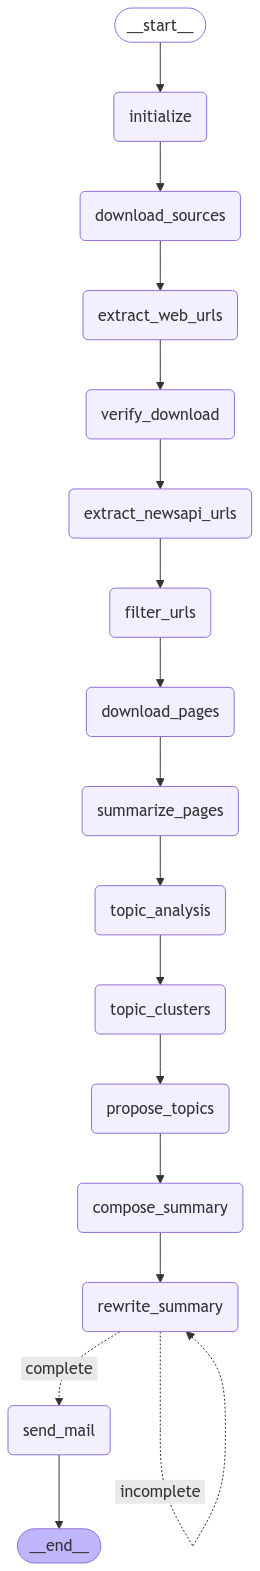

In [6]:
before_date = None
# before_date = '2025-03-02 15:00'
do_download = True

ml, mm, mh = 'gpt-4o-mini', 'gpt-4o-2024-11-20', 'o3-mini'
# ml, mm, mh = 'models/gemini-2.0-flash', 'models/gemini-1.5-pro-latest', 'models/gemini-2.0-flash-thinking-exp'
i
log(f"thread_id: {thread_id}")

display(Image(lg_agent.graph.get_graph().draw_mermaid_png()))

In [7]:
config = {"configurable": {"thread_id": thread_id}}
state = lg_agent.run(state, config)


2025-03-03 06:51:52,229 - AInewsbot - INFO - Initialized 16 items in sources from sources.yaml
2025-03-03 06:51:52,230 - AInewsbot - INFO - Ars Technica -> https://arstechnica.com/ -> Ars Technica.html
2025-03-03 06:51:52,230 - AInewsbot - INFO - Bloomberg Tech -> https://www.bloomberg.com/ai -> Bloomberg Technology.html
2025-03-03 06:51:52,231 - AInewsbot - INFO - Business Insider -> https://www.businessinsider.com/tech -> Business Insider Tech.html
2025-03-03 06:51:52,231 - AInewsbot - INFO - FT Tech -> https://www.ft.com/technology -> FT Technology.html
2025-03-03 06:51:52,231 - AInewsbot - INFO - Feedly AI -> https://feedly.com/i/aiFeeds?options=eyJsYXllcnMiOlt7InBhcnRzIjpbeyJpZCI6Im5scC9mL3RvcGljLzMwMDAifV0sInNlYXJjaEhpbnQiOiJ0ZWNobm9sb2d5IiwidHlwZSI6Im1hdGNoZXMiLCJzYWxpZW5jZSI6ImFib3V0In1dLCJidW5kbGVzIjpbeyJ0eXBlIjoic3RyZWFtIiwiaWQiOiJ1c2VyLzYyZWViYjlmLTcxNTEtNGY5YS1hOGM3LTlhNTdiODIwNTMwOC9jYXRlZ29yeS9HYWRnZXRzIn1dfQ -> Feedly AI.html
2025-03-03 06:51:52,231 - AInewsbot - INFO - 

run exception
'src'
run exception
'src'
run exception
'src'


2025-03-03 06:51:52,411 - AInewsbot - INFO - parse_file - found 257 raw links
2025-03-03 06:51:52,414 - AInewsbot - INFO - parse_file - found 23 filtered links
2025-03-03 06:51:52,414 - AInewsbot - INFO - 23 links found
2025-03-03 06:51:52,414 - AInewsbot - INFO - HackerNoon -> htmldata/HackerNoon (03_03_2025 06_30_42 AM).html
2025-03-03 06:51:52,456 - AInewsbot - INFO - parse_file - found 581 raw links
2025-03-03 06:51:52,462 - AInewsbot - INFO - parse_file - found 101 filtered links
2025-03-03 06:51:52,463 - AInewsbot - INFO - 101 links found
2025-03-03 06:51:52,463 - AInewsbot - INFO - NYT Tech -> htmldata/New York Times Technology (03_03_2025 06_30_50 AM).html
2025-03-03 06:51:52,473 - AInewsbot - INFO - parse_file - found 76 raw links
2025-03-03 06:51:52,474 - AInewsbot - INFO - parse_file - found 19 filtered links
2025-03-03 06:51:52,475 - AInewsbot - INFO - 19 links found
2025-03-03 06:51:52,475 - AInewsbot - INFO - Reddit -> htmldata/Reddit multiple subreddits (03_03_2025 06_31

,id
src,
Ars Technica,31
Bloomberg Tech,12
Business Insider,21
FT Tech,64
Feedly AI,32
Hacker News,28
Hacker News 2,23
HackerNoon,100
NYT Tech,19


2025-03-03 06:51:52,932 - AInewsbot - INFO - verify_download passed, found 16 sources in AIdf, 0 missing


,id
src,
Ars Technica,31
Bloomberg Tech,12
Business Insider,21
FT Tech,64
Feedly AI,32
Hacker News,28
Hacker News 2,23
HackerNoon,100
NYT Tech,19


2025-03-03 06:51:52,935 - AInewsbot - INFO - Fetching top 100 stories matching artificial intelligence since 2025-03-02T06:51:52 from NewsAPI


,id
src,
Ars Technica,31
Bloomberg Tech,12
Business Insider,21
FT Tech,64
Feedly AI,32
Hacker News,28
Hacker News 2,23
HackerNoon,100
NYT Tech,19


2025-03-03 06:51:53,287 - AInewsbot - INFO - Querying SQLite with where_clause: WHERE timestamp < '2025-03-02 15:00'
2025-03-03 06:51:53,839 - AInewsbot - INFO - URLs in orig_df: 868
2025-03-03 06:51:53,842 - AInewsbot - INFO - Existing URLs in DB: 225063
2025-03-03 06:51:53,897 - AInewsbot - INFO - New URLs in df filtered by URL: 278
2025-03-03 06:51:54,014 - AInewsbot - INFO - Existing src+title: 19
2025-03-03 06:51:54,014 - AInewsbot - INFO - New URLs in df filtered by src+title: 259
2025-03-03 06:51:54,027 - AInewsbot - INFO - Found 259 unique new headlines
2025-03-03 06:51:54,030 - AInewsbot - INFO - Found 253 unique cleaned new headlines
2025-03-03 06:51:56,252 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-03 06:52:02,179 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-03 06:52:08,370 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HT

,id
src,
Bloomberg Tech,1
Business Insider,2
FT Tech,3
Feedly AI,18
Hacker News,2
Hacker News 2,5
HackerNoon,6
NewsAPI,16
Techmeme,7


2025-03-03 06:52:16,536 - AInewsbot - INFO - Queuing URLs for scraping
2025-03-03 06:52:16,538 - AInewsbot - INFO - get_driver - Initializing webdriver, pid 60171
2025-03-03 06:52:16,538 - AInewsbot - INFO - get_driver - Initializing webdriver, pid 60171
2025-03-03 06:52:34,087 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2025-03-03 06:52:34,087 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2025-03-03 06:52:34,089 - AInewsbot - INFO - get_driver - Initialized webdriver service
2025-03-03 06:52:34,095 - AInewsbot - INFO - get_driver - Initialized webdriver service
2025-03-03 06:53:28,272 - AInewsbot - INFO - get_driver - Initialized webdriver
2025-03-03 06:53:28,313 - AInewsbot - INFO - get_driver - Resizing window
2025-03-03 06:53:29,331 - AInewsbot - INFO - get_driver - Initialized webdriver
2025-03-03 06:53:29,441 - AInewsbot - INFO - get_driver - Resizing window
2025-03-03 06:53:30,360 - AInewsbot - INFO - Processing page 0: https://venturebeat.c

2025-03-03 06:53:33,454 - AInewsbot - INFO - get_url(https://www.etfdailynews.com/2025/03/02/bullfrog-ai-holdings-inc-nasdaqbfrg-short-interest-update/) - starting get_url https://www.etfdailynews.com/2025/03/02/bullfrog-ai-holdings-inc-nasdaqbfrg-short-interest-update/
2025-03-03 06:53:33,454 - AInewsbot - INFO - Processing page 12: https://hackernoon.com/bun-just-got-60percent-faster-doom-now-runs-on-typescript-and-openai-launched-gpt-45-this-week-in-js
2025-03-03 06:53:33,456 - AInewsbot - INFO - get_url(https://hackernoon.com/bun-just-got-60percent-faster-doom-now-runs-on-typescript-and-openai-launched-gpt-45-this-week-in-js) - starting get_url https://hackernoon.com/bun-just-got-60percent-faster-doom-now-runs-on-typescript-and-openai-launched-gpt-45-this-week-in-js
2025-03-03 06:53:34,909 - AInewsbot - INFO - get_url(AWS Automates KYC and Fraud DetectionMakes Banks Failproof) - Saving AWS_Automates_KYC_and_Fraud_DetectionMakes_Banks_Failproof.html as UTF-8
2025-03-03 06:53:34,910 

2025-03-03 06:53:42,316 - AInewsbot - INFO - get_url(https://www.livemint.com/companies/people/googles-ai-push-co-founder-sergey-brin-urges-60-hour-work-week-in-memo-to-employees-calls-it-sweet-spot-of-productivity-11740906057925.html) - starting get_url https://www.livemint.com/companies/people/googles-ai-push-co-founder-sergey-brin-urges-60-hour-work-week-in-memo-to-employees-calls-it-sweet-spot-of-productivity-11740906057925.html
2025-03-03 06:53:43,904 - AInewsbot - INFO - get_url(Google's AI push: Co-founder Brin urges 60-hour work week in memo to employees, calls it sweet spot of productivity) - Saving Google_s_AI_push__Co-founder_Brin_urges_60-hour_work_week_in_memo_to_employees__calls_it_sweet_spot_of_productivity.html as utf-8
2025-03-03 06:53:43,904 - AInewsbot - INFO - Processing page 24: https://techcrunch.com/2025/03/03/googles-gemini-now-lets-you-ask-questions-using-videos-or-whats-on-your-screen/
2025-03-03 06:53:43,905 - AInewsbot - INFO - get_url(https://techcrunch.com

2025-03-03 06:53:58,263 - AInewsbot - INFO - get_url(India's top telco plans cloud PCs for its 475 million subscribersAsia In BriefPLUS: China bans AI leaders from visiting USA; Acer data leak suspect cuffed; and more) - Saving India_s_top_telco_plans_cloud_PCs_for_its_475_million_subscribersAsia_In_BriefPLUS__China_bans_AI_leaders_from_visiting_USA__Acer_data_leak_suspect_cuffed__and_more.html as utf-8
2025-03-03 06:53:58,264 - AInewsbot - INFO - Processing page 36: https://www.engadget.com/computing/laptops/lenovos-new-ai-laptops-for-mwc-include-the-yoga-pro-9i-aura-edition-and-the-ideapad-slim-3x-230024761.html
2025-03-03 06:53:58,265 - AInewsbot - INFO - get_url(https://www.engadget.com/computing/laptops/lenovos-new-ai-laptops-for-mwc-include-the-yoga-pro-9i-aura-edition-and-the-ideapad-slim-3x-230024761.html) - starting get_url https://www.engadget.com/computing/laptops/lenovos-new-ai-laptops-for-mwc-include-the-yoga-pro-9i-aura-edition-and-the-ideapad-slim-3x-230024761.html
2025-

2025-03-03 06:54:07,279 - AInewsbot - INFO - get_url(Show HN: Recommendarr  AI Driven Recommendations Based on Sonarr/Radarr Media) - Saving Show_HN__Recommendarr__AI_Driven_Recommendations_Based_on_Sonarr_Radarr_Media.html as utf-8
2025-03-03 06:54:07,280 - AInewsbot - INFO - Processing page 50: https://www.theguardian.com/technology/2025/mar/01/parents-children-artificial-intelligence
2025-03-03 06:54:07,280 - AInewsbot - INFO - get_url(https://www.theguardian.com/technology/2025/mar/01/parents-children-artificial-intelligence) - starting get_url https://www.theguardian.com/technology/2025/mar/01/parents-children-artificial-intelligence
2025-03-03 06:54:07,580 - AInewsbot - INFO - get_url(Singapore probes suspected fraud in sales of US-controlled Nvidia chips) - Saving Singapore_probes_suspected_fraud_in_sales_of_US-controlled_Nvidia_chips.html as utf-8
2025-03-03 06:54:07,584 - AInewsbot - INFO - Processing page 51: https://www.androidheadlines.com/2025/03/tecno-introduces-a-pair-of

2025-03-03 06:54:14,673 - AInewsbot - INFO - Quit webdriver
2025-03-03 06:54:15,560 - AInewsbot - INFO - get_url(Your Chatbot Might Be Leaking SecretsHeres How to Lock It Down) - Saving Your_Chatbot_Might_Be_Leaking_SecretsHeres_How_to_Lock_It_Down.html as utf-8
2025-03-03 06:54:15,569 - AInewsbot - INFO - Quit webdriver
2025-03-03 06:54:16,597 - AInewsbot - INFO - get_url(The US' plan to cut federal contracts imperils Booz Allen Hamilton, which gets most of its revenue from providing IT and AI services across the government) - Saving The_US__plan_to_cut_federal_contracts_imperils_Booz_Allen_Hamilton__which_gets_most_of_its_revenue_from_providing_IT_and_AI_services_across_the_government.html as utf-8
2025-03-03 06:54:16,604 - AInewsbot - INFO - Quit webdriver
2025-03-03 06:54:21,266 - AInewsbot - INFO - 19 pages saved
2025-03-03 06:54:22,196 - AInewsbot - INFO - 19 pages saved
2025-03-03 06:54:22,595 - AInewsbot - INFO - 17 pages saved
2025-03-03 06:55:43,909 - AInewsbot - INFO - Error

,id
src,
Bloomberg Tech,1
Business Insider,2
FT Tech,3
Feedly AI,17
Hacker News,2
Hacker News 2,5
HackerNoon,6
NewsAPI,16
Techmeme,7


2025-03-03 06:56:44,008 - AInewsbot - INFO - Starting summarize
2025-03-03 06:56:44,010 - AInewsbot - INFO - Fetching summaries for all articles
2025-03-03 06:56:44,037 - AInewsbot - INFO - clean_html - Page title: 2025 has already brought us the most performant AI ever: What can we do with these supercharged capabilities (and what's next)? | VentureBeat
Social card title: 2025 has already brought us the most performant AI ever: What can we do with these supercharged capabilities (and what’s next)?
Social card description: From OpenAI's 'Deep Research' to DeepMind's 'AI co-scientist,' next-gen AI is smarter and astoundingly capable.

2025-03-03 06:56:44,270 - AInewsbot - INFO - Queuing 0: Page title: 2025 has already brought us the most p...
2025-03-03 06:56:44,292 - AInewsbot - INFO - clean_html - Page title: These Smart Cameras Spot Wildfires Before They Spread - WSJ
Social card title: These Smart Cameras Spot Wildfires Before They Spread
Social card description: The newest fire spot

2025-03-03 06:56:44,739 - AInewsbot - INFO - Queuing 15: Page title: Canaccord Genuity Group Cuts C3.ai (NY...
2025-03-03 06:56:44,743 - AInewsbot - INFO - clean_html - Page title: Cathie Wood Says Software Is the Next Big AI Opportunity -- 1 Super Stock You'll Want to Buy If She's Right
Social card title: Cathie Wood Says Software Is the Next Big AI Opportunity -- 1 Super Stock You'll Want to Buy If She's Right
Social card description: Cathie Wood is the founder of Ark Investment Management, which operates several exchange-traded funds (ETFs) focused on innovative technologies like electric…

2025-03-03 06:56:44,745 - AInewsbot - INFO - Queuing 16: Page title: Cathie Wood Says Software Is the Next ...
2025-03-03 06:56:44,784 - AInewsbot - INFO - clean_html - Page title: Chinese Buyers Are Ordering Nvidia’s Newest AI Chips, Defying U.S. Curbs - WSJ
Social card title: Chinese Buyers Are Ordering Nvidia’s Newest AI Chips, Defying U.S. Curbs
Social card description: Traders offered server

2025-03-03 06:56:45,990 - AInewsbot - INFO - clean_html - Page title: How to Use AI and Google My Maps for Seamless Travel Planning - Geeky Gadgets
Social card title: Improve Your Travel Planning with AI & Google My Maps
Social card description: Plan your perfect trip with AI tools and Google My Maps. Create custom itineraries, organize layers, and maximize your travel experience.

2025-03-03 06:56:46,001 - AInewsbot - INFO - Queuing 32: Page title: How to Use AI and Google My Maps for S...
2025-03-03 06:56:46,013 - AInewsbot - INFO - clean_html - Page title: 450 million Indians to be targeted with cloudy PCs • The Register
Social card title: 450 million Indians to be targeted with cloudy PCs
Social card description: PLUS: China bans AI leaders from visiting USA; Acer data leak suspect cuffed; and more

2025-03-03 06:56:46,032 - AInewsbot - INFO - Queuing 33: Page title: 450 million Indians to be targeted wit...
2025-03-03 06:56:46,044 - AInewsbot - INFO - clean_html - Page title: Inte

2025-03-03 06:56:46,460 - AInewsbot - INFO - clean_html - Page title: Subscribe to read
Social card title: Singapore probes suspected fraud in sales of US-controlled Nvidia chips
Social card description: Arrests made in city-state after raids on 22 locations

2025-03-03 06:56:46,477 - AInewsbot - INFO - Queuing 48: Page title: Subscribe to read
Social card title: S...
2025-03-03 06:56:46,493 - AInewsbot - INFO - clean_html - Page title: Subscribe to read
Social card title: Singapore probes suspected fraud in sales of US-controlled Nvidia chips
Social card description: Arrests made in city-state after raids on 22 locations

2025-03-03 06:56:46,513 - AInewsbot - INFO - Queuing 49: Page title: Subscribe to read
Social card title: S...
2025-03-03 06:56:46,529 - AInewsbot - INFO - clean_html - Page title: ‘I want him to be prepared’: why parents are teaching their gen Alpha kids to use AI | Technology | The Guardian
Social card title: ‘I want him to be prepared’: why parents are teaching th

2025-03-03 06:56:48,512 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-03 06:56:48,672 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-03 06:56:48,867 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-03 06:56:49,056 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-03 06:56:49,117 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-03 06:56:49,124 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-03 06:56:49,184 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-03 06:56:49,296 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-03 06:56:49,309 - httpx 

2025-03-03 06:56:53,742 - AInewsbot - INFO - Summary for 3: • The HumanX AI conference in Las Vegas, co-founded by Jonathan Weiner and Stefan Weitz, is set to host 330 speakers and over 3,000 attendees, featuring tech leaders, investors, and politicians like Kamala Harris, from March 9-13, to discuss AI development, creativity, and regulation.  

• The conference, backed by $6.2 million in funding and supported by firms like Primary Ventures and Foundation Capital, aims to propel growth and momentum across the AI ecosystem amidst increasing funding and acquisition activity in the sector.  

• In 2024, AI startups received over $100 billion in global funding, and HumanX will focus on advancing industry discussions around regulation, ecosystem growth, and innovation.
2025-03-03 06:56:53,743 - AInewsbot - INFO - Summary for 4: • Universities are increasingly offering AI courses, attracting interest from non-STEM students like nurses and teachers.
2025-03-03 06:56:53,743 - AInewsbot - INFO

2025-03-03 06:56:53,748 - AInewsbot - INFO - Summary for 20: - Geoffrey Hinton, known as the "godfather of AI," has called for Elon Musk's expulsion from the Royal Society, citing Musk's harm to scientific institutions in the U.S., following Musk's controversial behavior including conspiracy theories and alleged fascist salutes.  
- Elon Musk responded on his platform, X, labeling Hinton's comments as "carelessly ignorant, cruel, and false," and expressed disdain for awards and memberships while defending his actions.  
- The Royal Society is set to debate Musk's Fellowship after an open letter signed by thousands of academics accused him of breaching the institution's code of conduct, with two members resigning in protest.  
2025-03-03 06:56:53,748 - AInewsbot - INFO - Summary for 21: • Generation X leaders are encouraged to adapt in the AI era by fostering a culture of agility, adopting AI as a supportive tool, and embracing reverse mentoring to learn from younger generations.  

• L

2025-03-03 06:56:53,752 - AInewsbot - INFO - Summary for 35: • Police Station Pattan in Baramulla district, Jammu and Kashmir, registered its first e-FIR via WhatsApp on February 28, marking a move toward digital policing.  

• A government employee from the Horticulture Department lodged the complaint, accusing a colleague of sexual harassment, attempted rape, and criminal intimidation.  

• The case was registered as FIR No. 30/2025, and an investigation is currently underway.  
2025-03-03 06:56:53,752 - AInewsbot - INFO - Summary for 36: - Lenovo has announced new AI laptops for MWC 2025, including the Yoga Pro 9i Aura edition with Intel Core Ultra processor, NVIDIA GeForce RTX 5070 GPU, a 16-inch 3.2K PureSight Pro display, and Lenovo Creator Zone AI suite, available in Q2 2025 starting at $1,799.  
- The 15-inch IdeaPad Slim 3x, a Copilot+ PC powered by Qualcomm's Snapdragon X chip, features a dedicated Microsoft Copilot key and an open SSD slot for additional storage, available s

2025-03-03 06:56:53,756 - AInewsbot - INFO - Summary for 52: • Text-to-SQL, initially seen as a promising AI application for self-service analytics, has faced challenges in meeting enterprise expectations due to the limitations of monolithic AI frameworks like fine-tuning and Retrieval Augment Generation (RAG).

• Emerging solutions, such as "agentic frameworks" and "agent mesh" systems, aim to improve AI adaptability for data analysis by using specialized AI agents for domain-specific tasks and facilitating inter-agent communication for scalability and governance.

• The development of AI analyst agents requires complex architecture, including individual Python kernels and synchronization with data sources, addressing both AI and DevOps challenges to ensure security, reliability, and cost efficiency for enterprise adoption.
2025-03-03 06:56:53,756 - AInewsbot - INFO - Summary for 53: • Pressmaster.ai excels in creating authentic, voice-preserving content and scaling thought leadership

,id
src,
Bloomberg Tech,1
Business Insider,2
FT Tech,3
Feedly AI,17
Hacker News,2
Hacker News 2,5
HackerNoon,6
NewsAPI,16
Techmeme,7


2025-03-03 06:56:53,767 - AInewsbot - INFO - start free-form topic extraction using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-03-03 06:56:55,591 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-03 06:57:00,109 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-03 06:57:00,212 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-03 06:57:03,764 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-03 06:57:03,777 - AInewsbot - INFO - 62 free-form topics extracted
2025-03-03 06:57:03,778 - AInewsbot - INFO - Starting assigned topic extraction using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-03-03 06:57:03,779 - AInewsbot - INFO - Canonical topic stocks
2025-03-03 06:57:03,779 - AInewsbot - INFO - Canonical topic education
2025-03-03 06:57:03,78

2025-03-03 06:57:03,806 - AInewsbot - INFO - Canonical topic gen ai
2025-03-03 06:57:03,807 - AInewsbot - INFO - Canonical topic brain-computer interfaces
2025-03-03 06:57:03,807 - AInewsbot - INFO - Canonical topic disinformation
2025-03-03 06:57:03,807 - AInewsbot - INFO - Canonical topic military
2025-03-03 06:57:03,808 - AInewsbot - INFO - Canonical topic korea
2025-03-03 06:57:03,808 - AInewsbot - INFO - Canonical topic healthcare
2025-03-03 06:57:03,808 - AInewsbot - INFO - Canonical topic nuclear
2025-03-03 06:57:03,808 - AInewsbot - INFO - Canonical topic gaming
2025-03-03 06:57:03,808 - AInewsbot - INFO - Canonical topic bubble
2025-03-03 06:57:03,808 - AInewsbot - INFO - Canonical topic stock market analysis
2025-03-03 06:57:03,809 - AInewsbot - INFO - Canonical topic mark walter
2025-03-03 06:57:03,809 - AInewsbot - INFO - Canonical topic authors & writing
2025-03-03 06:57:03,809 - AInewsbot - INFO - Sending prompt for 112 canonical topics
2025-03-03 06:57:06,084 - httpx - I

2025-03-03 06:57:06,788 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-03 06:57:06,801 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-03 06:57:06,803 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-03 06:57:06,817 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-03 06:57:06,826 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-03 06:57:06,829 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-03 06:57:06,835 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-03 06:57:06,839 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-03 06:57:06,856 - httpx 

2025-03-03 06:57:08,253 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-03 06:57:08,276 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-03 06:57:08,282 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-03 06:57:08,334 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-03 06:57:08,347 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-03 06:57:08,356 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-03 06:57:08,375 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-03 06:57:08,377 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-03 06:57:08,382 - httpx 

2025-03-03 06:57:09,025 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-03 06:57:09,027 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-03 06:57:09,028 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-03 06:57:09,048 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-03 06:57:09,049 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-03 06:57:09,057 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-03 06:57:09,080 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-03 06:57:09,083 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-03 06:57:09,099 - httpx 

2025-03-03 06:57:09,770 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-03 06:57:09,798 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-03 06:57:09,897 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-03 06:57:09,916 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-03 06:57:09,943 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-03 06:57:09,945 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-03 06:57:09,979 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-03 06:57:09,997 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-03 06:57:09,999 - httpx 

2025-03-03 06:57:11,195 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-03 06:57:11,206 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-03 06:57:11,226 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-03 06:57:11,242 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-03 06:57:11,256 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-03 06:57:11,277 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-03 06:57:11,290 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-03 06:57:11,296 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-03 06:57:11,333 - httpx 

2025-03-03 06:57:13,680 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-03 06:57:13,790 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-03 06:57:13,820 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-03 06:57:13,853 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-03 06:57:13,887 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-03 06:57:14,077 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-03 06:57:14,102 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-03 06:57:14,262 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-03 06:57:14,546 - httpx 

,id
src,
Bloomberg Tech,1
Business Insider,2
FT Tech,3
Feedly AI,17
Hacker News,2
Hacker News 2,5
HackerNoon,6
NewsAPI,16
Techmeme,7


2025-03-03 06:57:50,721 - AInewsbot - INFO - Fetching embeddings for 62 headlines
2025-03-03 06:57:51,328 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-03-03 06:57:51,485 - AInewsbot - INFO - Sort with nearest_neighbor_sort
2025-03-03 06:57:51,503 - AInewsbot - INFO - Load umap dimensionality reduction model
2025-03-03 06:57:53,084 - AInewsbot - INFO - Perform dimensionality reduction
/opt/anaconda3/envs/ainewsbot/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
2025-03-03 06:57:54,323 - AInewsbot - INFO - Cluster with DBSCAN
2025-03-03 06:57:54,407 - AInewsbot - INFO - Found 3 clusters


,title_topic_str
0,"DA Davidson Cuts C3.ai (NYSE:AI) Price Target to $25.00 (Topics: AI Investments, Analyst Consensus Ratings, C3.AI, C3.AI Price Target Evaluations, Deals, Economics, Finance, Gen AI, Products, Quarterly Earnings Report, Review, Stock Market Analysis, Stocks)"
1,"Canaccord Genuity Group Cuts C3.ai (NYSE:AI) Price Target to $30.00 (Topics: AI Investments, Analyst Evaluations, C3.AI, C3.AI Price Target, Deals, Economics, Finance, Gen AI, Products, Review, Stock Market Analysis, Stock Performance, Stocks)"
2,"C3.ais (AI) Hold Rating Reiterated at Needham & Company LLC (Topics: AI Investments, C3.AI, Deals, Earnings Estimates, Economics, Finance, Gen AI, Products, Quarterly Revenue Results, Review, Stock Market Analysis, Stocks)"
3,"Morgan Stanley Cuts C3.ai (NYSE:AI) Price Target to $30.00 (Topics: C3.AI, Computer Vision, Economics, Finance, Gen AI, Language Models, Morgan Stanley, Price Target Adjustment, Products, Review, Singularity, Stock Market Analysis, Stocks)"
4,"Bullfrog AI Holdings, Inc. (NASDAQ:BFRG) Short Interest Update (Topics: AI Investments, Bullfrog AI Holdings, Deals, Economics, Finance, Products, Short Interest Update, Stock Market Analysis, Stocks)"
5,"C3.ai, Inc. (NYSE:AI) Shares Purchased by Global Retirement Partners LLC (Topics: AI Investments, Analyst Ratings, C3.AI, Deals, Economics, Finance, Gen AI, Insider Trading, Products, Stock Holdings, Stock Market Analysis, Stocks)"


2025-03-03 06:57:54,908 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-03 06:57:54,935 - AInewsbot - INFO - I dub this cluster: C3.ai Stock Market Analysis


,title_topic_str
6,"Alibaba Launches C930 RISC-V Chip Amid Shift from Western Tech (Topics: AI Investments, Alibaba, Autonomous Vehicles, C930 Risc-V Chip, China, Funding, Gen AI, Governance, Hardware, Infrastructure, Intellectual Property, Manufacturing, Open Source, Policy And Regulation, Products, Science, Semiconductor Chips, Semiconductor Self-Sufficiency, U.S. Export Controls)"
7,"Chinese traders are selling Nvidia-equipped servers, including Blackwell, via third parties in countries like Vietnam and Taiwan; some promise six-week delivery (Topics: AI Investments, China, Chinese Trade Tactics, Gen AI, Governance, Hardware, Intellectual Property, Legal Issues, Manufacturing, Nvidia, Nvidia Chips, Policy And Regulation, Products, Science, Semiconductor Chips, Taiwan, Us Export Controls)"
8,"Singapore charges three men in a case suspected to involve Nvidia chip sales that breach US export controls, after a tip-off the chips were exported to Malaysia (Topics: AI Investments, Deals, Economics, Energy, Export Controls, Finance, Fraud Charges, Governance, Hardware, Intellectual Property, Legal Issues, Manufacturing, Military, Nvidia, Policy And Regulation, Politics, Products, Scams, Science, Semiconductor Chips, Singapore Investigation, Stock Market Analysis, Stocks, Transportation)"


2025-03-03 06:57:55,415 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-03 06:57:55,426 - AInewsbot - INFO - I dub this cluster: Semiconductor Industry and Geopolitics


,title_topic_str
9,"Google's AI push: Co-founder Brin urges 60-hour work week in memo to employees, calls it sweet spot of productivity (Topics: Artificial General Intelligence, Code Assistants, Gen AI, Google, Internal Memo, Job Automation, Jobs & Careers, Labor Market, Language Models, OpenAI, Science, Sergey Brin, Singularity, Testing, Workweek Productivity)"
10,"Sergey Brin says 60-hour in-office weeks are key to Google's AI push (Topics: AI Doom, AI Investments, AI Work Ethic, Artificial General Intelligence, Cognitive Science, Consciousness, Gen AI, Google, India, Jobs & Careers, Labor Market, Language Models, Opinion, Policy And Regulation, Safety And Alignment, Science, Sergey Brin, Singularity, Work-From-Home Policy)"
11,"Google co-founder Sergey Brin reckons the next big leap in AI is possible - but only if we all ditch working from home (Topics: Artificial General Intelligence, Gen AI, Google, Job Automation, Jobs & Careers, Labor Market, Language Models, Return To Office, Science, Sergey Brin, Singularity, Workplace Productivity)"


2025-03-03 06:57:55,856 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-03 06:57:55,862 - AInewsbot - INFO - I dub this cluster: Google's AI Work Commitment
2025-03-03 06:57:55,969 - AInewsbot - INFO - Sending bullet points email
2025-03-03 06:57:57,710 - AInewsbot - INFO - ['C3.ai Stock Market Analysis', 'Semiconductor Industry and Geopolitics', "Google's AI Work Commitment"]


bullets created


[DA Davidson Cuts C3.ai (NYSE:AI) Price Target to \\$25.00 - www.etfdailynews.com](https://www.etfdailynews.com/2025/03/02/da-davidson-cuts-c3-ai-nyseai-price-target-to-25-00/)

Topics: AI Investments, Analyst Consensus Ratings, C3.AI, C3.AI Price Target Evaluations, Deals, Economics, Finance, Gen AI, Products, Quarterly Earnings Report, Review, Stock Market Analysis, Stocks

- DA Davidson lowered C3.ai's (NYSE:AI) price target from \\$40.00 to \\$25.00 and maintained a neutral rating.  
- Other analysts also revised their evaluations, with Morgan Stanley reducing its target to \\$30.00, and Piper Sandler cutting its target to \\$28.00. The stock holds an average rating of “Hold” with analysts split between sell, hold, and buy ratings.  
- C3.ai reported a quarterly earnings loss of \\$0.62 per share, missing the consensus estimate, with a net margin of -79.17% and revenue of \\$98.78 million.  



[Canaccord Genuity Group Cuts C3.ai (NYSE:AI) Price Target to \\$30.00 - www.etfdailynews.com](https://www.etfdailynews.com/2025/03/02/canaccord-genuity-group-cuts-c3-ai-nyseai-price-target-to-30-00/)

Topics: AI Investments, Analyst Evaluations, C3.AI, C3.AI Price Target, Deals, Economics, Finance, Gen AI, Products, Review, Stock Market Analysis, Stock Performance, Stocks

- Canaccord Genuity Group reduced its target price for C3.ai stock from \\$40.00 to \\$30.00 and maintained a "hold" rating.  
- Analysts' opinions on C3.ai stock vary, with ratings including five "sell," five "hold," four "buy," and one "strong buy," leading to a consensus price target of \\$31.33.  
- C3.ai reported a quarterly revenue of \\$98.78 million, missing analysts' earnings expectations, and insiders recently sold significant amounts of company stock.  



[C3.ais (AI) Hold Rating Reiterated at Needham & Company LLC - www.etfdailynews.com](https://www.etfdailynews.com/2025/03/02/c3-ais-ai-hold-rating-reiterated-at-needham-company-llc/)

Topics: AI Investments, C3.AI, Deals, Earnings Estimates, Economics, Finance, Gen AI, Products, Quarterly Revenue Results, Review, Stock Market Analysis, Stocks

• Needham & Company LLC reiterated their "Hold" rating on shares of C3.ai, while other firms like DA Davidson upgraded it to "Hold," and KeyCorp downgraded it to "Underweight" with a \\$29 price target.  

• C3.ai reported a quarterly revenue of \\$98.78 million but missed earnings estimates, posting (\\$0.62) EPS compared to the expected (\\$0.25).  

• Insider trades included significant stock sales by CFO Hitesh Lath and Director Jim H. Snabe, reducing their positions in the company drastically.  



[Morgan Stanley Cuts C3.ai (NYSE:AI) Price Target to \\$30.00 - www.etfdailynews.com](https://www.etfdailynews.com/2025/03/02/morgan-stanley-cuts-c3-ai-nyseai-price-target-to-30-00/)

Topics: C3.AI, Computer Vision, Economics, Finance, Gen AI, Language Models, Morgan Stanley, Price Target Adjustment, Products, Review, Singularity, Stock Market Analysis, Stocks

• Morgan Stanley lowered its price target for C3.ai (NYSE:AI) from \\$32.00 to \\$30.00 and maintained its "underweight" rating on the stock.  
• Analysts are divided on C3.ai, with ratings including five "sell," five "hold," four "buy," one "strong buy," and a consensus target price of \\$31.33.  
• CEO Thomas M. Siebel and Director Jim H. Snabe sold significant shares of the company, reducing their holdings by 18.92% and 98.04%, respectively, in recent months.  



[Bullfrog AI Holdings, Inc. (NASDAQ:BFRG) Short Interest Update - www.etfdailynews.com](https://www.etfdailynews.com/2025/03/02/bullfrog-ai-holdings-inc-nasdaqbfrg-short-interest-update/)

Topics: AI Investments, Bullfrog AI Holdings, Deals, Economics, Finance, Products, Short Interest Update, Stock Market Analysis, Stocks

- Bullfrog AI Holdings, Inc. (NASDAQ:BFRG) experienced a 60.2% increase in short interest, reaching 756,800 shares as of February 15, compared to 472,300 shares on January 31, with a short-interest ratio of 0.9 days.  
- The stock has a one-year low of \\$1.43 and a high of \\$4.84, with a market capitalization of \\$18.21 million and a PE ratio of -2.46.   
- Institutional investors, including Raymond James Financial Inc. and Geode Capital Management LLC, have recently taken or expanded positions in Bullfrog AI, with hedge funds owning 0.96% of the company’s stock.  



[C3.ai, Inc. (NYSE:AI) Shares Purchased by Global Retirement Partners LLC - www.etfdailynews.com](https://www.etfdailynews.com/2025/03/02/c3-ai-inc-nyseai-shares-purchased-by-global-retirement-partners-llc/)

Topics: AI Investments, Analyst Ratings, C3.AI, Deals, Economics, Finance, Gen AI, Insider Trading, Products, Stock Holdings, Stock Market Analysis, Stocks

- Global Retirement Partners LLC increased its holdings in C3.ai, Inc. by 1,004% in Q4, acquiring 1,014 additional shares for a total of 1,115 shares valued at \\$38,000 by the end of the period.  
- Insider trading activity included the sale of 125,000 shares by Director Stephen M. Ward, Jr. and 552,422 shares by CEO Thomas M. Siebel, reducing their respective ownership stakes by 18.62% and 29.24%.  
- Analysts gave mixed ratings for C3.ai, with a consensus "Hold" rating and a target price of \\$31.33, reflecting divided opinions on the stock’s performance.  



[Alibaba Launches C930 RISC-V Chip Amid Shift from Western Tech - HPCwire](https://www.hpcwire.com/2025/02/28/alibaba-launches-c930-risc-v-chip-amid-shift-from-western-tech/)

Topics: AI Investments, Alibaba, Autonomous Vehicles, C930 Risc-V Chip, China, Funding, Gen AI, Governance, Hardware, Infrastructure, Intellectual Property, Manufacturing, Open Source, Policy And Regulation, Products, Science, Semiconductor Chips, Semiconductor Self-Sufficiency, U.S. Export Controls

- Alibaba's Damo Academy launched the C930, its first server-grade RISC-V CPU, designed for high-performance computing, as part of efforts to boost China's semiconductor self-sufficiency amid U.S. export controls on advanced chips.  
- Additional chip developments under the XuanTie RISC-V series were announced, including AI acceleration and automotive applications, alongside broader investments in AI and cloud infrastructure totaling 380 billion yuan (~US\\$52 billion) over three years.  
- The push for RISC-V aligns with China's strategy to reduce reliance on Western technology, with other Chinese entities like the Chinese Academy of Sciences also advancing RISC-V initiatives.  



[Chinese traders are selling Nvidia-equipped servers, including Blackwell, via third parties in countries like Vietnam and Taiwan; some promise six-week delivery - The Wall Street Journal](https://www.wsj.com/tech/china-nvidia-blackwell-chips-ai-531fed0c)

Topics: AI Investments, China, Chinese Trade Tactics, Gen AI, Governance, Hardware, Intellectual Property, Legal Issues, Manufacturing, Nvidia, Nvidia Chips, Policy And Regulation, Products, Science, Semiconductor Chips, Taiwan, Us Export Controls

- Chinese buyers are circumventing U.S. export controls by ordering Nvidia's newest Blackwell AI chips through third parties in nearby regions.  
- Traders in China are offering computing systems with Nvidia's chips, with some promising deliveries within six weeks.  
- The efforts highlight challenges for U.S. authorities in restricting access to advanced American technology.  



[Singapore charges three men in a case suspected to involve Nvidia chip sales that breach US export controls, after a tip-off the chips were exported to Malaysia - Twitter](https://t.co/uVFFrtgV4f)

Topics: AI Investments, Deals, Economics, Energy, Export Controls, Finance, Fraud Charges, Governance, Hardware, Intellectual Property, Legal Issues, Manufacturing, Military, Nvidia, Policy And Regulation, Politics, Products, Scams, Science, Semiconductor Chips, Singapore Investigation, Stock Market Analysis, Stocks, Transportation

- Singapore is investigating suspected fraud in the sales of US-controlled Nvidia chips.  
- Arrests have been made following raids on 22 locations in the city-state.



[Google's AI push: Co-founder Brin urges 60-hour work week in memo to employees, calls it sweet spot of productivity - Live Mint](https://www.livemint.com/companies/people/googles-ai-push-co-founder-sergey-brin-urges-60-hour-work-week-in-memo-to-employees-calls-it-sweet-spot-of-productivity-11740906057925.html)

Topics: Artificial General Intelligence, Code Assistants, Gen AI, Google, Internal Memo, Job Automation, Jobs & Careers, Labor Market, Language Models, OpenAI, Science, Sergey Brin, Singularity, Testing, Workweek Productivity

- Google co-founder Sergey Brin, in an internal memo, urged employees to adopt a 60-hour workweek, calling it the "sweet spot of productivity," and suggested they work from the office on weekdays to accelerate efforts in artificial intelligence development.  
- Brin emphasized the urgency to compete with companies like OpenAI and Microsoft in the race toward artificial general intelligence, stating that Google has the necessary resources but needs to "turbocharge" its efforts.  
- He encouraged engineers to use Google's AI models for coding to enhance efficiency, aiming to position the company as a leader in the AI space.  



[Sergey Brin says 60-hour in-office weeks are key to Google's AI push - TechSpot](https://www.techspot.com/news/106988-sergey-brin-60-hour-office-weeks-key-google.html)

Topics: AI Doom, AI Investments, AI Work Ethic, Artificial General Intelligence, Cognitive Science, Consciousness, Gen AI, Google, India, Jobs & Careers, Labor Market, Language Models, Opinion, Policy And Regulation, Safety And Alignment, Science, Sergey Brin, Singularity, Work-From-Home Policy

- Sergey Brin, Google co-founder, urged employees working on AI products to commit to 60-hour in-office workweeks, stating it is essential for winning the competitive race to develop artificial general intelligence (AGI).  
- Brin's memo suggests that workers being less productive than this standard can demoralize others, and he emphasized using Google's AI tools like Gemini to increase efficiency while cautioning against exceeding 60 hours to avoid exhaustion.  
- Brin's push contrasts with Google's current work-from-home policy, advocating for in-office work every weekday, though it is unlikely CEO Sundar Pichai will change existing policies or impose stricter hour requirements.  



[Google co-founder Sergey Brin reckons the next big leap in AI is possible - but only if we all ditch working from home - TechRadar](https://www.techradar.com/pro/google-co-founder-sergey-brin-reckons-the-next-big-leap-in-ai-is-possible-but-only-if-we-all-ditch-working-from-home)

Topics: Artificial General Intelligence, Gen AI, Google, Job Automation, Jobs & Careers, Labor Market, Language Models, Return To Office, Science, Sergey Brin, Singularity, Workplace Productivity

• Google co-founder Sergey Brin has urged workers to return to the office and consider longer 60-hour work weeks, believing it is key to achieving advancements in artificial general intelligence (AGI).  

• Brin highlighted the use of AI tools like Gemini to boost efficiency and productivity, suggesting outputs could exceed physical working hours.  

• Despite Brin’s encouragement, Google continues to maintain a hybrid work model with no confirmation of plans for mandatory extended work hours.  



[AWS Automates KYC and Fraud DetectionMakes Banks Failproof - Analytics India Magazine](https://analyticsindiamag.com/global-tech/aws-automates-kyc-and-fraud-detection-makes-banks-failproof/)

Topics: AI Investments, Aws, China, Customer Service, Cybersecurity, Deals, Economics, Finance, Financial Services In India, Fintech, Fraud Detection, Funding, Gen AI, Governance, India, Infrastructure, Job Automation, Jobs & Careers, Kyc Automation, Labor Market, Language Models, Legal Issues, Policy And Regulation, Privacy, Privacy & Surveillance, Products, Retrieval Augmented Generation, Safety And Alignment, Stock Market Analysis, Stocks

- AWS is enabling Indian banks and financial institutions to adopt generative AI for tasks like KYC automation, fraud detection, and process efficiency, with companies like Dhan, HDFC Securities, and Razorpay reducing operational costs and improving customer experiences.  
- AWS ensures scalability and resiliency for financial systems, supporting India’s real-time payment infrastructure through its availability zone architecture, which minimizes downtime and secures operations.  
- AWS announced an \\$8.3 billion investment in cloud infrastructure in the Mumbai region, projected to contribute \\$15.3 billion to India’s GDP and create over 81,300 jobs by 2030.  



[UK AI start-up Wayve accelerates global expansion plans - Financial Times](https://www.ft.com/content/d1722fa0-51af-4222-81af-91b7eaf876f1)

Topics: AI Investments, Automaker Partnerships, Autonomous Vehicles, Deals, Gen AI, Global Expansion, Hardware, Infrastructure, Ipos, Jobs & Careers, Products, Robots, Science, Self-Driving Technology, Testing, Transportation, Travel, Uk, Wayve

- London-based AI start-up Wayve is testing its self-driving cars in Germany and the US as part of its global expansion plans.  
- The company aims to secure agreements with automakers "soon."



[Your Chatbot Might Be Leaking SecretsHeres How to Lock It Down - Hacker Noon](https://hackernoon.com/your-chatbot-might-be-leaking-secretsheres-how-to-lock-it-down)

Topics: AI Security, Chatbot Security Measures, Chatbots, Cybersecurity, Data Protection, Disinformation, Encryption Strategies, Gen AI, Language Models, Privacy, Privacy & Surveillance, Retrieval Augmented Generation, Retrieval-Augmented Generation, Safety And Alignment, Virtual Assistants

- The article discusses securing Retrieval-Augmented Generation (RAG) chatbot systems by integrating traditional security measures like metadata filtering, data segmentation, encryption, and role-based access controls to protect sensitive data.  
- It highlights risks such as unauthorized access and models providing fabricated (hallucinatory) responses and suggests implementing safeguards at both the data layer and post-data retrieval to mitigate these issues.  
- Suggested strategies include metadata-based access filtering, segmenting data using indexes or namespaces, and applying security best practices like encryption, multifactor authentication, and activity logs.  



[InterSystems at HIMSS25: Laser focused on helping clients with genAI - Healthcare IT News](https://www.healthcareitnews.com/news/intersystems-himss25-laser-focused-helping-clients-genai)

Topics: Cognitive Science, Computer Vision, Customer Service, Education, Ethics, Gen AI, Generative AI, Governance, Health & Fitness, Healthcare, Healthcare Technology, Himss25, Intersystems, Job Automation, Language Models, Legal Issues, Policy And Regulation, Reinforcement Learning, Retrieval Augmented Generation, Safety And Alignment, Science, Society & Culture

• InterSystems, at HIMSS25, is focusing on helping clients effectively deploy generative AI by emphasizing clean data, interoperability, identity management, and data management capabilities.  
• The company is also addressing healthcare industry demands, such as scaling electronic prior authorization, meeting regulatory compliance, and showcasing innovations in digital health through panels, workshops, and customer presentations.  
• InterSystems will highlight solutions such as Health Gateway, Payer Services, and its international EHR, while hosting events like multinational panels and an annual Lunch and Learn program on regulatory challenges and advancements in electronic prior authorization.  



[Improve Your Travel Planning with AI & Google My Maps - Geeky Gadgets](https://www.geeky-gadgets.com/improve-your-travel-planning-with-ai-google-my-maps/)

Topics: AI In Travel Planning, Chatbots, Customer Service, Food & Drink, Gen AI, Google, Google My Maps, History, Language Models, Lifestyle & Travel, Personalized Itineraries, Products, Recommendation Systems, Science, Society & Culture, Transportation, Travel

- Combining AI tools like ChatGPT with Google My Maps enables users to create detailed, customizable travel itineraries, including restaurant recommendations, sightseeing routes, and historical insights.  
- Google My Maps allows users to organize destinations into layers based on categories like activities or themes, customize map visuals, and add navigation details for efficient trip planning.  
- While AI tools simplify planning, verifying information manually and remaining flexible to adapt to local recommendations and spontaneous discoveries is essential.  



[AI courses are becoming increasingly popular  even among nurses and teachers - biztoc.com](https://biztoc.com/x/64e3b7555c110b20)

Topics: AI Education, Education, Gen AI, Growing Popularity Of AI Courses, Healthcare, Jobs & Careers, Labor Market, Nurse Training, Society & Culture, Teacher Training

• Universities are increasingly offering AI courses, attracting interest from non-STEM students like nurses and teachers.



[The AI revolution in finance: What CFOs need to know now - CFO Dive](https://www.cfodive.com/spons/the-ai-revolution-in-finance-what-cfos-need-to-know-now/741137/)

Topics: AI Adoption Strategies, AI Investments, Decision-Making Innovations, Economics, Finance, Finance Insights Engine, Fintech, Gen AI, Generative AI In Finance, Governance, Job Automation, Jobs & Careers, Labor Market, Language Models, Policy And Regulation, Safety And Alignment, Science, Stock Market Analysis, Stocks

- Generative AI (GenAI) is transforming finance by driving efficiency, innovation, and growth through applications such as financial planning, cash flow forecasting, autonomous processes, risk assessment, and investor communications.  
- The "finance insights engine," powered by GenAI, offers on-demand data analysis, variance explanations, and scenario modeling, supporting more strategic decision-making.  
- Finance leaders must adopt GenAI thoughtfully, starting with quick-win use cases, focusing on data readiness, and equipping teams with skills like prompt engineering while preparing for shifts in finance roles through human-machine collaboration.  



[Nvidia Continues to See Unstoppable Growth, but Is the Stock Still a Buy? - biztoc.com](https://biztoc.com/x/51057be2229cb895)

Topics: AI Investments, AI Technology, Economics, Finance, Gen AI, Gpu Market Demand, Hardware, Nvidia, Products, Science, Semiconductor Chips, Semiconductor Growth, Stock Market Analysis, Stocks

• Nvidia reported remarkable growth in its fiscal 2025 fourth-quarter results, driven by strong demand for its graphics processing units (GPUs).  
• The company's semiconductor chips are integral to artificial intelligence (AI) technology, sustaining high market demand.  



[How and when to use voice AI like Letterly and Oasis - Fast Company](https://www.fastcompany.com/91285775/how-and-when-to-use-voice-ai-like-letterly-and-oasis)

Topics: Authors & Writing, Chatbots, Education, Gen AI, Language Models, Letterly, Oasis, Products, Science, Speech Recognition & Synthesis, Transcription Technology, Virtual Assistants, Voice AI

- New AI tools like Letterly and Oasis allow users to transform spoken thoughts into organized text, outperforming traditional transcription by offering instant formatting, filler word removal, and context-based organization.  
- Voice AI is particularly useful for tasks such as creating journal entries by converting streams of thought into organized reflections and summarizing meeting follow-ups into key points.



[Show HN: Prompting LLMs in Bash scripts - elijahpotter.dev](https://elijahpotter.dev/articles/prompting_large_language_models_in_bash_scripts)

Topics: AI Integration Tools, Bash Scripting, Chatbots, Code Assistants, Dataset Generation, Gen AI, Language Models, Ollama Llm, Open Source, Products, Retrieval Augmented Generation, Science, Speech Recognition & Synthesis, Testing

• A tool called "ofc" has been developed to integrate Ollama, a large language model, into Bash scripts for tasks like dataset generation and behavioral comparisons across prompts.  

• The tool enables features such as swapping system prompts and instructing models to prompt themselves, allowing for increased flexibility and testing capabilities.  

• "ofc" is available for installation via crates.io or its GitHub repository.



[Guggenheim Partners CEO Mark Walter and ex-Legendary Entertainment owner Thomas Tull launch TWG Global to invest in AI, sources say with nearly \\$40B in assets (Antoine Gara/Financial Times) - Twitter](https://t.co/NeMIHvBZJ1)

Topics: AI Investments, Bubble, Computer Vision, Deals, Diversified Portfolios, Economics, Finance, Fintech, Funding, Gen AI, Hollywood, Ipos, Job Automation, Jobs & Careers, Language Models, Mark Walter, Mergers And Acquisitions, Products, Recommendation Systems, Retrieval Augmented Generation, Science, Singularity, Sports, Stock Market Analysis, Stocks, Supply Chain Optimization, Thomas Tull, Twg Global, Uk, Venture Capital

- Billionaires Mark Walter and Thomas Tull have created a \\$40 billion holding company, TWG Global, to invest in artificial intelligence and enhance their diverse portfolios, which include finance, sports, and media assets.  
- The partnership aims to leverage AI for operational improvements and innovation, with Tull contributing investments in biotechnology, defense start-ups, and venture capital, and Walter adding assets like the Los Angeles Dodgers and Chelsea FC.  
- TWG Global has hired a team to develop AI capabilities, using profits from existing assets to fund new ventures across industries like sports, media, and start-ups.  



[How Anthropic monitoring its AI models playing Pok&eacute;mon games is helping the startup's researchers hone their thinking around the development of its agentic tech (Abram Brown/The Information) - The Information](https://www.theinformation.com/articles/anthropics-secret-trick-for-measuring-claude)

Topics: Agentic Technology, AI Model Monitoring, Anthropic, Cognitive Science, Gaming, Gen AI, Language Models, Science

- no content



[Guggenheim and Legendary billionaires create \\$40bn pot to make AI bets - Financial Times](https://www.ft.com/content/9f670b45-5aeb-4513-92ea-61e27248a968)

Topics: AI Investments, Bubble, Computer Vision, Deals, Economics, Finance, Financial Innovation, Fintech, Funding, Gen AI, Hollywood, Ipos, Job Automation, Jobs & Careers, Language Models, Mark Walter, Mergers And Acquisitions, Products, Recommendation Systems, Retrieval Augmented Generation, Science, Singularity, Sports, Stock Market Analysis, Stocks, Supply Chain Optimization, Thomas Tull, Twg Global, Venture Capital

• Mark Walter and Thomas Tull have established a \\$40 billion fund aimed at leveraging artificial intelligence to drive innovation across their finance, sports, and media investments.



[Developers are pretty optimistic about AI agents - TechRadar](https://www.techradar.com/pro/developers-are-pretty-optimistic-about-ai-agents)

Topics: AI In Coding, AI Optimism Among Developers, Chatbots, Code Assistants, Cognitive Science, European Union, Gen AI, Inequality, Job Automation, Jobs & Careers, Labor Market, Language Models, Opinion, Salesforce Research, Science, Society & Culture, Uk

- Salesforce research reveals 96% of developers are optimistic about AI's positive career impact, with AI agents seen as essential for advancing in jobs and enabling a shift to strategic, high-impact tasks.  
- Developers highlight AI's role in democratizing coding access, improving efficiency, and enhancing problem-solving, with common uses including code generation and optimization.  
- Despite enthusiasm, poor data quality remains a significant barrier to AI implementation, cited by 47% of developers in the UK and 42% in Ireland.  



[Hallucinations in code are the least dangerous form of LLM mistakes - Simon Willison](https://simonwillison.net/2025/Mar/2/hallucinations-in-code/)

Topics: AI Development Strategies, Code Assistants, Code Hallucinations, Code Validation, Cybersecurity, Developer Guidelines, Language Models, Llms, Open Source, Review, Safety And Alignment, Science, Testing

- Code hallucinations from LLMs, such as invented methods or libraries, are less harmful since they produce immediate errors that can be identified and corrected either manually or through the LLM itself.  
- Developers are encouraged to manually test and critically review all generated code, as even error-free code may not function as intended or meet requirements without proper validation.  
- Strategies to reduce code hallucinations include experimenting with different models, leveraging context by providing example code, and choosing widely-used, stable libraries for better compatibility.  



[A look at ALERTCalifornia, a program from UC San Diego, which has deployed over 1,150 AI-equipped cameras to monitor wildfires and other natural disasters - The Wall Street Journal](https://www.wsj.com/tech/ai/these-ai-cameras-detect-wildfires-before-they-spread-6b6e3229)

Topics: AI In Disaster Monitoring, Alertcalifornia, Climate, Computer Vision, Energy, Safety And Alignment, Science, Society & Culture, Sustainability, Uc San Diego, Wildfire Detection Technology

• AI-powered cameras with night vision are being used as digital fire lookouts, operating continuously to detect wildfires.  
• These smart cameras often identify fire hazards faster than human 911 callers, significantly improving wildfire response.  
• Their implementation has been described as making "a hell of a difference" in combating catastrophic wildfires.  



[Were at MWC showcasing the latest AI features on Android. - Google Blog](https://blog.google/feed/android-gemini-mobile-world-congress-2025/)

Topics: AI Investments, Android AI Features, European Union, Gemini Live, Gen AI, Google, Hardware, Language Models, Mwc 2025, Mwc Showcase, Products, Real-Time Translation, Science, Speech Recognition & Synthesis, Streaming

- Android showcased new AI features at MWC, including Gemini Live's ability to assist with complex topics in multiple languages and translate using Circle to Search.  
- Enhanced live video and screen-sharing capabilities in Gemini Live will roll out to Gemini Advanced subscribers via the Google One AI Premium plan later this month on Android devices.  
- Attendees at MWC can explore interactive demos and collect special edition Android pins from partner booths.  



[Almost Timely News:  How To Optimize Your Marketing for AI (2025-03-02) - www.christopherspenn.com](https://www.christopherspenn.com/2025/03/almost-timely-news-%f0%9f%97%9e%ef%b8%8f-how-to-optimize-your-marketing-for-ai-2025-03-02/)

Topics: AI-Driven Marketing Strategies, Gen AI, Generative AI Marketing, Intellectual Property, Language Models, Mwc 2025, Recommendation Systems, Retrieval Augmented Generation, Seo Practices

- Generative AI models cannot accurately determine brand placement or awareness; they function probabilistically and require significant data and prompts to approximate brand associations.  
- Effective AI-driven marketing requires optimizing technical aspects like implementing llms.txt files, enabling AI scraping, and creating well-structured, multimodal, and accessible content.  
- Traditional SEO practices remain critical as many AI tools utilize search grounding, making it essential to rank well in traditional search engines for AI recommendations.



[Saudi deeptech firm Intelmatix launches AI Academy - Tech in Asia](https://www.techinasia.com/news/saudi-deeptech-firm-intelmatix-launches-ai-academy)

Topics: AI Academy, AI Investments, Deepfakes, Education, Gen AI, Intelmatix, Jobs & Careers, Saudi Deeptech, Science

- no content



[Cathie Wood Says Software Is the Next Big AI Opportunity -- 1 Super Stock You'll Want to Buy If She's Right - biztoc.com](https://biztoc.com/x/d599dc57bdf6f9d5)

Topics: AI Investments, AI Opportunities, Artificial General Intelligence, Cathie Wood, Economics, Finance, Gen AI, Opinion, Singularity, Society & Culture, Software Investment

• Cathie Wood, founder of Ark Investment Management, believes software companies represent the next major opportunity in the field of artificial intelligence (AI).



[The US' plan to cut federal contracts imperils Booz Allen Hamilton, which gets most of its revenue from providing IT and AI services across the government - The Wall Street Journal](https://www.wsj.com/business/this-company-gets-98-of-its-money-from-the-u-s-government-doge-is-coming-for-firms-like-it-79db9dc7)

Topics: AI Investments, Booz Allen Hamilton, Deals, Economic Risks, Economics, Finance, Funding, Gen AI, Governance, It Services, Jobs & Careers, Labor Market, Legal Issues, Military, Policy And Regulation, Politics, Safety And Alignment, Stock Market Analysis, Stocks, Us Government Contracts

• Booz Allen Hamilton generates 98% of its revenue from U.S. government contracts and faces potential risks as the Trump administration reviews federal spending on such contracts.  

• The General Services Administration has identified Booz Allen and nine other firms set to receive over \\$65 billion in fees, urging agencies to justify the necessity of these contracts.  

• Booz Allen CEO Horacio Rozanski states that the company is aligned with the administration's priorities, focusing on areas like space defense, fraud reduction, and technological modernization in various federal programs.  



[Assistive Intelligence SLMs: A Greener, Cheaper, More Private, and Accessible AI Revolution - www.finextra.com](https://www.finextra.com/blogposting/27961/assistive-intelligence-slms-a-greener-cheaper-more-private-and-accessible-ai-revolution)

Topics: Assistive Intelligence, Climate, Cognitive Science, Efficiency In AI, Environmental Impact Of AI, Gen AI, Inequality, Language Models, Privacy, Privacy & Surveillance, Science, Small Language Models, Society & Culture, Sustainability

• Small Language Models (SLMs) are emerging as an efficient alternative to Large Language Models (LLMs), offering reduced environmental impact, lower costs, enhanced accessibility, and improved privacy, especially through on-premises computing.  

• SLMs are designed to assist with specific tasks rather than replace human capabilities, making them ideal for targeted applications and supporting the concept of "assistive intelligence."  

• Their smaller size allows for reduced computational demands, democratizing AI by making it more accessible and cost-effective for organizations and individuals.  



[2025 has already brought us the most performant AI ever: What can we do with these supercharged capabilities (and whats next)? - VentureBeat](https://venturebeat.com/ai/2025-has-already-brought-us-the-most-performant-ai-ever-what-can-we-do-with-these-supercharged-capabilities-and-whats-next/)

Topics: AI Advancements, AI Investments, Artificial General Intelligence, Bias And Fairness, Economics, Ethics, Gen AI, Governance, Governance And Ethics In AI, Healthcare, Inequality, Infrastructure, Job Automation, Labor Market, Language Models, OpenAI, Policy And Regulation, Safety And Alignment, Science, Singularity, Society & Culture, Supercharged Capabilities, Transformative Societal Benefits

• New AI models like Claude 3.7 by Anthropic, Grok 3 by xAI, and tools like OpenAI’s “deep research” and DeepMind’s “AI co-scientist” demonstrate significant advances in reasoning, problem-solving, and efficiency, enabling breakthroughs such as replicating years of research in days and generating complex analyses rapidly.  

• These advancements could drastically accelerate scientific discovery across disciplines, with leaders like OpenAI CEO Sam Altman suggesting potential for transformative societal benefits such as curing diseases and expanding human creative potential, albeit with concerns about economic and workforce upheaval.  

• However, challenges persist in real-world AI implementation due to technical, logistical, and infrastructural limitations, emphasizing the need for governance, ethical frameworks, and societal adaptation to mitigate risks and ensure equitable benefits.  



[Some parents are teaching their children how to use AI chatbots so they are prepared to deploy the tools responsibly as personal assistants when they are older - The Guardian](https://www.theguardian.com/technology/2025/mar/01/parents-children-artificial-intelligence)

Topics: AI Chatbots, AI Investments, Art & Design, Authors & Writing, Bias And Fairness, Chatbots, Cognitive Science, Consciousness, Deepfakes, Disinformation, Education, Educational Benefits, Ethics, Gaming, Gen AI, India, Language Models, OpenAI, Opinion, Parenting With Technology, Privacy, Products, Responsible AI Use, Safety And Alignment, Science, Society & Culture, Virtual Assistants

- Many parents are teaching their Generation Alpha children to use AI tools like ChatGPT and Dall-E, emphasizing creativity, critical thinking, and responsible use, while addressing risks such as deepfakes and overreliance on AI.  
- Parents like Jules White and Ola Handford integrate generative AI into activities like study aids, creative writing, and games, while using these experiences to discuss ethical concerns and potential harms.  
- Some parents, like Kunal Dalal, use AI as a tool to strengthen emotional bonds and communication with their children, highlighting the potential of AI to enhance empathy and family relationships alongside its educational benefits.  



[Why an Oscars win for films like 'The Brutalist' or 'Emilia Perez' could accelerate AI's march on Hollywood - Business Insider](https://www.businessinsider.com/oscars-ai-films-brutalist-emilia-perez-hollywood-2025-3)

Topics: Academy Awards, AI Doom, AI In Hollywood, AI Investments, Art & Design, Artistic Integrity, Authors & Writing, Bias And Fairness, Consciousness, Disinformation, Entertainment, Ethics, Film Production Trends, Gen AI, Governance, Hollywood, Intellectual Property, Language Models, Legal Issues, Opinion, Policy And Regulation, Safety And Alignment, Science, Society & Culture, Tv & Film & Movies

• Several Academy Award-nominated films have utilized AI in their production, sparking debates on its growing influence in Hollywood and calls for transparency in its usage.  

• The Oscars could serve as a turning point, potentially influencing industry standards and attitudes toward AI's role in creative processes, amidst concerns about preserving artistic integrity.  

• The Academy is reportedly considering requiring filmmakers to disclose AI usage in submissions, reflecting broader industry discussions on balancing innovation with traditional artistry.  



[Most Companies Using AI Due to "Pressure from Competitors" - Tech.co](https://tech.co/news/businesses-using-ai-motivated-by-pressure-competitors)

Topics: AI Adoption, Bias And Fairness, Business Competition, Customer Service, Economics, Ethics, Gen AI, Impact On Employees, Job Automation, Jobs & Careers, Labor Market, Language Models, Opinion, Science, Supply Chain Optimization, Workplace Technology

- 58% of businesses adopting AI report doing so due to competitive pressure, as revealed by Tech.co's "Impact of Technology on the Workplace" report, which surveyed over 1,000 senior executives.  
- Additional motivations for AI adoption include pressure from investors (41%) and stakeholders (30%), with current applications focusing on tasks like written communication, data analysis, customer support, and design.  
- The report highlights both the benefits of AI, such as reducing employee workload and enabling workplace flexibility, and potential drawbacks, including risks of mass layoffs and over-reliance on the technology.  



[World's first "Synthetic Biological Intelligence" runs on living human cells - New Atlas](https://newatlas.com/brain/cortical-bioengineered-intelligence/)

Topics: AI Investments, Applications In Medical Research, Artificial General Intelligence, Biological Computer, Brain-Computer Interfaces, Cognitive Science, Consciousness, Cortical Labs, Energy, Ethics, Gen AI, Governance, Hardware, Health & Fitness, Healthcare, Human Brain Cells, Neuromorphic Computing, Policy And Regulation, Products, Robots, Science, Singularity, Sustainability, Synthetic Biological Intelligence

- The world's first biological computer, "CL1," combining human brain cells with silicon hardware, has been launched by Australia's Cortical Labs, offering a sustainable, dynamic, and energy-efficient alternative to traditional AI technology.
- The CL1, introduced as Synthetic Biological Intelligence (SBI), enables rapid learning and adaptive neural networks, promising breakthroughs in drug discovery, disease modeling, and robotics, with accessibility offered via physical units or cloud-based remote access ("Wetware-as-a-Service").
- Regulatory bodies will oversee ethical and responsible use, while the technology's potential applications span diverse fields, including medical research and AI, with future advancements targeting more nuanced understanding of neural intelligence and biological systems.



[Morphing robot turns challenging terrain to its advantage - actu.epfl.ch](https://actu.epfl.ch/news/morphing-robot-turns-challenging-terrain-to-its--2/)

Topics: Bioinspired Technology, Climate, Energy, Environmental Monitoring, Epfl, Goat Robot, Hardware, Robots, Safety And Alignment, Science, Sustainability, Transportation

- Researchers at EPFL developed "GOAT," a bioinspired robot capable of actively morphing between a flat rover shape and a sphere, enabling it to traverse extreme terrains by driving, rolling, or swimming efficiently while minimizing energy use.  
- GOAT's compliant design adapts to environments with minimal sensing, making navigation simpler and turning environmental challenges into computational advantages, as explained by PhD student Max Polzin.  
- Potential applications for GOAT include environmental monitoring, disaster response, and extraterrestrial exploration, with plans for further design scaling and algorithm improvements.  



[Honor pledges \\$10B in AI investments over the next five years and demos a proof-of-concept AI agent powered by Gemini 2 that can book restaurant reservations - CNBC](https://www.cnbc.com/2025/03/02/chinas-honor-pledges-10-billion-ai-investment-closer-google-ties.html)

Topics: \\$10 Billion AI Investment, AI Device Ecosystem, AI Investments, Artificial General Intelligence, Bubble, Chatbots, Computer Vision, Consciousness, Customer Service, Deals, Economics, Food & Drink, Funding, Gen AI, Google, Google Gemini, Hardware, Honor, Internet Of Things, Job Automation, Korea, Language Models, Neuromorphic Computing, Products, Quantum Computing, Recommendation Systems, Reinforcement Learning, Retrieval Augmented Generation, Science, Semiconductor Chips, Singularity, Virtual & Augmented Reality, Virtual Assistants

- Honor announced a \\$10 billion investment in AI over the next five years to transition into an "AI device ecosystem company," including integrating AI into hardware, developing an advanced AI agent, and preparing for Artificial General Intelligence (AGI).  
- The company strengthened its partnership with Google, using Google Gemini for AI features, and committed to seven years of Android support and security updates for its flagship Magic series.  
- Honor aims to expand its global market share, targeting higher-end markets dominated by Apple and Samsung, with innovative devices like foldable phones and closer technological ties with Google and Qualcomm.



[We in-housed our data labelling - www.ericbutton.co](https://www.ericbutton.co/p/data-labelling)

Topics: AI Investments, Aviation AI Models, Data Labeling, Expert Collaboration, Gen AI, Job Automation, Jobs & Careers, Labor Market, Quality Control, Safety And Alignment, Science, Testing

- Enhanced Radar insourced their data labeling process for aviation AI models, ensuring high-quality and standardized labeling with minimal intervention by collaborating closely with domain experts and developing customized tools.  
- They implemented incentive structures, a speed-optimized UI, and gamification to improve labeling accuracy, efficiency, and retention, while fostering trust and treating reviewers as respected experts.  
- Strict quality control involves domain-expert reviewers, manager oversight, dispute mechanisms, and test clip usage, with additional efforts to standardize aviation-specific language for precise transcription.  



[India's top telco plans cloud PCs for its 475 million subscribersAsia In BriefPLUS: China bans AI leaders from visiting USA; Acer data leak suspect cuffed; and more - The Register](https://www.theregister.com/2025/03/03/asia_tech_news_in_brief/)

Topics: China, Cloud Pcs, Cybersecurity, Digital Accessibility, Disinformation, Gen AI, Governance, Hardware, India, Inequality, Infrastructure, Legal Issues, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Reliance Jio

- Reliance Jio, India's largest telco, announced plans to introduce device-agnostic cloud PCs targeting its 475 million subscribers, aiming to make PCs accessible at scale and low cost.  
- China has banned its AI leaders from visiting the USA over concerns of potential detainment or inadvertent disclosure of national AI secrets, and replaced its minister of industry and information technology amid corruption investigation rumors.  
- Thailand and Singapore authorities arrested a man suspected of conducting over 75 ransomware attacks and leaking 13TB of personal data, with intelligence support from cybersecurity firm Group-IB.  



[This AI Model Gives Edge Devices Eyes on the Back of Their Heads - Hacker Noon](https://hackernoon.com/this-ai-model-gives-edge-devices-eyes-on-the-back-of-their-heads)

Topics: 3D Object Detection, Computer Vision, Edge Devices, Gen AI, Hardware, Internet Of Things, Panopticus, Privacy & Surveillance, Resource Optimization, Science, Testing

- Panopticus is a system designed to optimize omnidirectional 3D object detection on resource-constrained edge devices by employing a dynamic multi-branch detection model that adjusts to spatial characteristics, achieving a 62% average accuracy improvement with a 33ms latency objective.

- The system dynamically configures camera views based on object movement and spatial distribution, allowing efficient resource utilization and latency optimization, and was tested on various edge devices using real-world datasets, outperforming existing baselines in accuracy and efficiency.

- This work represents the first omnidirectional 3D detection system tailored for edge devices, balancing computational constraints while enhancing adaptive perception across diverse environments.



[J-K: Baramulla Police registers first-ever e-FIR via WhatsApp - The Economic Times](https://economictimes.indiatimes.com/news/india/j-k-baramulla-police-registers-first-ever-e-fir-via-whatsapp/articleshow/118660042.cms)

Topics: Agriculture, Baramulla Police, Digital Policing, E-Fir, Ethics, Governance, India, Inequality, Korea, Legal Issues, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Safety And Alignment, Society & Culture, Whatsapp

• Police Station Pattan in Baramulla district, Jammu and Kashmir, registered its first e-FIR via WhatsApp on February 28, marking a move toward digital policing.  

• A government employee from the Horticulture Department lodged the complaint, accusing a colleague of sexual harassment, attempted rape, and criminal intimidation.  

• The case was registered as FIR No. 30/2025, and an investigation is currently underway.  



[An in-depth look at Apple's AI crisis, as some in Apple's AI division believe that a true conversational LLM Siri won't be ready until iOS 20 at best in 2027 - Bloomberg](https://www.bloomberg.com/news/newsletters/2025-03-02/apple-siri-compared-with-alexa-m4-macbook-air-and-ipad-air-2025-coming-soon-m7rn2k2y)

Topics: Chatbots, Language Models, Speech Recognition & Synthesis, Virtual Assistants

- no content



[Seeing the future of AI  through a board game - Axios](https://www.axios.com/2025/03/03/ai-race-board-game-simulation)

Topics: AI Board Game, Educational Tools, Game-Based Learning, Gaming, Gen AI

• No content



[Show HN: Recommendarr  AI Driven Recommendations Based on Sonarr/Radarr Media - GitHub](https://github.com/fingerthief/recommendarr)

Topics: AI Investments, AI Recommendations, Entertainment, Gen AI, Hollywood, Language Models, Media Analysis, Open Source, OpenAI, OpenAI Integration, Privacy, Privacy & Surveillance, Products, Recommendarr, Recommendation Systems, Retrieval Augmented Generation, Review, Science, Streaming, Tv & Film & Movies

- Recommendarr is an AI-driven application that provides personalized TV and movie recommendations by analyzing user libraries from Sonarr, Radarr, Plex, and Jellyfin.  
- It supports integration with OpenAI, local models, and other OpenAI-compatible APIs to provide detailed, customizable suggestions, while storing user credentials locally to maintain data privacy.  
- Users can operate Recommendarr via Docker or development setup to access a web-based interface for connecting services and generating recommendations.  



[TECNO introduces a pair of smart glasses with AI-powered features - www.androidheadlines.com](https://www.androidheadlines.com/2025/03/tecno-introduces-a-pair-of-smart-glasses-with-ai-powered-features.html)

Topics: AI Investments, AI Smart Glasses, Ar Technology, Code Assistants, Computer Vision, European Union, Gen AI, Hardware, Internet Of Things, Mwc 2025, Products, Robots, Science, Smartphone Innovations, Speech Recognition & Synthesis, Tecno, Virtual & Augmented Reality, Virtual Assistants

• TECNO has introduced AI-powered smart glasses named TECNO AI Glasses and AI Glasses Pro, featuring AI assistants, object recognition, AR displays, and voice command capabilities, with further details to be unveiled at MWC 2025 in Barcelona.  
 
• The brand will also showcase the Camon 40 series smartphones, including advanced AI camera features, and the Spark Slim, noted as the world’s slimmest phone with a 5.75mm waistline and high-performance specifications.  

• TECNO plans to reveal the MegaBook S14 at MWC 2025, described as the world’s lightest 14-inch laptop with an OLED display, alongside further announcements on its AI-enhanced devices.



[Gen X leaders: staying ahead in the AI era - Bangkok Post](https://www.bangkokpost.com/business/general/2971250/gen-x-leaders-staying-ahead-in-the-ai-era)

Topics: Agile Culture, AI Adaptation, Education, Gen AI, Gen X Leadership, Job Automation, Jobs & Careers, Language Models, Purpose-Driven Leadership, Science, Society & Culture

• Generation X leaders are encouraged to adapt in the AI era by fostering a culture of agility, adopting AI as a supportive tool, and embracing reverse mentoring to learn from younger generations.  

• Leaders are advised to focus on purpose-driven leadership while using AI to enhance efficiency and investing in continuous learning to stay relevant amid technological advancements.  

• Adaptive leadership, combining experience with innovative AI integration, is highlighted as key to thriving during industry transformations driven by artificial intelligence.  



[Elon Musk labels Sir Geoffrey Hinton carelessly ignorant, cruel after godfather of AI calls for him to be banished from Royal Society - Fortune](https://fortune.com/europe/2025/03/03/elon-musk-labels-sir-geoffrey-hinton-carelessly-ignorant-cruel-godfather-ai-calls-him-banished-royal-society/)

Topics: AI Ethics, Disinformation, Elon Musk, Ethics, Gen AI, Geoffrey Hinton, Governance, Legal Issues, Opinion, Policy And Regulation, Politics, Royal Society Controversy, Science, Society & Culture, Uk

- Geoffrey Hinton, known as the "godfather of AI," has called for Elon Musk's expulsion from the Royal Society, citing Musk's harm to scientific institutions in the U.S., following Musk's controversial behavior including conspiracy theories and alleged fascist salutes.  
- Elon Musk responded on his platform, X, labeling Hinton's comments as "carelessly ignorant, cruel, and false," and expressed disdain for awards and memberships while defending his actions.  
- The Royal Society is set to debate Musk's Fellowship after an open letter signed by thousands of academics accused him of breaching the institution's code of conduct, with two members resigning in protest.  



[A mechanically verified garbage collector for OCaml [pdf] - kcsrk.info](https://kcsrk.info/papers/verifiedgc_feb_25.pdf)

Topics: F* Language, Mechanically Verified Garbage Collector, Memory Safety, Ocaml, Open Source, Safety And Alignment, Science, Testing

• Researchers developed a mechanically verified stop-the-world mark-and-sweep garbage collector (GC) for the OCaml language, fully mechanized in the F* language and its subset Low*, and integrated with the OCaml runtime using the KaRaMel compiler.  

• The verified GC aims to ensure memory safety and correctness while enabling incremental enhancements, distinguishing core GC correctness from OCaml-specific optimizations.  

• Experimental results show that the verified GC is competitive with the standard OCaml GC and the Boehm-Demers-Weiser conservative GC.  



[Bun just got 60% faster, Doom now runs on TypeScript, and OpenAI launched GPT 4.5 - This Week in JS - Hacker Noon](https://hackernoon.com/bun-just-got-60percent-faster-doom-now-runs-on-typescript-and-openai-launched-gpt-45-this-week-in-js)

Topics: AI Investments, Artificial General Intelligence, Chatbots, Code Assistants, Gaming, Gen AI, Google, Gpt-4.5, Javascript Development, Language Models, Open Source, OpenAI, Products, Retrieval Augmented Generation, Type Systems

- OpenAI launched GPT-4.5 "Orion," enhancing accuracy in coding tasks, reducing code hallucinations, and improving creative capabilities, despite higher costs.  
- Doom was successfully run inside TypeScript’s type system by Dimitri Mitropoulos, showcasing the system's Turing-completeness but requiring massive resources.  
- Bun's recent updates (1.2.3 and 1.2.4) offer faster macOS build speeds, enhanced frontend bundling, built-in routing, and improved SQL capabilities for JavaScript developers.  



[The 7 Best AI Social Media Tools in 2025Which One is the Best For You? - Hacker Noon](https://hackernoon.com/the-7-best-ai-social-media-tools-in-2025which-one-is-the-best-for-you)

Topics: AI Social Media Tools, Authors & Writing, Content Creation, Gen AI, Pressmaster.AI, Products, Review, Speech Recognition & Synthesis, Sprout Social

• Pressmaster.ai excels in creating authentic, voice-preserving content and scaling thought leadership, with features like voice-to-content conversion and effective media distribution, making it ideal for agencies and businesses targeting authority building.

• Sprout Social provides robust tools for large-scale social media management, including predictive analytics, AI-powered scheduling, and advanced team collaboration, suited for enterprises managing multiple brands.

• Tools like Lately.ai focus on repurposing long-form content into platform-specific posts, while Buffer stands out as a user-friendly and affordable option for small businesses and solopreneurs.



[Singapore probes suspected fraud in sales of US-controlled Nvidia chips - Financial Times](https://www.ft.com/content/d940249a-29a8-4d0e-b324-a5e65c1ed1a9)

Topics: AI Investments, Deals, Economics, Energy, Finance, Governance, Hardware, Intellectual Property, Legal Issues, Manufacturing, Military, Nvidia, Policy And Regulation, Politics, Products, Scams, Science, Semiconductor Chips, Singapore Fraud Investigation, Stock Market Analysis, Stocks, Transportation, Us Export Laws

• Singapore is investigating suspected fraud involving the sales of US-controlled Nvidia chips, with arrests made following raids on 22 locations.



[Alibaba-Backed Zhipu Raises \\$140 Million as DeepSeek Heats Up AI - Bloomberg](https://www.bloomberg.com/news/articles/2025-03-03/alibaba-backed-zhipu-raises-140-million-as-deepseek-heats-up-ai)

Topics: AI Investments, Deals, Deepfakes, Funding, Ipos, Stocks, Venture Capital

- no content



[How businesses are accelerating time to agentic AI value - ZDNet](https://www.zdnet.com/article/how-businesses-are-accelerating-time-to-agentic-ai-value/)

Topics: AI Agents, Chatbots, Cio Survey, Customer Service, Cybersecurity, Data Management, Economics, Enterprise Applications, Gen AI, Infrastructure, Job Automation, Jobs & Careers, Labor Market, Language Models, Recommendation Systems, Reinforcement Learning, Retrieval Augmented Generation, Safety And Alignment, Science, Supply Chain Optimization, Testing, Virtual Assistants

- A survey of 1,050 CIOs revealed that 93% plan to implement AI agents within two years, but challenges include managing data silos and integrating the vast number of enterprise apps, with only 29% of applications currently sharing information across businesses.  
- Research by Valoir shows that using integrated platforms like Salesforce Agentforce delivers AI agents 16 times faster than DIY approaches, with significantly higher accuracy for both simple and complex tasks.  
- Businesses are allocating significant budget (20%) to data infrastructure for AI readiness, with platforms like Agentforce enabling faster and more accurate development through pre-integration, reducing setup time, and improving trust and security measures.  



[Micron launches new memory chips to keep up with AI processing - VentureBeat](https://venturebeat.com/games/micron-launches-new-memory-chips-to-keep-up-with-ai-processing/)

Topics: AI Processing, Computer Vision, Ddr5 Memory Chips, Economics, Energy, Gen AI, Hardware, Job Automation, Language Models, Manufacturing, Micron, Mobile World Congress, Mwc 2025, Products, Reinforcement Learning, Retrieval Augmented Generation, Science, Semiconductor Chips

- Micron has launched its first 1y (1-gamma) DDR5 memory chip samples, emphasizing its leadership in technology and manufacturing to support AI processing systems, with plans to expand this advanced node across its DRAM portfolio in the second quarter.

- At Mobile World Congress, Micron introduced industry-first products, such as G9-based UFS 4.1 mobile storage solutions and 1y LPDDR5X products for flagship smartphones, delivering improvements in speed, power efficiency, and memory capacity to support AI-driven features and applications.

- Micron partners with major OEMs like Samsung, integrating its LPDDR5X and UFS solutions to enhance AI-powered smartphone experiences, while continuing to advance innovations like multimodal agents and federated learning for future AI applications.



[MWC 2025: Lenovo unveils new laptops, including the \\$1,799+ Yoga Pro 9i Aura Edition, with GenAI features, updates its ThinkPad lineup, and demos new concepts (Mariella Moon/Engadget) - Engadget](https://www.engadget.com/computing/laptops/lenovos-new-ai-laptops-for-mwc-include-the-yoga-pro-9i-aura-edition-and-the-ideapad-slim-3x-230024761.html)

Topics: AI Laptops, Gen AI, Gen AI Features, Hardware, Job Automation, Language Models, Lenovo, Mwc 2025, Nvidia, Products, Retrieval Augmented Generation, Science, Semiconductor Chips, Yoga Pro 9I

- Lenovo has announced new AI laptops for MWC 2025, including the Yoga Pro 9i Aura edition with Intel Core Ultra processor, NVIDIA GeForce RTX 5070 GPU, a 16-inch 3.2K PureSight Pro display, and Lenovo Creator Zone AI suite, available in Q2 2025 starting at \\$1,799.  
- The 15-inch IdeaPad Slim 3x, a Copilot+ PC powered by Qualcomm's Snapdragon X chip, features a dedicated Microsoft Copilot key and an open SSD slot for additional storage, available starting this month at \\$649.  
- Lenovo's new AI features aim to enhance personalization, productivity, and protection through a partnership with Intel.  



[Text-to-SQL Was Supposed to Be AIs Killer App. Its Not. - Hacker Noon](https://hackernoon.com/text-to-sql-was-supposed-to-be-ais-killer-app-its-not)

Topics: Agent Frameworks, AI Application Challenges, AI Investments, Cybersecurity, Enterprise Analytics, Gen AI, Governance, Language Models, Retrieval Augmented Generation, Safety And Alignment, Science, Text-To-Sql

• Text-to-SQL, initially seen as a promising AI application for self-service analytics, has faced challenges in meeting enterprise expectations due to the limitations of monolithic AI frameworks like fine-tuning and Retrieval Augment Generation (RAG).

• Emerging solutions, such as "agentic frameworks" and "agent mesh" systems, aim to improve AI adaptability for data analysis by using specialized AI agents for domain-specific tasks and facilitating inter-agent communication for scalability and governance.

• The development of AI analyst agents requires complex architecture, including individual Python kernels and synchronization with data sources, addressing both AI and DevOps challenges to ensure security, reliability, and cost efficiency for enterprise adoption.



[Proactive Issue Detection in Cloud Software - Hacker Noon](https://hackernoon.com/proactive-issue-detection-in-cloud-software)

Topics: Canary Testing, Cloud Software, Cybersecurity, Issue Detection Techniques, Safety And Alignment, Science, Shadow Testing, Synthetic Monitoring, Testing

- **Synthetic monitoring** is a critical issue detection technique involving simulated customers to test system performance and identify functional problems early, outperforming traditional integration and end-to-end tests.  
- **Canary testing** exposes changes to a small subset of users to monitor their experience before full deployment, allowing rollback if negative impacts like degraded latency or availability are detected.  
- **Shadow testing** runs new functionalities alongside existing ones in real-world scenarios to compare results and validate performance, especially in complex systems with many usage permutations.  



[AI conferences are the new black - Business Insider](https://www.businessinsider.com/humanx-ai-conference-las-vegas-what-to-expect-2025-3)

Topics: AI Conferences, AI Investments, Bias And Fairness, Deals, Economics, Ethics, Finance, Funding, Funding In AI, Gen AI, Governance, Humanx AI Conference, Legal Issues, Mergers And Acquisitions, Policy And Regulation, Politics, Regulation In AI, Society & Culture, Venture Capital

• The HumanX AI conference in Las Vegas, co-founded by Jonathan Weiner and Stefan Weitz, is set to host 330 speakers and over 3,000 attendees, featuring tech leaders, investors, and politicians like Kamala Harris, from March 9-13, to discuss AI development, creativity, and regulation.  

• The conference, backed by \\$6.2 million in funding and supported by firms like Primary Ventures and Foundation Capital, aims to propel growth and momentum across the AI ecosystem amidst increasing funding and acquisition activity in the sector.  

• In 2024, AI startups received over \\$100 billion in global funding, and HumanX will focus on advancing industry discussions around regulation, ecosystem growth, and innovation.



2025-03-03 06:57:57,739 - AInewsbot - INFO - Proposing categories using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-03-03 06:57:57,741 - AInewsbot - INFO - Initial cluster topics: 
C3.ai Stock Market Analysis
Semiconductor Industry and Geopolitics
Google's AI Work Commitment
2025-03-03 06:59:57,776 - openai._base_client - INFO - Retrying request to /chat/completions in 0.450223 seconds
2025-03-03 07:01:35,660 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-03 07:01:35,689 - AInewsbot - INFO - Added cluster topics using <class 'langchain_openai.chat_models.base.ChatOpenAI'>: 
C3.ai Stock Market Analysis
Semiconductor Industry and Geopolitics
Google's AI Work Commitment
C3.ai Stock Downgrades
Bullfrog AI Short Interest Surge
Alibaba RISC-V Chip Launch
China Bypasses US Export Controls
Singapore Nvidia Fraud Probe
Google Brin 60-Hour Work Week
AWS AI Banking Automation
Wayve Autonomous Vehicles Expansion
Chatbot Secu

bullets created


[DA Davidson Cuts C3.ai (NYSE:AI) Price Target to \\$25.00 - www.etfdailynews.com](https://www.etfdailynews.com/2025/03/02/da-davidson-cuts-c3-ai-nyseai-price-target-to-25-00/)

Topics: AI Investments, Analyst Consensus Ratings, C3.AI, C3.AI Price Target Evaluations, Deals, Economics, Finance, Gen AI, Products, Quarterly Earnings Report, Review, Stock Market Analysis, Stocks

- DA Davidson lowered C3.ai's (NYSE:AI) price target from \\$40.00 to \\$25.00 and maintained a neutral rating.  
- Other analysts also revised their evaluations, with Morgan Stanley reducing its target to \\$30.00, and Piper Sandler cutting its target to \\$28.00. The stock holds an average rating of “Hold” with analysts split between sell, hold, and buy ratings.  
- C3.ai reported a quarterly earnings loss of \\$0.62 per share, missing the consensus estimate, with a net margin of -79.17% and revenue of \\$98.78 million.  



[Canaccord Genuity Group Cuts C3.ai (NYSE:AI) Price Target to \\$30.00 - www.etfdailynews.com](https://www.etfdailynews.com/2025/03/02/canaccord-genuity-group-cuts-c3-ai-nyseai-price-target-to-30-00/)

Topics: AI Investments, Analyst Evaluations, C3.AI, C3.AI Price Target, Deals, Economics, Finance, Gen AI, Products, Review, Stock Market Analysis, Stock Performance, Stocks

- Canaccord Genuity Group reduced its target price for C3.ai stock from \\$40.00 to \\$30.00 and maintained a "hold" rating.  
- Analysts' opinions on C3.ai stock vary, with ratings including five "sell," five "hold," four "buy," and one "strong buy," leading to a consensus price target of \\$31.33.  
- C3.ai reported a quarterly revenue of \\$98.78 million, missing analysts' earnings expectations, and insiders recently sold significant amounts of company stock.  



[C3.ais (AI) Hold Rating Reiterated at Needham & Company LLC - www.etfdailynews.com](https://www.etfdailynews.com/2025/03/02/c3-ais-ai-hold-rating-reiterated-at-needham-company-llc/)

Topics: AI Investments, C3.AI, Deals, Earnings Estimates, Economics, Finance, Gen AI, Products, Quarterly Revenue Results, Review, Stock Market Analysis, Stocks

• Needham & Company LLC reiterated their "Hold" rating on shares of C3.ai, while other firms like DA Davidson upgraded it to "Hold," and KeyCorp downgraded it to "Underweight" with a \\$29 price target.  

• C3.ai reported a quarterly revenue of \\$98.78 million but missed earnings estimates, posting (\\$0.62) EPS compared to the expected (\\$0.25).  

• Insider trades included significant stock sales by CFO Hitesh Lath and Director Jim H. Snabe, reducing their positions in the company drastically.  



[Morgan Stanley Cuts C3.ai (NYSE:AI) Price Target to \\$30.00 - www.etfdailynews.com](https://www.etfdailynews.com/2025/03/02/morgan-stanley-cuts-c3-ai-nyseai-price-target-to-30-00/)

Topics: C3.AI, Computer Vision, Economics, Finance, Gen AI, Language Models, Morgan Stanley, Price Target Adjustment, Products, Review, Singularity, Stock Market Analysis, Stocks

• Morgan Stanley lowered its price target for C3.ai (NYSE:AI) from \\$32.00 to \\$30.00 and maintained its "underweight" rating on the stock.  
• Analysts are divided on C3.ai, with ratings including five "sell," five "hold," four "buy," one "strong buy," and a consensus target price of \\$31.33.  
• CEO Thomas M. Siebel and Director Jim H. Snabe sold significant shares of the company, reducing their holdings by 18.92% and 98.04%, respectively, in recent months.  



[Bullfrog AI Holdings, Inc. (NASDAQ:BFRG) Short Interest Update - www.etfdailynews.com](https://www.etfdailynews.com/2025/03/02/bullfrog-ai-holdings-inc-nasdaqbfrg-short-interest-update/)

Topics: AI Investments, Bullfrog AI Holdings, Deals, Economics, Finance, Products, Short Interest Update, Stock Market Analysis, Stocks

- Bullfrog AI Holdings, Inc. (NASDAQ:BFRG) experienced a 60.2% increase in short interest, reaching 756,800 shares as of February 15, compared to 472,300 shares on January 31, with a short-interest ratio of 0.9 days.  
- The stock has a one-year low of \\$1.43 and a high of \\$4.84, with a market capitalization of \\$18.21 million and a PE ratio of -2.46.   
- Institutional investors, including Raymond James Financial Inc. and Geode Capital Management LLC, have recently taken or expanded positions in Bullfrog AI, with hedge funds owning 0.96% of the company’s stock.  



[C3.ai, Inc. (NYSE:AI) Shares Purchased by Global Retirement Partners LLC - www.etfdailynews.com](https://www.etfdailynews.com/2025/03/02/c3-ai-inc-nyseai-shares-purchased-by-global-retirement-partners-llc/)

Topics: AI Investments, Analyst Ratings, C3.AI, Deals, Economics, Finance, Gen AI, Insider Trading, Products, Stock Holdings, Stock Market Analysis, Stocks

- Global Retirement Partners LLC increased its holdings in C3.ai, Inc. by 1,004% in Q4, acquiring 1,014 additional shares for a total of 1,115 shares valued at \\$38,000 by the end of the period.  
- Insider trading activity included the sale of 125,000 shares by Director Stephen M. Ward, Jr. and 552,422 shares by CEO Thomas M. Siebel, reducing their respective ownership stakes by 18.62% and 29.24%.  
- Analysts gave mixed ratings for C3.ai, with a consensus "Hold" rating and a target price of \\$31.33, reflecting divided opinions on the stock’s performance.  



[Alibaba Launches C930 RISC-V Chip Amid Shift from Western Tech - HPCwire](https://www.hpcwire.com/2025/02/28/alibaba-launches-c930-risc-v-chip-amid-shift-from-western-tech/)

Topics: AI Investments, Alibaba, Autonomous Vehicles, C930 Risc-V Chip, China, Funding, Gen AI, Governance, Hardware, Infrastructure, Intellectual Property, Manufacturing, Open Source, Policy And Regulation, Products, Science, Semiconductor Chips, Semiconductor Self-Sufficiency, U.S. Export Controls

- Alibaba's Damo Academy launched the C930, its first server-grade RISC-V CPU, designed for high-performance computing, as part of efforts to boost China's semiconductor self-sufficiency amid U.S. export controls on advanced chips.  
- Additional chip developments under the XuanTie RISC-V series were announced, including AI acceleration and automotive applications, alongside broader investments in AI and cloud infrastructure totaling 380 billion yuan (~US\\$52 billion) over three years.  
- The push for RISC-V aligns with China's strategy to reduce reliance on Western technology, with other Chinese entities like the Chinese Academy of Sciences also advancing RISC-V initiatives.  



[Chinese traders are selling Nvidia-equipped servers, including Blackwell, via third parties in countries like Vietnam and Taiwan; some promise six-week delivery - The Wall Street Journal](https://www.wsj.com/tech/china-nvidia-blackwell-chips-ai-531fed0c)

Topics: AI Investments, China, Chinese Trade Tactics, Gen AI, Governance, Hardware, Intellectual Property, Legal Issues, Manufacturing, Nvidia, Nvidia Chips, Policy And Regulation, Products, Science, Semiconductor Chips, Taiwan, Us Export Controls

- Chinese buyers are circumventing U.S. export controls by ordering Nvidia's newest Blackwell AI chips through third parties in nearby regions.  
- Traders in China are offering computing systems with Nvidia's chips, with some promising deliveries within six weeks.  
- The efforts highlight challenges for U.S. authorities in restricting access to advanced American technology.  



[Singapore charges three men in a case suspected to involve Nvidia chip sales that breach US export controls, after a tip-off the chips were exported to Malaysia - Twitter](https://t.co/uVFFrtgV4f)

Topics: AI Investments, Deals, Economics, Energy, Export Controls, Finance, Fraud Charges, Governance, Hardware, Intellectual Property, Legal Issues, Manufacturing, Military, Nvidia, Policy And Regulation, Politics, Products, Scams, Science, Semiconductor Chips, Singapore Investigation, Stock Market Analysis, Stocks, Transportation

- Singapore is investigating suspected fraud in the sales of US-controlled Nvidia chips.  
- Arrests have been made following raids on 22 locations in the city-state.



[Google's AI push: Co-founder Brin urges 60-hour work week in memo to employees, calls it sweet spot of productivity - Live Mint](https://www.livemint.com/companies/people/googles-ai-push-co-founder-sergey-brin-urges-60-hour-work-week-in-memo-to-employees-calls-it-sweet-spot-of-productivity-11740906057925.html)

Topics: Artificial General Intelligence, Code Assistants, Gen AI, Google, Internal Memo, Job Automation, Jobs & Careers, Labor Market, Language Models, OpenAI, Science, Sergey Brin, Singularity, Testing, Workweek Productivity

- Google co-founder Sergey Brin, in an internal memo, urged employees to adopt a 60-hour workweek, calling it the "sweet spot of productivity," and suggested they work from the office on weekdays to accelerate efforts in artificial intelligence development.  
- Brin emphasized the urgency to compete with companies like OpenAI and Microsoft in the race toward artificial general intelligence, stating that Google has the necessary resources but needs to "turbocharge" its efforts.  
- He encouraged engineers to use Google's AI models for coding to enhance efficiency, aiming to position the company as a leader in the AI space.  



[Sergey Brin says 60-hour in-office weeks are key to Google's AI push - TechSpot](https://www.techspot.com/news/106988-sergey-brin-60-hour-office-weeks-key-google.html)

Topics: AI Doom, AI Investments, AI Work Ethic, Artificial General Intelligence, Cognitive Science, Consciousness, Gen AI, Google, India, Jobs & Careers, Labor Market, Language Models, Opinion, Policy And Regulation, Safety And Alignment, Science, Sergey Brin, Singularity, Work-From-Home Policy

- Sergey Brin, Google co-founder, urged employees working on AI products to commit to 60-hour in-office workweeks, stating it is essential for winning the competitive race to develop artificial general intelligence (AGI).  
- Brin's memo suggests that workers being less productive than this standard can demoralize others, and he emphasized using Google's AI tools like Gemini to increase efficiency while cautioning against exceeding 60 hours to avoid exhaustion.  
- Brin's push contrasts with Google's current work-from-home policy, advocating for in-office work every weekday, though it is unlikely CEO Sundar Pichai will change existing policies or impose stricter hour requirements.  



[Google co-founder Sergey Brin reckons the next big leap in AI is possible - but only if we all ditch working from home - TechRadar](https://www.techradar.com/pro/google-co-founder-sergey-brin-reckons-the-next-big-leap-in-ai-is-possible-but-only-if-we-all-ditch-working-from-home)

Topics: Artificial General Intelligence, Gen AI, Google, Job Automation, Jobs & Careers, Labor Market, Language Models, Return To Office, Science, Sergey Brin, Singularity, Workplace Productivity

• Google co-founder Sergey Brin has urged workers to return to the office and consider longer 60-hour work weeks, believing it is key to achieving advancements in artificial general intelligence (AGI).  

• Brin highlighted the use of AI tools like Gemini to boost efficiency and productivity, suggesting outputs could exceed physical working hours.  

• Despite Brin’s encouragement, Google continues to maintain a hybrid work model with no confirmation of plans for mandatory extended work hours.  



[AWS Automates KYC and Fraud DetectionMakes Banks Failproof - Analytics India Magazine](https://analyticsindiamag.com/global-tech/aws-automates-kyc-and-fraud-detection-makes-banks-failproof/)

Topics: AI Investments, Aws, China, Customer Service, Cybersecurity, Deals, Economics, Finance, Financial Services In India, Fintech, Fraud Detection, Funding, Gen AI, Governance, India, Infrastructure, Job Automation, Jobs & Careers, Kyc Automation, Labor Market, Language Models, Legal Issues, Policy And Regulation, Privacy, Privacy & Surveillance, Products, Retrieval Augmented Generation, Safety And Alignment, Stock Market Analysis, Stocks

- AWS is enabling Indian banks and financial institutions to adopt generative AI for tasks like KYC automation, fraud detection, and process efficiency, with companies like Dhan, HDFC Securities, and Razorpay reducing operational costs and improving customer experiences.  
- AWS ensures scalability and resiliency for financial systems, supporting India’s real-time payment infrastructure through its availability zone architecture, which minimizes downtime and secures operations.  
- AWS announced an \\$8.3 billion investment in cloud infrastructure in the Mumbai region, projected to contribute \\$15.3 billion to India’s GDP and create over 81,300 jobs by 2030.  



[UK AI start-up Wayve accelerates global expansion plans - Financial Times](https://www.ft.com/content/d1722fa0-51af-4222-81af-91b7eaf876f1)

Topics: AI Investments, Automaker Partnerships, Autonomous Vehicles, Deals, Gen AI, Global Expansion, Hardware, Infrastructure, Ipos, Jobs & Careers, Products, Robots, Science, Self-Driving Technology, Testing, Transportation, Travel, Uk, Wayve

- London-based AI start-up Wayve is testing its self-driving cars in Germany and the US as part of its global expansion plans.  
- The company aims to secure agreements with automakers "soon."



[Your Chatbot Might Be Leaking SecretsHeres How to Lock It Down - Hacker Noon](https://hackernoon.com/your-chatbot-might-be-leaking-secretsheres-how-to-lock-it-down)

Topics: AI Security, Chatbot Security Measures, Chatbots, Cybersecurity, Data Protection, Disinformation, Encryption Strategies, Gen AI, Language Models, Privacy, Privacy & Surveillance, Retrieval Augmented Generation, Retrieval-Augmented Generation, Safety And Alignment, Virtual Assistants

- The article discusses securing Retrieval-Augmented Generation (RAG) chatbot systems by integrating traditional security measures like metadata filtering, data segmentation, encryption, and role-based access controls to protect sensitive data.  
- It highlights risks such as unauthorized access and models providing fabricated (hallucinatory) responses and suggests implementing safeguards at both the data layer and post-data retrieval to mitigate these issues.  
- Suggested strategies include metadata-based access filtering, segmenting data using indexes or namespaces, and applying security best practices like encryption, multifactor authentication, and activity logs.  



[InterSystems at HIMSS25: Laser focused on helping clients with genAI - Healthcare IT News](https://www.healthcareitnews.com/news/intersystems-himss25-laser-focused-helping-clients-genai)

Topics: Cognitive Science, Computer Vision, Customer Service, Education, Ethics, Gen AI, Generative AI, Governance, Health & Fitness, Healthcare, Healthcare Technology, Himss25, Intersystems, Job Automation, Language Models, Legal Issues, Policy And Regulation, Reinforcement Learning, Retrieval Augmented Generation, Safety And Alignment, Science, Society & Culture

• InterSystems, at HIMSS25, is focusing on helping clients effectively deploy generative AI by emphasizing clean data, interoperability, identity management, and data management capabilities.  
• The company is also addressing healthcare industry demands, such as scaling electronic prior authorization, meeting regulatory compliance, and showcasing innovations in digital health through panels, workshops, and customer presentations.  
• InterSystems will highlight solutions such as Health Gateway, Payer Services, and its international EHR, while hosting events like multinational panels and an annual Lunch and Learn program on regulatory challenges and advancements in electronic prior authorization.  



[Improve Your Travel Planning with AI & Google My Maps - Geeky Gadgets](https://www.geeky-gadgets.com/improve-your-travel-planning-with-ai-google-my-maps/)

Topics: AI In Travel Planning, Chatbots, Customer Service, Food & Drink, Gen AI, Google, Google My Maps, History, Language Models, Lifestyle & Travel, Personalized Itineraries, Products, Recommendation Systems, Science, Society & Culture, Transportation, Travel

- Combining AI tools like ChatGPT with Google My Maps enables users to create detailed, customizable travel itineraries, including restaurant recommendations, sightseeing routes, and historical insights.  
- Google My Maps allows users to organize destinations into layers based on categories like activities or themes, customize map visuals, and add navigation details for efficient trip planning.  
- While AI tools simplify planning, verifying information manually and remaining flexible to adapt to local recommendations and spontaneous discoveries is essential.  



[AI courses are becoming increasingly popular  even among nurses and teachers - biztoc.com](https://biztoc.com/x/64e3b7555c110b20)

Topics: AI Education, Education, Gen AI, Growing Popularity Of AI Courses, Healthcare, Jobs & Careers, Labor Market, Nurse Training, Society & Culture, Teacher Training

• Universities are increasingly offering AI courses, attracting interest from non-STEM students like nurses and teachers.



[The AI revolution in finance: What CFOs need to know now - CFO Dive](https://www.cfodive.com/spons/the-ai-revolution-in-finance-what-cfos-need-to-know-now/741137/)

Topics: AI Adoption Strategies, AI Investments, Decision-Making Innovations, Economics, Finance, Finance Insights Engine, Fintech, Gen AI, Generative AI In Finance, Governance, Job Automation, Jobs & Careers, Labor Market, Language Models, Policy And Regulation, Safety And Alignment, Science, Stock Market Analysis, Stocks

- Generative AI (GenAI) is transforming finance by driving efficiency, innovation, and growth through applications such as financial planning, cash flow forecasting, autonomous processes, risk assessment, and investor communications.  
- The "finance insights engine," powered by GenAI, offers on-demand data analysis, variance explanations, and scenario modeling, supporting more strategic decision-making.  
- Finance leaders must adopt GenAI thoughtfully, starting with quick-win use cases, focusing on data readiness, and equipping teams with skills like prompt engineering while preparing for shifts in finance roles through human-machine collaboration.  



[Nvidia Continues to See Unstoppable Growth, but Is the Stock Still a Buy? - biztoc.com](https://biztoc.com/x/51057be2229cb895)

Topics: AI Investments, AI Technology, Economics, Finance, Gen AI, Gpu Market Demand, Hardware, Nvidia, Products, Science, Semiconductor Chips, Semiconductor Growth, Stock Market Analysis, Stocks

• Nvidia reported remarkable growth in its fiscal 2025 fourth-quarter results, driven by strong demand for its graphics processing units (GPUs).  
• The company's semiconductor chips are integral to artificial intelligence (AI) technology, sustaining high market demand.  



[How and when to use voice AI like Letterly and Oasis - Fast Company](https://www.fastcompany.com/91285775/how-and-when-to-use-voice-ai-like-letterly-and-oasis)

Topics: Authors & Writing, Chatbots, Education, Gen AI, Language Models, Letterly, Oasis, Products, Science, Speech Recognition & Synthesis, Transcription Technology, Virtual Assistants, Voice AI

- New AI tools like Letterly and Oasis allow users to transform spoken thoughts into organized text, outperforming traditional transcription by offering instant formatting, filler word removal, and context-based organization.  
- Voice AI is particularly useful for tasks such as creating journal entries by converting streams of thought into organized reflections and summarizing meeting follow-ups into key points.



[Show HN: Prompting LLMs in Bash scripts - elijahpotter.dev](https://elijahpotter.dev/articles/prompting_large_language_models_in_bash_scripts)

Topics: AI Integration Tools, Bash Scripting, Chatbots, Code Assistants, Dataset Generation, Gen AI, Language Models, Ollama Llm, Open Source, Products, Retrieval Augmented Generation, Science, Speech Recognition & Synthesis, Testing

• A tool called "ofc" has been developed to integrate Ollama, a large language model, into Bash scripts for tasks like dataset generation and behavioral comparisons across prompts.  

• The tool enables features such as swapping system prompts and instructing models to prompt themselves, allowing for increased flexibility and testing capabilities.  

• "ofc" is available for installation via crates.io or its GitHub repository.



[Guggenheim Partners CEO Mark Walter and ex-Legendary Entertainment owner Thomas Tull launch TWG Global to invest in AI, sources say with nearly \\$40B in assets (Antoine Gara/Financial Times) - Twitter](https://t.co/NeMIHvBZJ1)

Topics: AI Investments, Bubble, Computer Vision, Deals, Diversified Portfolios, Economics, Finance, Fintech, Funding, Gen AI, Hollywood, Ipos, Job Automation, Jobs & Careers, Language Models, Mark Walter, Mergers And Acquisitions, Products, Recommendation Systems, Retrieval Augmented Generation, Science, Singularity, Sports, Stock Market Analysis, Stocks, Supply Chain Optimization, Thomas Tull, Twg Global, Uk, Venture Capital

- Billionaires Mark Walter and Thomas Tull have created a \\$40 billion holding company, TWG Global, to invest in artificial intelligence and enhance their diverse portfolios, which include finance, sports, and media assets.  
- The partnership aims to leverage AI for operational improvements and innovation, with Tull contributing investments in biotechnology, defense start-ups, and venture capital, and Walter adding assets like the Los Angeles Dodgers and Chelsea FC.  
- TWG Global has hired a team to develop AI capabilities, using profits from existing assets to fund new ventures across industries like sports, media, and start-ups.  



[How Anthropic monitoring its AI models playing Pok&eacute;mon games is helping the startup's researchers hone their thinking around the development of its agentic tech (Abram Brown/The Information) - The Information](https://www.theinformation.com/articles/anthropics-secret-trick-for-measuring-claude)

Topics: Agentic Technology, AI Model Monitoring, Anthropic, Cognitive Science, Gaming, Gen AI, Language Models, Science

- no content



[Guggenheim and Legendary billionaires create \\$40bn pot to make AI bets - Financial Times](https://www.ft.com/content/9f670b45-5aeb-4513-92ea-61e27248a968)

Topics: AI Investments, Bubble, Computer Vision, Deals, Economics, Finance, Financial Innovation, Fintech, Funding, Gen AI, Hollywood, Ipos, Job Automation, Jobs & Careers, Language Models, Mark Walter, Mergers And Acquisitions, Products, Recommendation Systems, Retrieval Augmented Generation, Science, Singularity, Sports, Stock Market Analysis, Stocks, Supply Chain Optimization, Thomas Tull, Twg Global, Venture Capital

• Mark Walter and Thomas Tull have established a \\$40 billion fund aimed at leveraging artificial intelligence to drive innovation across their finance, sports, and media investments.



[Developers are pretty optimistic about AI agents - TechRadar](https://www.techradar.com/pro/developers-are-pretty-optimistic-about-ai-agents)

Topics: AI In Coding, AI Optimism Among Developers, Chatbots, Code Assistants, Cognitive Science, European Union, Gen AI, Inequality, Job Automation, Jobs & Careers, Labor Market, Language Models, Opinion, Salesforce Research, Science, Society & Culture, Uk

- Salesforce research reveals 96% of developers are optimistic about AI's positive career impact, with AI agents seen as essential for advancing in jobs and enabling a shift to strategic, high-impact tasks.  
- Developers highlight AI's role in democratizing coding access, improving efficiency, and enhancing problem-solving, with common uses including code generation and optimization.  
- Despite enthusiasm, poor data quality remains a significant barrier to AI implementation, cited by 47% of developers in the UK and 42% in Ireland.  



[Hallucinations in code are the least dangerous form of LLM mistakes - Simon Willison](https://simonwillison.net/2025/Mar/2/hallucinations-in-code/)

Topics: AI Development Strategies, Code Assistants, Code Hallucinations, Code Validation, Cybersecurity, Developer Guidelines, Language Models, Llms, Open Source, Review, Safety And Alignment, Science, Testing

- Code hallucinations from LLMs, such as invented methods or libraries, are less harmful since they produce immediate errors that can be identified and corrected either manually or through the LLM itself.  
- Developers are encouraged to manually test and critically review all generated code, as even error-free code may not function as intended or meet requirements without proper validation.  
- Strategies to reduce code hallucinations include experimenting with different models, leveraging context by providing example code, and choosing widely-used, stable libraries for better compatibility.  



[A look at ALERTCalifornia, a program from UC San Diego, which has deployed over 1,150 AI-equipped cameras to monitor wildfires and other natural disasters - The Wall Street Journal](https://www.wsj.com/tech/ai/these-ai-cameras-detect-wildfires-before-they-spread-6b6e3229)

Topics: AI In Disaster Monitoring, Alertcalifornia, Climate, Computer Vision, Energy, Safety And Alignment, Science, Society & Culture, Sustainability, Uc San Diego, Wildfire Detection Technology

• AI-powered cameras with night vision are being used as digital fire lookouts, operating continuously to detect wildfires.  
• These smart cameras often identify fire hazards faster than human 911 callers, significantly improving wildfire response.  
• Their implementation has been described as making "a hell of a difference" in combating catastrophic wildfires.  



[Were at MWC showcasing the latest AI features on Android. - Google Blog](https://blog.google/feed/android-gemini-mobile-world-congress-2025/)

Topics: AI Investments, Android AI Features, European Union, Gemini Live, Gen AI, Google, Hardware, Language Models, Mwc 2025, Mwc Showcase, Products, Real-Time Translation, Science, Speech Recognition & Synthesis, Streaming

- Android showcased new AI features at MWC, including Gemini Live's ability to assist with complex topics in multiple languages and translate using Circle to Search.  
- Enhanced live video and screen-sharing capabilities in Gemini Live will roll out to Gemini Advanced subscribers via the Google One AI Premium plan later this month on Android devices.  
- Attendees at MWC can explore interactive demos and collect special edition Android pins from partner booths.  



[Almost Timely News:  How To Optimize Your Marketing for AI (2025-03-02) - www.christopherspenn.com](https://www.christopherspenn.com/2025/03/almost-timely-news-%f0%9f%97%9e%ef%b8%8f-how-to-optimize-your-marketing-for-ai-2025-03-02/)

Topics: AI-Driven Marketing Strategies, Gen AI, Generative AI Marketing, Intellectual Property, Language Models, Mwc 2025, Recommendation Systems, Retrieval Augmented Generation, Seo Practices

- Generative AI models cannot accurately determine brand placement or awareness; they function probabilistically and require significant data and prompts to approximate brand associations.  
- Effective AI-driven marketing requires optimizing technical aspects like implementing llms.txt files, enabling AI scraping, and creating well-structured, multimodal, and accessible content.  
- Traditional SEO practices remain critical as many AI tools utilize search grounding, making it essential to rank well in traditional search engines for AI recommendations.



[Saudi deeptech firm Intelmatix launches AI Academy - Tech in Asia](https://www.techinasia.com/news/saudi-deeptech-firm-intelmatix-launches-ai-academy)

Topics: AI Academy, AI Investments, Deepfakes, Education, Gen AI, Intelmatix, Jobs & Careers, Saudi Deeptech, Science

- no content



[Cathie Wood Says Software Is the Next Big AI Opportunity -- 1 Super Stock You'll Want to Buy If She's Right - biztoc.com](https://biztoc.com/x/d599dc57bdf6f9d5)

Topics: AI Investments, AI Opportunities, Artificial General Intelligence, Cathie Wood, Economics, Finance, Gen AI, Opinion, Singularity, Society & Culture, Software Investment

• Cathie Wood, founder of Ark Investment Management, believes software companies represent the next major opportunity in the field of artificial intelligence (AI).



[The US' plan to cut federal contracts imperils Booz Allen Hamilton, which gets most of its revenue from providing IT and AI services across the government - The Wall Street Journal](https://www.wsj.com/business/this-company-gets-98-of-its-money-from-the-u-s-government-doge-is-coming-for-firms-like-it-79db9dc7)

Topics: AI Investments, Booz Allen Hamilton, Deals, Economic Risks, Economics, Finance, Funding, Gen AI, Governance, It Services, Jobs & Careers, Labor Market, Legal Issues, Military, Policy And Regulation, Politics, Safety And Alignment, Stock Market Analysis, Stocks, Us Government Contracts

• Booz Allen Hamilton generates 98% of its revenue from U.S. government contracts and faces potential risks as the Trump administration reviews federal spending on such contracts.  

• The General Services Administration has identified Booz Allen and nine other firms set to receive over \\$65 billion in fees, urging agencies to justify the necessity of these contracts.  

• Booz Allen CEO Horacio Rozanski states that the company is aligned with the administration's priorities, focusing on areas like space defense, fraud reduction, and technological modernization in various federal programs.  



[Assistive Intelligence SLMs: A Greener, Cheaper, More Private, and Accessible AI Revolution - www.finextra.com](https://www.finextra.com/blogposting/27961/assistive-intelligence-slms-a-greener-cheaper-more-private-and-accessible-ai-revolution)

Topics: Assistive Intelligence, Climate, Cognitive Science, Efficiency In AI, Environmental Impact Of AI, Gen AI, Inequality, Language Models, Privacy, Privacy & Surveillance, Science, Small Language Models, Society & Culture, Sustainability

• Small Language Models (SLMs) are emerging as an efficient alternative to Large Language Models (LLMs), offering reduced environmental impact, lower costs, enhanced accessibility, and improved privacy, especially through on-premises computing.  

• SLMs are designed to assist with specific tasks rather than replace human capabilities, making them ideal for targeted applications and supporting the concept of "assistive intelligence."  

• Their smaller size allows for reduced computational demands, democratizing AI by making it more accessible and cost-effective for organizations and individuals.  



[2025 has already brought us the most performant AI ever: What can we do with these supercharged capabilities (and whats next)? - VentureBeat](https://venturebeat.com/ai/2025-has-already-brought-us-the-most-performant-ai-ever-what-can-we-do-with-these-supercharged-capabilities-and-whats-next/)

Topics: AI Advancements, AI Investments, Artificial General Intelligence, Bias And Fairness, Economics, Ethics, Gen AI, Governance, Governance And Ethics In AI, Healthcare, Inequality, Infrastructure, Job Automation, Labor Market, Language Models, OpenAI, Policy And Regulation, Safety And Alignment, Science, Singularity, Society & Culture, Supercharged Capabilities, Transformative Societal Benefits

• New AI models like Claude 3.7 by Anthropic, Grok 3 by xAI, and tools like OpenAI’s “deep research” and DeepMind’s “AI co-scientist” demonstrate significant advances in reasoning, problem-solving, and efficiency, enabling breakthroughs such as replicating years of research in days and generating complex analyses rapidly.  

• These advancements could drastically accelerate scientific discovery across disciplines, with leaders like OpenAI CEO Sam Altman suggesting potential for transformative societal benefits such as curing diseases and expanding human creative potential, albeit with concerns about economic and workforce upheaval.  

• However, challenges persist in real-world AI implementation due to technical, logistical, and infrastructural limitations, emphasizing the need for governance, ethical frameworks, and societal adaptation to mitigate risks and ensure equitable benefits.  



[Some parents are teaching their children how to use AI chatbots so they are prepared to deploy the tools responsibly as personal assistants when they are older - The Guardian](https://www.theguardian.com/technology/2025/mar/01/parents-children-artificial-intelligence)

Topics: AI Chatbots, AI Investments, Art & Design, Authors & Writing, Bias And Fairness, Chatbots, Cognitive Science, Consciousness, Deepfakes, Disinformation, Education, Educational Benefits, Ethics, Gaming, Gen AI, India, Language Models, OpenAI, Opinion, Parenting With Technology, Privacy, Products, Responsible AI Use, Safety And Alignment, Science, Society & Culture, Virtual Assistants

- Many parents are teaching their Generation Alpha children to use AI tools like ChatGPT and Dall-E, emphasizing creativity, critical thinking, and responsible use, while addressing risks such as deepfakes and overreliance on AI.  
- Parents like Jules White and Ola Handford integrate generative AI into activities like study aids, creative writing, and games, while using these experiences to discuss ethical concerns and potential harms.  
- Some parents, like Kunal Dalal, use AI as a tool to strengthen emotional bonds and communication with their children, highlighting the potential of AI to enhance empathy and family relationships alongside its educational benefits.  



[Why an Oscars win for films like 'The Brutalist' or 'Emilia Perez' could accelerate AI's march on Hollywood - Business Insider](https://www.businessinsider.com/oscars-ai-films-brutalist-emilia-perez-hollywood-2025-3)

Topics: Academy Awards, AI Doom, AI In Hollywood, AI Investments, Art & Design, Artistic Integrity, Authors & Writing, Bias And Fairness, Consciousness, Disinformation, Entertainment, Ethics, Film Production Trends, Gen AI, Governance, Hollywood, Intellectual Property, Language Models, Legal Issues, Opinion, Policy And Regulation, Safety And Alignment, Science, Society & Culture, Tv & Film & Movies

• Several Academy Award-nominated films have utilized AI in their production, sparking debates on its growing influence in Hollywood and calls for transparency in its usage.  

• The Oscars could serve as a turning point, potentially influencing industry standards and attitudes toward AI's role in creative processes, amidst concerns about preserving artistic integrity.  

• The Academy is reportedly considering requiring filmmakers to disclose AI usage in submissions, reflecting broader industry discussions on balancing innovation with traditional artistry.  



[Most Companies Using AI Due to "Pressure from Competitors" - Tech.co](https://tech.co/news/businesses-using-ai-motivated-by-pressure-competitors)

Topics: AI Adoption, Bias And Fairness, Business Competition, Customer Service, Economics, Ethics, Gen AI, Impact On Employees, Job Automation, Jobs & Careers, Labor Market, Language Models, Opinion, Science, Supply Chain Optimization, Workplace Technology

- 58% of businesses adopting AI report doing so due to competitive pressure, as revealed by Tech.co's "Impact of Technology on the Workplace" report, which surveyed over 1,000 senior executives.  
- Additional motivations for AI adoption include pressure from investors (41%) and stakeholders (30%), with current applications focusing on tasks like written communication, data analysis, customer support, and design.  
- The report highlights both the benefits of AI, such as reducing employee workload and enabling workplace flexibility, and potential drawbacks, including risks of mass layoffs and over-reliance on the technology.  



[World's first "Synthetic Biological Intelligence" runs on living human cells - New Atlas](https://newatlas.com/brain/cortical-bioengineered-intelligence/)

Topics: AI Investments, Applications In Medical Research, Artificial General Intelligence, Biological Computer, Brain-Computer Interfaces, Cognitive Science, Consciousness, Cortical Labs, Energy, Ethics, Gen AI, Governance, Hardware, Health & Fitness, Healthcare, Human Brain Cells, Neuromorphic Computing, Policy And Regulation, Products, Robots, Science, Singularity, Sustainability, Synthetic Biological Intelligence

- The world's first biological computer, "CL1," combining human brain cells with silicon hardware, has been launched by Australia's Cortical Labs, offering a sustainable, dynamic, and energy-efficient alternative to traditional AI technology.
- The CL1, introduced as Synthetic Biological Intelligence (SBI), enables rapid learning and adaptive neural networks, promising breakthroughs in drug discovery, disease modeling, and robotics, with accessibility offered via physical units or cloud-based remote access ("Wetware-as-a-Service").
- Regulatory bodies will oversee ethical and responsible use, while the technology's potential applications span diverse fields, including medical research and AI, with future advancements targeting more nuanced understanding of neural intelligence and biological systems.



[Morphing robot turns challenging terrain to its advantage - actu.epfl.ch](https://actu.epfl.ch/news/morphing-robot-turns-challenging-terrain-to-its--2/)

Topics: Bioinspired Technology, Climate, Energy, Environmental Monitoring, Epfl, Goat Robot, Hardware, Robots, Safety And Alignment, Science, Sustainability, Transportation

- Researchers at EPFL developed "GOAT," a bioinspired robot capable of actively morphing between a flat rover shape and a sphere, enabling it to traverse extreme terrains by driving, rolling, or swimming efficiently while minimizing energy use.  
- GOAT's compliant design adapts to environments with minimal sensing, making navigation simpler and turning environmental challenges into computational advantages, as explained by PhD student Max Polzin.  
- Potential applications for GOAT include environmental monitoring, disaster response, and extraterrestrial exploration, with plans for further design scaling and algorithm improvements.  



[Honor pledges \\$10B in AI investments over the next five years and demos a proof-of-concept AI agent powered by Gemini 2 that can book restaurant reservations - CNBC](https://www.cnbc.com/2025/03/02/chinas-honor-pledges-10-billion-ai-investment-closer-google-ties.html)

Topics: \\$10 Billion AI Investment, AI Device Ecosystem, AI Investments, Artificial General Intelligence, Bubble, Chatbots, Computer Vision, Consciousness, Customer Service, Deals, Economics, Food & Drink, Funding, Gen AI, Google, Google Gemini, Hardware, Honor, Internet Of Things, Job Automation, Korea, Language Models, Neuromorphic Computing, Products, Quantum Computing, Recommendation Systems, Reinforcement Learning, Retrieval Augmented Generation, Science, Semiconductor Chips, Singularity, Virtual & Augmented Reality, Virtual Assistants

- Honor announced a \\$10 billion investment in AI over the next five years to transition into an "AI device ecosystem company," including integrating AI into hardware, developing an advanced AI agent, and preparing for Artificial General Intelligence (AGI).  
- The company strengthened its partnership with Google, using Google Gemini for AI features, and committed to seven years of Android support and security updates for its flagship Magic series.  
- Honor aims to expand its global market share, targeting higher-end markets dominated by Apple and Samsung, with innovative devices like foldable phones and closer technological ties with Google and Qualcomm.



[We in-housed our data labelling - www.ericbutton.co](https://www.ericbutton.co/p/data-labelling)

Topics: AI Investments, Aviation AI Models, Data Labeling, Expert Collaboration, Gen AI, Job Automation, Jobs & Careers, Labor Market, Quality Control, Safety And Alignment, Science, Testing

- Enhanced Radar insourced their data labeling process for aviation AI models, ensuring high-quality and standardized labeling with minimal intervention by collaborating closely with domain experts and developing customized tools.  
- They implemented incentive structures, a speed-optimized UI, and gamification to improve labeling accuracy, efficiency, and retention, while fostering trust and treating reviewers as respected experts.  
- Strict quality control involves domain-expert reviewers, manager oversight, dispute mechanisms, and test clip usage, with additional efforts to standardize aviation-specific language for precise transcription.  



[India's top telco plans cloud PCs for its 475 million subscribersAsia In BriefPLUS: China bans AI leaders from visiting USA; Acer data leak suspect cuffed; and more - The Register](https://www.theregister.com/2025/03/03/asia_tech_news_in_brief/)

Topics: China, Cloud Pcs, Cybersecurity, Digital Accessibility, Disinformation, Gen AI, Governance, Hardware, India, Inequality, Infrastructure, Legal Issues, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Reliance Jio

- Reliance Jio, India's largest telco, announced plans to introduce device-agnostic cloud PCs targeting its 475 million subscribers, aiming to make PCs accessible at scale and low cost.  
- China has banned its AI leaders from visiting the USA over concerns of potential detainment or inadvertent disclosure of national AI secrets, and replaced its minister of industry and information technology amid corruption investigation rumors.  
- Thailand and Singapore authorities arrested a man suspected of conducting over 75 ransomware attacks and leaking 13TB of personal data, with intelligence support from cybersecurity firm Group-IB.  



[This AI Model Gives Edge Devices Eyes on the Back of Their Heads - Hacker Noon](https://hackernoon.com/this-ai-model-gives-edge-devices-eyes-on-the-back-of-their-heads)

Topics: 3D Object Detection, Computer Vision, Edge Devices, Gen AI, Hardware, Internet Of Things, Panopticus, Privacy & Surveillance, Resource Optimization, Science, Testing

- Panopticus is a system designed to optimize omnidirectional 3D object detection on resource-constrained edge devices by employing a dynamic multi-branch detection model that adjusts to spatial characteristics, achieving a 62% average accuracy improvement with a 33ms latency objective.

- The system dynamically configures camera views based on object movement and spatial distribution, allowing efficient resource utilization and latency optimization, and was tested on various edge devices using real-world datasets, outperforming existing baselines in accuracy and efficiency.

- This work represents the first omnidirectional 3D detection system tailored for edge devices, balancing computational constraints while enhancing adaptive perception across diverse environments.



[J-K: Baramulla Police registers first-ever e-FIR via WhatsApp - The Economic Times](https://economictimes.indiatimes.com/news/india/j-k-baramulla-police-registers-first-ever-e-fir-via-whatsapp/articleshow/118660042.cms)

Topics: Agriculture, Baramulla Police, Digital Policing, E-Fir, Ethics, Governance, India, Inequality, Korea, Legal Issues, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Safety And Alignment, Society & Culture, Whatsapp

• Police Station Pattan in Baramulla district, Jammu and Kashmir, registered its first e-FIR via WhatsApp on February 28, marking a move toward digital policing.  

• A government employee from the Horticulture Department lodged the complaint, accusing a colleague of sexual harassment, attempted rape, and criminal intimidation.  

• The case was registered as FIR No. 30/2025, and an investigation is currently underway.  



[An in-depth look at Apple's AI crisis, as some in Apple's AI division believe that a true conversational LLM Siri won't be ready until iOS 20 at best in 2027 - Bloomberg](https://www.bloomberg.com/news/newsletters/2025-03-02/apple-siri-compared-with-alexa-m4-macbook-air-and-ipad-air-2025-coming-soon-m7rn2k2y)

Topics: Chatbots, Language Models, Speech Recognition & Synthesis, Virtual Assistants

- no content



[Seeing the future of AI  through a board game - Axios](https://www.axios.com/2025/03/03/ai-race-board-game-simulation)

Topics: AI Board Game, Educational Tools, Game-Based Learning, Gaming, Gen AI

• No content



[Show HN: Recommendarr  AI Driven Recommendations Based on Sonarr/Radarr Media - GitHub](https://github.com/fingerthief/recommendarr)

Topics: AI Investments, AI Recommendations, Entertainment, Gen AI, Hollywood, Language Models, Media Analysis, Open Source, OpenAI, OpenAI Integration, Privacy, Privacy & Surveillance, Products, Recommendarr, Recommendation Systems, Retrieval Augmented Generation, Review, Science, Streaming, Tv & Film & Movies

- Recommendarr is an AI-driven application that provides personalized TV and movie recommendations by analyzing user libraries from Sonarr, Radarr, Plex, and Jellyfin.  
- It supports integration with OpenAI, local models, and other OpenAI-compatible APIs to provide detailed, customizable suggestions, while storing user credentials locally to maintain data privacy.  
- Users can operate Recommendarr via Docker or development setup to access a web-based interface for connecting services and generating recommendations.  



[TECNO introduces a pair of smart glasses with AI-powered features - www.androidheadlines.com](https://www.androidheadlines.com/2025/03/tecno-introduces-a-pair-of-smart-glasses-with-ai-powered-features.html)

Topics: AI Investments, AI Smart Glasses, Ar Technology, Code Assistants, Computer Vision, European Union, Gen AI, Hardware, Internet Of Things, Mwc 2025, Products, Robots, Science, Smartphone Innovations, Speech Recognition & Synthesis, Tecno, Virtual & Augmented Reality, Virtual Assistants

• TECNO has introduced AI-powered smart glasses named TECNO AI Glasses and AI Glasses Pro, featuring AI assistants, object recognition, AR displays, and voice command capabilities, with further details to be unveiled at MWC 2025 in Barcelona.  
 
• The brand will also showcase the Camon 40 series smartphones, including advanced AI camera features, and the Spark Slim, noted as the world’s slimmest phone with a 5.75mm waistline and high-performance specifications.  

• TECNO plans to reveal the MegaBook S14 at MWC 2025, described as the world’s lightest 14-inch laptop with an OLED display, alongside further announcements on its AI-enhanced devices.



[Gen X leaders: staying ahead in the AI era - Bangkok Post](https://www.bangkokpost.com/business/general/2971250/gen-x-leaders-staying-ahead-in-the-ai-era)

Topics: Agile Culture, AI Adaptation, Education, Gen AI, Gen X Leadership, Job Automation, Jobs & Careers, Language Models, Purpose-Driven Leadership, Science, Society & Culture

• Generation X leaders are encouraged to adapt in the AI era by fostering a culture of agility, adopting AI as a supportive tool, and embracing reverse mentoring to learn from younger generations.  

• Leaders are advised to focus on purpose-driven leadership while using AI to enhance efficiency and investing in continuous learning to stay relevant amid technological advancements.  

• Adaptive leadership, combining experience with innovative AI integration, is highlighted as key to thriving during industry transformations driven by artificial intelligence.  



[Elon Musk labels Sir Geoffrey Hinton carelessly ignorant, cruel after godfather of AI calls for him to be banished from Royal Society - Fortune](https://fortune.com/europe/2025/03/03/elon-musk-labels-sir-geoffrey-hinton-carelessly-ignorant-cruel-godfather-ai-calls-him-banished-royal-society/)

Topics: AI Ethics, Disinformation, Elon Musk, Ethics, Gen AI, Geoffrey Hinton, Governance, Legal Issues, Opinion, Policy And Regulation, Politics, Royal Society Controversy, Science, Society & Culture, Uk

- Geoffrey Hinton, known as the "godfather of AI," has called for Elon Musk's expulsion from the Royal Society, citing Musk's harm to scientific institutions in the U.S., following Musk's controversial behavior including conspiracy theories and alleged fascist salutes.  
- Elon Musk responded on his platform, X, labeling Hinton's comments as "carelessly ignorant, cruel, and false," and expressed disdain for awards and memberships while defending his actions.  
- The Royal Society is set to debate Musk's Fellowship after an open letter signed by thousands of academics accused him of breaching the institution's code of conduct, with two members resigning in protest.  



[A mechanically verified garbage collector for OCaml [pdf] - kcsrk.info](https://kcsrk.info/papers/verifiedgc_feb_25.pdf)

Topics: F* Language, Mechanically Verified Garbage Collector, Memory Safety, Ocaml, Open Source, Safety And Alignment, Science, Testing

• Researchers developed a mechanically verified stop-the-world mark-and-sweep garbage collector (GC) for the OCaml language, fully mechanized in the F* language and its subset Low*, and integrated with the OCaml runtime using the KaRaMel compiler.  

• The verified GC aims to ensure memory safety and correctness while enabling incremental enhancements, distinguishing core GC correctness from OCaml-specific optimizations.  

• Experimental results show that the verified GC is competitive with the standard OCaml GC and the Boehm-Demers-Weiser conservative GC.  



[Bun just got 60% faster, Doom now runs on TypeScript, and OpenAI launched GPT 4.5 - This Week in JS - Hacker Noon](https://hackernoon.com/bun-just-got-60percent-faster-doom-now-runs-on-typescript-and-openai-launched-gpt-45-this-week-in-js)

Topics: AI Investments, Artificial General Intelligence, Chatbots, Code Assistants, Gaming, Gen AI, Google, Gpt-4.5, Javascript Development, Language Models, Open Source, OpenAI, Products, Retrieval Augmented Generation, Type Systems

- OpenAI launched GPT-4.5 "Orion," enhancing accuracy in coding tasks, reducing code hallucinations, and improving creative capabilities, despite higher costs.  
- Doom was successfully run inside TypeScript’s type system by Dimitri Mitropoulos, showcasing the system's Turing-completeness but requiring massive resources.  
- Bun's recent updates (1.2.3 and 1.2.4) offer faster macOS build speeds, enhanced frontend bundling, built-in routing, and improved SQL capabilities for JavaScript developers.  



[The 7 Best AI Social Media Tools in 2025Which One is the Best For You? - Hacker Noon](https://hackernoon.com/the-7-best-ai-social-media-tools-in-2025which-one-is-the-best-for-you)

Topics: AI Social Media Tools, Authors & Writing, Content Creation, Gen AI, Pressmaster.AI, Products, Review, Speech Recognition & Synthesis, Sprout Social

• Pressmaster.ai excels in creating authentic, voice-preserving content and scaling thought leadership, with features like voice-to-content conversion and effective media distribution, making it ideal for agencies and businesses targeting authority building.

• Sprout Social provides robust tools for large-scale social media management, including predictive analytics, AI-powered scheduling, and advanced team collaboration, suited for enterprises managing multiple brands.

• Tools like Lately.ai focus on repurposing long-form content into platform-specific posts, while Buffer stands out as a user-friendly and affordable option for small businesses and solopreneurs.



[Singapore probes suspected fraud in sales of US-controlled Nvidia chips - Financial Times](https://www.ft.com/content/d940249a-29a8-4d0e-b324-a5e65c1ed1a9)

Topics: AI Investments, Deals, Economics, Energy, Finance, Governance, Hardware, Intellectual Property, Legal Issues, Manufacturing, Military, Nvidia, Policy And Regulation, Politics, Products, Scams, Science, Semiconductor Chips, Singapore Fraud Investigation, Stock Market Analysis, Stocks, Transportation, Us Export Laws

• Singapore is investigating suspected fraud involving the sales of US-controlled Nvidia chips, with arrests made following raids on 22 locations.



[Alibaba-Backed Zhipu Raises \\$140 Million as DeepSeek Heats Up AI - Bloomberg](https://www.bloomberg.com/news/articles/2025-03-03/alibaba-backed-zhipu-raises-140-million-as-deepseek-heats-up-ai)

Topics: AI Investments, Deals, Deepfakes, Funding, Ipos, Stocks, Venture Capital

- no content



[How businesses are accelerating time to agentic AI value - ZDNet](https://www.zdnet.com/article/how-businesses-are-accelerating-time-to-agentic-ai-value/)

Topics: AI Agents, Chatbots, Cio Survey, Customer Service, Cybersecurity, Data Management, Economics, Enterprise Applications, Gen AI, Infrastructure, Job Automation, Jobs & Careers, Labor Market, Language Models, Recommendation Systems, Reinforcement Learning, Retrieval Augmented Generation, Safety And Alignment, Science, Supply Chain Optimization, Testing, Virtual Assistants

- A survey of 1,050 CIOs revealed that 93% plan to implement AI agents within two years, but challenges include managing data silos and integrating the vast number of enterprise apps, with only 29% of applications currently sharing information across businesses.  
- Research by Valoir shows that using integrated platforms like Salesforce Agentforce delivers AI agents 16 times faster than DIY approaches, with significantly higher accuracy for both simple and complex tasks.  
- Businesses are allocating significant budget (20%) to data infrastructure for AI readiness, with platforms like Agentforce enabling faster and more accurate development through pre-integration, reducing setup time, and improving trust and security measures.  



[Micron launches new memory chips to keep up with AI processing - VentureBeat](https://venturebeat.com/games/micron-launches-new-memory-chips-to-keep-up-with-ai-processing/)

Topics: AI Processing, Computer Vision, Ddr5 Memory Chips, Economics, Energy, Gen AI, Hardware, Job Automation, Language Models, Manufacturing, Micron, Mobile World Congress, Mwc 2025, Products, Reinforcement Learning, Retrieval Augmented Generation, Science, Semiconductor Chips

- Micron has launched its first 1y (1-gamma) DDR5 memory chip samples, emphasizing its leadership in technology and manufacturing to support AI processing systems, with plans to expand this advanced node across its DRAM portfolio in the second quarter.

- At Mobile World Congress, Micron introduced industry-first products, such as G9-based UFS 4.1 mobile storage solutions and 1y LPDDR5X products for flagship smartphones, delivering improvements in speed, power efficiency, and memory capacity to support AI-driven features and applications.

- Micron partners with major OEMs like Samsung, integrating its LPDDR5X and UFS solutions to enhance AI-powered smartphone experiences, while continuing to advance innovations like multimodal agents and federated learning for future AI applications.



[MWC 2025: Lenovo unveils new laptops, including the \\$1,799+ Yoga Pro 9i Aura Edition, with GenAI features, updates its ThinkPad lineup, and demos new concepts (Mariella Moon/Engadget) - Engadget](https://www.engadget.com/computing/laptops/lenovos-new-ai-laptops-for-mwc-include-the-yoga-pro-9i-aura-edition-and-the-ideapad-slim-3x-230024761.html)

Topics: AI Laptops, Gen AI, Gen AI Features, Hardware, Job Automation, Language Models, Lenovo, Mwc 2025, Nvidia, Products, Retrieval Augmented Generation, Science, Semiconductor Chips, Yoga Pro 9I

- Lenovo has announced new AI laptops for MWC 2025, including the Yoga Pro 9i Aura edition with Intel Core Ultra processor, NVIDIA GeForce RTX 5070 GPU, a 16-inch 3.2K PureSight Pro display, and Lenovo Creator Zone AI suite, available in Q2 2025 starting at \\$1,799.  
- The 15-inch IdeaPad Slim 3x, a Copilot+ PC powered by Qualcomm's Snapdragon X chip, features a dedicated Microsoft Copilot key and an open SSD slot for additional storage, available starting this month at \\$649.  
- Lenovo's new AI features aim to enhance personalization, productivity, and protection through a partnership with Intel.  



[Text-to-SQL Was Supposed to Be AIs Killer App. Its Not. - Hacker Noon](https://hackernoon.com/text-to-sql-was-supposed-to-be-ais-killer-app-its-not)

Topics: Agent Frameworks, AI Application Challenges, AI Investments, Cybersecurity, Enterprise Analytics, Gen AI, Governance, Language Models, Retrieval Augmented Generation, Safety And Alignment, Science, Text-To-Sql

• Text-to-SQL, initially seen as a promising AI application for self-service analytics, has faced challenges in meeting enterprise expectations due to the limitations of monolithic AI frameworks like fine-tuning and Retrieval Augment Generation (RAG).

• Emerging solutions, such as "agentic frameworks" and "agent mesh" systems, aim to improve AI adaptability for data analysis by using specialized AI agents for domain-specific tasks and facilitating inter-agent communication for scalability and governance.

• The development of AI analyst agents requires complex architecture, including individual Python kernels and synchronization with data sources, addressing both AI and DevOps challenges to ensure security, reliability, and cost efficiency for enterprise adoption.



[Proactive Issue Detection in Cloud Software - Hacker Noon](https://hackernoon.com/proactive-issue-detection-in-cloud-software)

Topics: Canary Testing, Cloud Software, Cybersecurity, Issue Detection Techniques, Safety And Alignment, Science, Shadow Testing, Synthetic Monitoring, Testing

- **Synthetic monitoring** is a critical issue detection technique involving simulated customers to test system performance and identify functional problems early, outperforming traditional integration and end-to-end tests.  
- **Canary testing** exposes changes to a small subset of users to monitor their experience before full deployment, allowing rollback if negative impacts like degraded latency or availability are detected.  
- **Shadow testing** runs new functionalities alongside existing ones in real-world scenarios to compare results and validate performance, especially in complex systems with many usage permutations.  



[AI conferences are the new black - Business Insider](https://www.businessinsider.com/humanx-ai-conference-las-vegas-what-to-expect-2025-3)

Topics: AI Conferences, AI Investments, Bias And Fairness, Deals, Economics, Ethics, Finance, Funding, Funding In AI, Gen AI, Governance, Humanx AI Conference, Legal Issues, Mergers And Acquisitions, Policy And Regulation, Politics, Regulation In AI, Society & Culture, Venture Capital

• The HumanX AI conference in Las Vegas, co-founded by Jonathan Weiner and Stefan Weitz, is set to host 330 speakers and over 3,000 attendees, featuring tech leaders, investors, and politicians like Kamala Harris, from March 9-13, to discuss AI development, creativity, and regulation.  

• The conference, backed by \\$6.2 million in funding and supported by firms like Primary Ventures and Foundation Capital, aims to propel growth and momentum across the AI ecosystem amidst increasing funding and acquisition activity in the sector.  

• In 2024, AI startups received over \\$100 billion in global funding, and HumanX will focus on advancing industry discussions around regulation, ecosystem growth, and innovation.



2025-03-03 07:03:29,921 - AInewsbot - INFO - Composing summary using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-03-03 07:04:16,922 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-03 07:04:16,930 - AInewsbot - INFO - Markdown content successfully saved to summary.md.


summary created


# Market Moves & Money Matters: AI’s Rollercoaster Rally  
- DA Davidson trimmed C3.ai’s price target to \\$25.00 amid a quarterly earnings loss, with peers echoing a neutral consensus - [www.etfdailynews.com](https://www.etfdailynews.com/2025/03/02/da-davidson-c3-ai-nyseai-price-target-to-25-00/)  
- Canaccord Genuity Group cut C3.ai’s target from \\$40.00 to \\$30.00, reflecting divided analyst sentiment across sell, hold, and buy ratings - [www.etfdailynews.com](https://www.etfdailynews.com/2025/03/02/canaccord-genuity-group-cuts-c3-ai-nyseai-price-target-to-30-00/)  
- Needham & Company reiterated a "Hold" rating on C3.ai as the firm missed earnings estimates and saw notable insider sales - [www.etfdailynews.com](https://www.etfdailynews.com/2025/03/02/c3-ais-ai-hold-rating-reiterated-at-needham-company-llc/)  
- Morgan Stanley lowered its C3.ai price target to \\$30.00 while highlighting substantial insider sell-offs and mixed analyst ratings - [www.etfdailynews.com](https://www.etfdailynews.com/2025/03/02/morgan-stanley-cuts-c3-ai-nyseai-price-target-to-30-00/)  
- Global Retirement Partners LLC surged its position in C3.ai by over 1,000% even as top executives trimmed their stakes, underscoring a cautiously bullish market approach - [www.etfdailynews.com](https://www.etfdailynews.com/2025/03/02/c3-ai-inc-nyseai-shares-purchased-by-global-retirement-partners-llc/)  
- Bullfrog AI Holdings experienced a 60.2% jump in short interest amid a one-year low price and intensified institutional scrutiny - [www.etfdailynews.com](https://www.etfdailynews.com/2025/03/02/bullfrog-ai-holdings-inc-nasdaqbfrg-short-interest-update/)  
- Billionaires Mark Walter and Thomas Tull launched TWG Global with nearly \\$40 billion in assets to invest in AI-driven innovation across industries - [Twitter](https://t.co/NeMIHvBZJ1)  
- Cathie Wood spotlighted software companies as the next major AI opportunity, hinting at transformative investment potential in the sector - [biztoc.com](https://biztoc.com/x/d599dc57bdf6f9d5)

# Chips, Tricks & Tech Tussles: The Hardware Hustle  
- Alibaba’s Damo Academy unveiled the C930, a server-grade RISC-V CPU aimed at boosting China’s semiconductor self-sufficiency amid U.S. export controls - [HPCwire](https://www.hpcwire.com/2025/02/28/alibaba-launches-c930-risc-v-chip-amid-shift-from-western-tech/)  
- Chinese traders are sidestepping U.S. export restrictions by ordering Nvidia’s newest Blackwell chips through third-party channels in nearby regions - [The Wall Street Journal](https://www.wsj.com/tech/china-nvidia-blackwell-chips-ai-531fed0c)  
- Singapore authorities have raided 22 locations in an investigation into fraudulent sales of US-controlled Nvidia chips, deepening export control challenges - [Twitter](https://t.co/uVFFrtgV4f)  
- Micron introduced its first 1‑gamma DDR5 memory chip samples and unveiled mobile storage innovations at MWC to support surging AI processing demands - [VentureBeat](https://venturebeat.com/games/micron-launches-new-memory-chips-to-keep-up-with-ai-processing/)  
- Lenovo debuted new AI laptops—including the Yoga Pro 9i Aura Edition and IdeaPad Slim 3x—boasting advanced GenAI integrations and high-performance hardware for modern productivity - [Engadget](https://www.engadget.com/computing/laptops/lenovos-new-ai-laptops-for-mwc-include-the-yoga-pro-9i-aura-edition-and-the-ideapad-slim-3x-230024761.html)  
- TECNO introduced AI-powered smart glasses with integrated virtual assistants, object recognition, and AR displays while setting sights on MWC 2025 reveals - [Android Headlines](https://www.androidheadlines.com/2025/03/tecno-introduces-a-pair-of-smart-glasses-with-ai-powered-features.html)  
- Panopticus emerged as a novel system that optimizes omnidirectional 3D object detection on resource-constrained edge devices with impressive accuracy and low latency - [Hacker Noon](https://hackernoon.com/this-ai-model-gives-edge-devices-eyes-on-the-back-of-their-heads)

# Corporate Hustle & 60-Hour Muscle: AI in the Enterprise and Beyond  
- Google co-founder Sergey Brin urged a 60‑hour in‑office workweek to turbocharge AI development and outpace rivals like OpenAI and Microsoft - [Live Mint](https://www.livemint.com/companies/people/googles-ai-push-co-founder-sergey-brin-urges-60-hour-work-week-in-memo-to-employees-calls-it-sweet-spot-of-productivity-11740906057925.html)  
- AWS is empowering Indian banks to harness generative AI for automating KYC and fraud detection, slashing operational costs while enhancing customer service - [Analytics India Magazine](https://analyticsindiamag.com/global-tech/aws-automates-kyc-and-fraud-detection-makes-banks-failproof/)  
- London-based start-up Wayve is accelerating its global expansion by testing self‑driving cars in Germany and the US, marking a significant stride in autonomous vehicle technology - [Financial Times](https://www.ft.com/content/d1722fa0-51af-4222-81af-91b7eaf876f1)  
- A survey of over 1,000 CIOs revealed that 93% plan to deploy AI agents within two years despite challenges like data silos and complex integration demands - [ZDNet](https://www.zdnet.com/article/how-businesses-are-accelerating-time-to-agentic-ai-value/)  
- Booz Allen Hamilton now faces revenue risks as federal contract reviews question the necessity of its expansive IT and AI services within government programs - [The Wall Street Journal](https://www.wsj.com/business/this-company-gets-98-of-its-money-from-the-u-s-government-doge-is-coming-for-firms-like-it-79db9dc7)

# Code, Chatbots & Clever Hacks: The AI Innovator's Toolbox  
- Hacker Noon details methods to secure Retrieval-Augmented Generation chatbots through metadata filters, data segmentation, encryption, and role-based access controls to safeguard sensitive information - [Hacker Noon](https://hackernoon.com/your-chatbot-might-be-leaking-secretsheres-how-to-lock-it-down)  
- A new tool called “ofc” now integrates the Ollama LLM into Bash scripts, enabling seamless dataset generation and flexible prompt testing for developers - [elijahpotter.dev](https://elijahpotter.dev/articles/prompting_large_language_models_in_bash_scripts)  
- Innovative voice AI tools like Letterly and Oasis are revolutionizing transcription by converting spoken thoughts into organized text with real-time formatting and filler word removal - [Fast Company](https://www.fastcompany.com/91285775/how-and-when-to-use-voice-ai-like-letterly-and-oasis)  
- Despite expectations, Text-to-SQL has struggled to meet enterprise needs, driving researchers to explore agentic frameworks that offer greater adaptability and inter-agent communication - [Hacker Noon](https://hackernoon.com/text-to-sql-was-supposed-to-be-ais-killer-app-its-not)  
- Proactive issue detection in cloud software is evolving through synthetic monitoring, canary testing, and shadow testing, which preemptively flag performance and reliability challenges - [Hacker Noon](https://hackernoon.com/proactive-issue-detection-in-cloud-software)

# Regulate, Educate & Debate: Steering AI’s Ethical Future  
- In a heated exchange, Elon Musk lashed out at Geoffrey Hinton—accusing him of being “carelessly ignorant, cruel, and false”—as academic debate intensifies over conduct and ethics in AI leadership - [Fortune](https://fortune.com/europe/2025/03/03/elon-musk-labels-sir-geoffrey-hinton-carelessly-ignorant-cruel-godfather-ai-calls-him-banished-royal-society/)  
- Many parents are now teaching their children to responsibly use AI tools like ChatGPT and Dall‑E, integrating creativity and critical thinking while addressing ethical and security risks - [The Guardian](https://www.theguardian.com/technology/2025/mar/01/parents-children-artificial-intelligence)  
- Gen X leaders are encouraged to foster agility and embrace reverse mentoring to blend experienced guidance with fresh AI-driven insights, ensuring they stay competitive in the evolving digital landscape - [Bangkok Post](https://www.bangkokpost.com/business/general/2971250/gen-x-leaders-staying-ahead-in-the-ai-era)  
- The HumanX AI conference in Las Vegas, backed by \\$6.2 million in funding, is set to galvanize discussions on AI regulation, innovation, and ecosystem growth with voices from across government, tech, and finance - [Business Insider](https://www.businessinsider.com/humanx-ai-conference-las-vegas-what-to-expect-2025-3)

2025-03-03 07:04:16,943 - AInewsbot - INFO - Rewriting summary using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-03-03 07:26:02,569 - openai._base_client - INFO - Retrying request to /chat/completions in 0.460943 seconds
2025-03-03 07:26:27,582 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


summary created


Today's Top AI Trends: Stocks, Semiconductors, Enterprise, Code & Ethics

# Market Moves: AI Stock & Analyst Updates
- Analysts adjust C3.ai price targets and ratings amid earnings and insider trading signals: DA Davidson trimmed target to \\$25.00, Canaccord Genuity cut target to \\$30.00, Needham reiterated a Hold rating, and Morgan Stanley lowered its target to \\$30.00 – [DA Davidson](https://www.etfdailynews.com/2025/03/02/da-davidson-c3-ai-nyseai-price-target-to-25-00/) [Canaccord](https://www.etfdailynews.com/2025/03/02/canaccord-genuity-group-cuts-c3-ai-nyseai-price-target-to-30-00/) [Needham](https://www.etfdailynews.com/2025/03/02/c3-ais-ai-hold-rating-reiterated-at-needham-company-llc/) [Morgan Stanley](https://www.etfdailynews.com/2025/03/02/morgan-stanley-cuts-c3-ai-nyseai-price-target-to-30-00/)
- Global Retirement Partners LLC increased its position in C3.ai despite executive stake reductions – [Global Retirement Partners](https://www.etfdailynews.com/2025/03/02/c3-ai-inc-nyseai-shares-purchased-by-global-retirement-partners-llc/)
- Bullfrog AI Holdings saw a 60.2% jump in short interest amid low prices and institutional scrutiny – [Bullfrog AI](https://www.etfdailynews.com/2025/03/02/bullfrog-ai-holdings-inc-nasdaqbfrg-short-interest-update/)
- Mark Walter and Thomas Tull launched TWG Global with nearly \\$40 billion for AI-driven innovation – [TWG Global](https://t.co/NeMIHvBZJ1)
- Cathie Wood highlighted software companies as the next major AI opportunity – [Cathie Wood](https://biztoc.com/x/d599dc57bdf6f9d5)

# Chips & Challenges: Hardware for AI
- Alibaba’s Damo Academy unveiled the C930, a server-grade RISC-V CPU to boost China’s semiconductor self-sufficiency amid U.S. export controls – [HPCwire](https://www.hpcwire.com/2025/02/28/alibaba-launches-c930-risc-v-chip-amid-shift-from-western-tech/)
- Amid U.S. export restrictions, Chinese traders are ordering Nvidia’s Blackwell chips via third-party channels and Singapore authorities raided 22 locations over fraudulent US-controlled Nvidia chip sales – [The Wall Street Journal](https://www.wsj.com/tech/china-nvidia-blackwell-chips-ai-531fed0c) [Twitter](https://t.co/uVFFrtgV4f)
- Micron introduced its first 1‑gamma DDR5 memory chip samples and mobile storage innovations at MWC to support surging AI processing demands – [VentureBeat](https://venturebeat.com/games/micron-launches-new-memory-chips-to-keep-up-with-ai-processing/)
- Lenovo debuted new AI laptops including the Yoga Pro 9i Aura Edition and IdeaPad Slim 3x with advanced GenAI integrations – [Engadget](https://www.engadget.com/computing/laptops/lenovos-new-ai-laptops-for-mwc-include-the-yoga-pro-9i-aura-edition-and-the-ideapad-slim-3x-230024761.html)
- TECNO introduced AI-powered smart glasses featuring virtual assistants, object recognition, and AR displays ahead of MWC 2025 – [Android Headlines](https://www.androidheadlines.com/2025/03/tecno-introduces-a-pair-of-smart-glasses-with-ai-powered-features.html)
- Panopticus launched a system optimizing omnidirectional 3D object detection on edge devices with high accuracy and low latency – [Hacker Noon](https://hackernoon.com/this-ai-model-gives-edge-devices-eyes-on-the-back-of-their-heads)

# Corporate AI: Enterprise Moves & Innovations
- Google co-founder Sergey Brin called for a 60‑hour in‑office workweek to accelerate AI development against rivals – [Live Mint](https://www.livemint.com/companies/people/googles-ai-push-co-founder-sergey-brin-urges-60-hour-work-week-in-memo-to-employees-calls-it-sweet-spot-of-productivity-11740906057925.html)
- AWS is enabling Indian banks to use generative AI to automate KYC and fraud detection, reducing costs and enhancing service – [Analytics India Magazine](https://analyticsindiamag.com/global-tech/aws-automates-kyc-and-fraud-detection-makes-banks-failproof/)
- London start-up Wayve is expanding globally with self‑driving car tests in Germany and the US – [Financial Times](https://www.ft.com/content/d1722fa0-51af-4222-81af-91b7eaf876f1)
- A survey found that 93% of CIOs plan to deploy AI agents within two years despite integration challenges – [ZDNet](https://www.zdnet.com/article/how-businesses-are-accelerating-time-to-agentic-ai-value/)
- Booz Allen Hamilton faces revenue risks as federal contract reviews question its expansive IT and AI services – [The Wall Street Journal](https://www.wsj.com/business/this-company-gets-98-of-its-money-from-the-u-s-government-doge-is-coming-for-firms-like-it-79db9dc7)

# Coding & Chatbots: AI Tools and Security
- Hacker Noon outlines methods to secure Retrieval-Augmented Generation chatbots using metadata filters, data segmentation, encryption, and role-based access controls – [Hacker Noon](https://hackernoon.com/your-chatbot-might-be-leaking-secretsheres-how-to-lock-it-down)
- A new tool, “ofc,” integrates the Ollama LLM into Bash scripts for dataset generation and prompt testing – [elijahpotter.dev](https://elijahpotter.dev/articles/prompting_large_language_models_in_bash_scripts)
- Voice AI tools like Letterly and Oasis are enhancing transcription with real-time formatting and filler word removal – [Fast Company](https://www.fastcompany.com/91285775/how-and-when-to-use-voice-ai-like-letterly-and-oasis)
- With Text-to-SQL underperforming for enterprise needs, researchers are exploring agentic frameworks for better adaptability and inter-agent communication – [Hacker Noon](https://hackernoon.com/text-to-sql-was-supposed-to-be-ais-killer-app-its-not)
- Cloud software now uses synthetic monitoring, canary testing, and shadow testing to proactively detect performance and reliability issues – [Hacker Noon](https://hackernoon.com/proactive-issue-detection-in-cloud-software)

# Ethics & AI: Regulation, Education, and Debate
- In a heated exchange, Elon Musk accused Geoffrey Hinton of being “carelessly ignorant, cruel, and false” amid debates on AI leadership ethics – [Fortune](https://fortune.com/europe/2025/03/03/elon-musk-labels-sir-geoffrey-hinton-carelessly-ignorant-cruel-godfather-ai-calls-him-banished-royal-society/)
- Parents are teaching their children to use AI tools like ChatGPT and Dall‑E responsibly, balancing creativity with ethical and security considerations – [The Guardian](https://www.theguardian.com/technology/2025/mar/01/parents-children-artificial-intelligence)
- Gen X leaders are encouraged to adopt reverse mentoring to blend experience with fresh AI-driven insights in a rapidly changing digital landscape – [Bangkok Post](https://www.bangkokpost.com/business/general/2971250/gen-x-leaders-staying-ahead-in-the-ai-era)
- The HumanX AI conference in Las Vegas, backed by \\$6.2 million in funding, will focus on AI regulation, innovation, and ecosystem growth with experts from government, tech, and finance – [Business Insider](https://www.businessinsider.com/humanx-ai-conference-las-vegas-what-to-expect-2025-3)

2025-03-03 07:26:27,608 - AInewsbot - INFO - Rewriting summary using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-03-03 07:26:49,122 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-03-03 07:26:49,128 - AInewsbot - INFO - Max edits reached


summary created


Today's Top AI Trends: Stock Surges, Chip Checks, Enterprise Edge, Code Craft & Ethical Insights

# Stock Spotlight: AI Market Moves
- Analysts update C3.ai price targets: [DA Davidson](https://www.etfdailynews.com/2025/03/02/da-davidson-c3-ai-nyseai-price-target-to-25-00/), [Canaccord](https://www.etfdailynews.com/2025/03/02/canaccord-genuity-group-cuts-c3-ai-nyseai-price-target-to-30-00/), [Needham](https://www.etfdailynews.com/2025/03/02/c3-ais-ai-hold-rating-reiterated-at-needham-company-llc/), [Morgan Stanley](https://www.etfdailynews.com/2025/03/02/morgan-stanley-cuts-c3-ai-nyseai-price-target-to-30-00/)
- Global Retirement Partners LLC increased its C3.ai stake – [Global Retirement Partners](https://www.etfdailynews.com/2025/03/02/c3-ai-inc-nyseai-shares-purchased-by-global-retirement-partners-llc/)
- Bullfrog AI Holdings saw a 60.2% jump in short interest – [Bullfrog AI](https://www.etfdailynews.com/2025/03/02/bullfrog-ai-holdings-inc-nasdaqbfrg-short-interest-update/)
- TWG Global launched with nearly \\$40 billion for AI-driven innovation – [TWG Global](https://t.co/NeMIHvBZJ1)
- Cathie Wood highlights software companies as a key AI opportunity – [Cathie Wood](https://biztoc.com/x/d599dc57bdf6f9d5)

# Chip Check: AI Hardware Updates
- Alibaba’s Damo Academy unveiled the C930 RISC‑V CPU to boost China’s semiconductor self‑sufficiency – [HPCwire](https://www.hpcwire.com/2025/02/28/alibaba-launches-c930-risc-v-chip-amid-shift-from-western-tech/)
- Chinese traders are sourcing Nvidia’s Blackwell chips via third-party channels amid U.S. export restrictions; Singapore authorities raided 22 locations over fraudulent US‑controlled chip sales – [The Wall Street Journal](https://www.wsj.com/tech/china-nvidia-blackwell-chips-ai-531fed0c) [Twitter](https://t.co/uVFFrtgV4f)
- Micron introduced its first 1‑gamma DDR5 memory chip samples and mobile storage innovations at MWC – [VentureBeat](https://venturebeat.com/games/micron-launches-new-memory-chips-to-keep-up-with-ai-processing/)
- Lenovo debuted new AI laptops with advanced GenAI integrations – [Engadget](https://www.engadget.com/computing/laptops/lenovos-new-ai-laptops-for-mwc-include-the-yoga-pro-9i-aura-edition-and-the-ideapad-slim-3x-230024761.html)
- TECNO introduced AI-powered smart glasses with virtual assistants, object recognition, and AR displays – [Android Headlines](https://www.androidheadlines.com/2025/03/tecno-introduces-a-pair-of-smart-glasses-with-ai-powered-features.html)
- Panopticus launched a system for omnidirectional 3D object detection on edge devices – [Hacker Noon](https://hackernoon.com/this-ai-model-gives-edge-devices-eyes-on-the-back-of-their-heads)

# Enterprise Edge: AI in Business
- Google co‑founder Sergey Brin advocated for a 60‑hour in‑office workweek to accelerate AI development – [Live Mint](https://www.livemint.com/companies/people/googles-ai-push-co-founder-sergey-brin-urges-60-hour-work-week-in-memo-to-employees-calls-it-sweet-spot-of-productivity-11740906057925.html)
- AWS enables Indian banks to use generative AI for automating KYC and fraud detection – [Analytics India Magazine](https://analyticsindiamag.com/global-tech/aws-automates-kyc-and-fraud-detection-makes-banks-failproof/)
- London start‑up Wayve expands global self‑driving car tests in Germany and the US – [Financial Times](https://www.ft.com/content/d1722fa0-51af-4222-81af-91b7eaf876f1)
- A survey finds 93% of CIOs plan to deploy AI agents within two years – [ZDNet](https://www.zdnet.com/article/how-businesses-are-accelerating-time-to-agentic-ai-value/)
- Booz Allen Hamilton faces revenue risks as federal contract reviews target its expansive IT and AI services – [The Wall Street Journal](https://www.wsj.com/business/this-company-gets-98-of-its-money-from-the-u-s-government-doge-is-coming-for-firms-like-it-79db9dc7)

# Code & Chatbots: AI Tools & Security
- Hacker Noon details securing Retrieval‑Augmented Generation chatbots with metadata filters, data segmentation, encryption, and role‑based access controls – [Hacker Noon](https://hackernoon.com/your-chatbot-might-be-leaking-secretsheres-how-to-lock-it-down)
- New tool “ofc” integrates the Ollama LLM into Bash scripts for dataset generation and prompt testing – [elijahpotter.dev](https://elijahpotter.dev/articles/prompting_large_language_models_in_bash_scripts)
- Voice AI tools like Letterly and Oasis enhance transcription with real‑time formatting and filler word removal – [Fast Company](https://www.fastcompany.com/91285775/how-and-when-to-use-voice-ai-like-letterly-and-oasis)
- Researchers explore agentic frameworks for improved Text‑to‑SQL adaptability and inter‑agent communication – [Hacker Noon](https://hackernoon.com/text-to-sql-was-supposed-to-be-ais-killer-app-its-not)

# AI Ethics: Regulation & Responsibility
- Elon Musk accuses Geoffrey Hinton of being “carelessly ignorant, cruel, and false” amid debates on AI ethics – [Fortune](https://fortune.com/europe/2025/03/03/elon-musk-labels-sir-geoffrey-hinton-carelessly-ignorant-cruel-godfather-ai-calls-him-banished-royal-society/)
- Parents are teaching children to use AI tools responsibly, balancing creativity with ethical considerations – [The Guardian](https://www.theguardian.com/technology/2025/mar/01/parents-children-artificial-intelligence)
- Gen X leaders are urged to adopt reverse mentoring to integrate experience with AI-driven insights – [Bangkok Post](https://www.bangkokpost.com/business/general/2971250/gen-x-leaders-staying-ahead-in-the-ai-era)
- The HumanX AI conference in Las Vegas, backed by \\$6.2M in funding, will address AI regulation, innovation, and ecosystem growth – [Business Insider](https://www.businessinsider.com/humanx-ai-conference-las-vegas-what-to-expect-2025-3)

2025-03-03 07:26:49,133 - AInewsbot - INFO - Sending summary email
2025-03-03 07:26:49,169 - AInewsbot - INFO - Email subject Stock Spotlight: AI Market Moves
2025-03-03 07:26:49,170 - AInewsbot - INFO - Email length 6334


summary created


Today's Top AI Trends: Stock Surges, Chip Checks, Enterprise Edge, Code Craft & Ethical Insights

# Stock Spotlight: AI Market Moves
- Analysts update C3.ai price targets: [DA Davidson](https://www.etfdailynews.com/2025/03/02/da-davidson-c3-ai-nyseai-price-target-to-25-00/), [Canaccord](https://www.etfdailynews.com/2025/03/02/canaccord-genuity-group-cuts-c3-ai-nyseai-price-target-to-30-00/), [Needham](https://www.etfdailynews.com/2025/03/02/c3-ais-ai-hold-rating-reiterated-at-needham-company-llc/), [Morgan Stanley](https://www.etfdailynews.com/2025/03/02/morgan-stanley-cuts-c3-ai-nyseai-price-target-to-30-00/)
- Global Retirement Partners LLC increased its C3.ai stake – [Global Retirement Partners](https://www.etfdailynews.com/2025/03/02/c3-ai-inc-nyseai-shares-purchased-by-global-retirement-partners-llc/)
- Bullfrog AI Holdings saw a 60.2% jump in short interest – [Bullfrog AI](https://www.etfdailynews.com/2025/03/02/bullfrog-ai-holdings-inc-nasdaqbfrg-short-interest-update/)
- TWG Global launched with nearly \\$40 billion for AI-driven innovation – [TWG Global](https://t.co/NeMIHvBZJ1)
- Cathie Wood highlights software companies as a key AI opportunity – [Cathie Wood](https://biztoc.com/x/d599dc57bdf6f9d5)

# Chip Check: AI Hardware Updates
- Alibaba’s Damo Academy unveiled the C930 RISC‑V CPU to boost China’s semiconductor self‑sufficiency – [HPCwire](https://www.hpcwire.com/2025/02/28/alibaba-launches-c930-risc-v-chip-amid-shift-from-western-tech/)
- Chinese traders are sourcing Nvidia’s Blackwell chips via third-party channels amid U.S. export restrictions; Singapore authorities raided 22 locations over fraudulent US‑controlled chip sales – [The Wall Street Journal](https://www.wsj.com/tech/china-nvidia-blackwell-chips-ai-531fed0c) [Twitter](https://t.co/uVFFrtgV4f)
- Micron introduced its first 1‑gamma DDR5 memory chip samples and mobile storage innovations at MWC – [VentureBeat](https://venturebeat.com/games/micron-launches-new-memory-chips-to-keep-up-with-ai-processing/)
- Lenovo debuted new AI laptops with advanced GenAI integrations – [Engadget](https://www.engadget.com/computing/laptops/lenovos-new-ai-laptops-for-mwc-include-the-yoga-pro-9i-aura-edition-and-the-ideapad-slim-3x-230024761.html)
- TECNO introduced AI-powered smart glasses with virtual assistants, object recognition, and AR displays – [Android Headlines](https://www.androidheadlines.com/2025/03/tecno-introduces-a-pair-of-smart-glasses-with-ai-powered-features.html)
- Panopticus launched a system for omnidirectional 3D object detection on edge devices – [Hacker Noon](https://hackernoon.com/this-ai-model-gives-edge-devices-eyes-on-the-back-of-their-heads)

# Enterprise Edge: AI in Business
- Google co‑founder Sergey Brin advocated for a 60‑hour in‑office workweek to accelerate AI development – [Live Mint](https://www.livemint.com/companies/people/googles-ai-push-co-founder-sergey-brin-urges-60-hour-work-week-in-memo-to-employees-calls-it-sweet-spot-of-productivity-11740906057925.html)
- AWS enables Indian banks to use generative AI for automating KYC and fraud detection – [Analytics India Magazine](https://analyticsindiamag.com/global-tech/aws-automates-kyc-and-fraud-detection-makes-banks-failproof/)
- London start‑up Wayve expands global self‑driving car tests in Germany and the US – [Financial Times](https://www.ft.com/content/d1722fa0-51af-4222-81af-91b7eaf876f1)
- A survey finds 93% of CIOs plan to deploy AI agents within two years – [ZDNet](https://www.zdnet.com/article/how-businesses-are-accelerating-time-to-agentic-ai-value/)
- Booz Allen Hamilton faces revenue risks as federal contract reviews target its expansive IT and AI services – [The Wall Street Journal](https://www.wsj.com/business/this-company-gets-98-of-its-money-from-the-u-s-government-doge-is-coming-for-firms-like-it-79db9dc7)

# Code & Chatbots: AI Tools & Security
- Hacker Noon details securing Retrieval‑Augmented Generation chatbots with metadata filters, data segmentation, encryption, and role‑based access controls – [Hacker Noon](https://hackernoon.com/your-chatbot-might-be-leaking-secretsheres-how-to-lock-it-down)
- New tool “ofc” integrates the Ollama LLM into Bash scripts for dataset generation and prompt testing – [elijahpotter.dev](https://elijahpotter.dev/articles/prompting_large_language_models_in_bash_scripts)
- Voice AI tools like Letterly and Oasis enhance transcription with real‑time formatting and filler word removal – [Fast Company](https://www.fastcompany.com/91285775/how-and-when-to-use-voice-ai-like-letterly-and-oasis)
- Researchers explore agentic frameworks for improved Text‑to‑SQL adaptability and inter‑agent communication – [Hacker Noon](https://hackernoon.com/text-to-sql-was-supposed-to-be-ais-killer-app-its-not)

# AI Ethics: Regulation & Responsibility
- Elon Musk accuses Geoffrey Hinton of being “carelessly ignorant, cruel, and false” amid debates on AI ethics – [Fortune](https://fortune.com/europe/2025/03/03/elon-musk-labels-sir-geoffrey-hinton-carelessly-ignorant-cruel-godfather-ai-calls-him-banished-royal-society/)
- Parents are teaching children to use AI tools responsibly, balancing creativity with ethical considerations – [The Guardian](https://www.theguardian.com/technology/2025/mar/01/parents-children-artificial-intelligence)
- Gen X leaders are urged to adopt reverse mentoring to integrate experience with AI-driven insights – [Bangkok Post](https://www.bangkokpost.com/business/general/2971250/gen-x-leaders-staying-ahead-in-the-ai-era)
- The HumanX AI conference in Las Vegas, backed by \\$6.2M in funding, will address AI regulation, innovation, and ecosystem growth – [Business Insider](https://www.businessinsider.com/humanx-ai-conference-las-vegas-what-to-expect-2025-3)

In [ ]:
# it will stop if check sources not passed
# or if we force a stop compiling with e.g. interrupt_before=["filter_urls"]
# if something got a robot block, download manually and rerun from beginning

last_state = lg_agent.graph.get_state(config).values
sources_downloaded = len(pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']])
print("number of sources in AIdf", sources_downloaded)
display(pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']])

sources_downloaded = len(
    pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']])
SOURCES_EXPECTED = 16
missing_sources = SOURCES_EXPECTED-sources_downloaded
print("number of missing sources", missing_sources)
set(last_state["sources"].keys()) - set(pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']].index )


In [ ]:
last_state = lg_agent.graph.get_state(config)

aidf = pd.DataFrame(last_state.values["AIdf"])
aidf


In [ ]:
display(Markdown(state['summary'].replace("$", "\\\\$")))

In [ ]:
# continue, state=None proceeds from last state
# last_state = lg_agent.graph.get_state(config)
# state = lg_agent.run(None, config)


In [ ]:
# it will stop again here if we compiled with interrupt_before=["filter_urls", "compose_summary",]
# last_state = lg_agent.graph.get_state(config)
# print('next', last_state.next)
# print('config', last_state.config)
# print(last_state.values["topics_str"])

# update cluster_topics if desired
# lg_agent.graph.update_state (
#     last_state.config,
#     {
#         "topics_str": """
# African Healthcare & Agriculture
# Anthropic & Palantir Defense Partnership
# Apple iOS 18.2 Updates
# China AI Chips
# China Talent Race
# Construction Industry Transformations
# Credit Innovation at FinTech Festival
# Doubao AI Video Generator
# Google Gemini iOS Launch
# Grok AI Free Plan
# Grok API
# Healthcare Applications
# Hollywood's 'Heretic' AI Movie
# Humanoid Robot Artwork Sale
# Moore Threads Sanction IPO
# NHS Doctor Assistant
# Net Zero Emissions Target
# Passenger Plane Flight Smoother
# Restored Historical Photos
# Scientific Data Fabrication
# Sydney Opera House Image Hoax
# TSMC Chip Exports Halted
# UK Immigration Decision Tool
# """
#     },
#     as_node='propose_topics')

# show updated state
# last_state = lg_agent.graph.get_state(config)
# print('next', last_state.next)
# print('config', last_state.config)
# last_state.values["topics_str"]

# resume running the graph
# state = lg_agent.run(None, config)


In [ ]:
# finished, show output
last_state = lg_agent.graph.get_state(config)
display(Markdown(last_state.values["summary"].replace("$","\\\\$")))


# Run each step individually

In [ ]:
# same as above but w/o using native langgraph runner, run state updates sequentially
# langgraph runner does other stuff implicitly like checkpoint state in sqlite

before_date = None
# before_date = '2025-02-27 18:00'
do_download = True

ml, mm, mh = 'gpt-4o-mini', 'gpt-4o-2024-11-20', 'o3-mini'
# ml, mm, mh = 'models/gemini-2.0-flash', 'models/gemini-1.5-pro-latest', 'models/gemini-2.0-flash-thinking-exp'
lg_state, lg_agent, thread_id = initialize_agent(ml,
                                                 mm,
                                                 mh,
                                                 do_download,
                                                 before_date,
                                                 max_edits=MAX_EDITS,
                                                 n_browsers=N_BROWSERS)

display(Image(lg_agent.graph.get_graph().draw_mermaid_png()))


In [ ]:
state = lg_agent.initialize_config(state)


In [ ]:
state = lg_agent.download_sources(state)


In [ ]:
state = lg_agent.extract_web_urls(state)


In [ ]:
# s/b 16 check all sources downloaded, if any got hit by a bot block then download manually

sources_downloaded = len(pd.DataFrame(state["AIdf"]).groupby("src").count()[['id']])
print("number of sources in AIdf", sources_downloaded)
display(pd.DataFrame(state["AIdf"]).groupby("src").count()[['id']])

sources_downloaded = len(
    pd.DataFrame(state["AIdf"]).groupby("src").count()[['id']])
SOURCES_EXPECTED = 16
missing_sources = SOURCES_EXPECTED-sources_downloaded
print("number of missing sources", missing_sources)
set(state["sources"].keys()) - set(pd.DataFrame(state["AIdf"]).groupby("src").count()[['id']].index )


In [ ]:
state = lg_agent.verify_download(state)


In [ ]:
state = lg_agent.extract_newsapi_urls(state)


In [ ]:
# filter by headlines that we haven't seen and that look like AI, we don't want to summarize all before filtering
state = lg_agent.filter_urls(state)
display(pd.DataFrame(state["AIdf"]).groupby("src").count()[['id']])


In [ ]:
state = lg_agent.download_pages(state)


In [ ]:
# summarize downloaded pages
state = lg_agent.summarize_pages(state)


In [ ]:
display(Markdown(pd.DataFrame(state["AIdf"]).iloc[0].summary))


In [ ]:
z = pd.DataFrame(state["AIdf"])['summary'].to_list()
print(len([z for a in z if a]))
z

In [ ]:
# with open('my_dict.pkl', 'wb') as f:
#     pickle.dump(state, f)

# with open('my_dict.pkl', 'rb') as f:
#     state = pickle.load(f)


In [ ]:
# extract topics from summaries
# AI prompt to free-form ask what topics are covered
# followed by a series of structured AI prompts to ask if popular topics are covered 
# use gpt-4o mini always, google flash 2.0 has a problem with this for some reason, get pydantic validation errors
# not sure why it works for summarize and filter but not here
# tested query in AI studio and it works, works with json parser but not structured output
state = lg_agent.topic_analysis(state, model_str='gpt-4o-mini')


In [ ]:
state = lg_agent.topic_clusters(state)


In [ ]:
# flash-thinking gives 400 error, functions not supported
state = lg_agent.propose_topics(state, model_str='o3-mini')


In [ ]:
# compose and rewrite summary
MAX_EDITS=2

state = lg_agent.compose_summary(state)
display(Markdown(state["summary"].replace("$","\\\\$")))
for _ in range(MAX_EDITS):
    if lg_agent.is_revision_complete(state)=='complete' or len(state["summary"])<5:
        break
    state = lg_agent.rewrite_summary(state)
    display(Markdown(state["summary"].replace("$","\\\\$")))
state = lg_agent.send_mail(state)
display(Markdown(state["summary"].replace("$", "\\\\$")))


# Re-run based on previously generated content

In [ ]:
with open('bullet_str.txt', 'r') as f:
     bullet_str = f.read()

print(bullet_str[:100])

In [ ]:
with open('topics.txt', 'r') as f:
     cat_str = f.read()

print(cat_str)


In [ ]:
client = OpenAI()
response = client.chat.completions.create(
    model=HIGHCOST_MODEL,
    messages=[
        {
            "role": "user",
            "content": FINAL_SUMMARY_PROMPT.format(cat_str=cat_str, bullet_str=bullet_str)
        }
    ]
)


In [ ]:
response_str = response.choices[0].message.content
display(Markdown(response_str.replace("$","\\\\$")))

In [ ]:
# rewrite

client = OpenAI()
response = client.chat.completions.create(
    model=HIGHCOST_MODEL,
    messages=[
        {
            "role": "user",
            "content": REWRITE_PROMPT.format(summary=response_str)
        }
    ]
)
response_str = response.choices[0].message.content
state['summary'] = response_str
display(Markdown(response_str.replace("$","\\\\$")))


# Create AI-generated podcast from the summary

- Uses Podcastfy by Tharzis Souza https://github.com/souzatharsis/podcastfy
- IIUC it fetches the URLs and generates a very long prompt saying 'make a podcast script'
- For my purpose I have sections and bullet points
- I could probably send each section individually, something like
    - prompt to do intro, let's dive in, do the first section with a title, bullet text, article texts via trafilatura
    - iteratively loop with a complex prompt, the podcast script so far, the next items to add
    - add a rewrite step after completion to clean it up, spice it up 
- try different elevenlabs options and maybe look for the google tts that notebooklm uses and try to get a more natural inflection
 

In [ ]:
# save state summary to local file
filename = 'summary.md'

try:
    with open(filename, 'w') as file:
        file.write(state.get("summary"))
        print(f"Markdown content successfully saved to {filename}.")
except Exception as e:
    print(f"An error occurred: {e}")


In [ ]:
with open('summary.md', 'r') as f:
     summary_content = f.read().replace("$","\\\\$")

print(len(summary_content))


In [ ]:
with open('topics.txt', 'r') as f:
     topics_str = f.read().replace("$","\\\\$")

print(len(topics_str))

In [ ]:
debate_config = {
    "word_count": 3000,  # Longer content for in-depth discussions
    "conversation_style": ["conversational", "fast-paced", "informal", "engaging", "funny", "thoughtful", "analytical", "balanced"],
    "roles_person1": "main summarizer",
    "roles_person2": "questioner/clarifier",
    "dialogue_structure": ["Introduction", "Discuss News of the day", "Conclusion"],
    "podcast_name": "Skynet and Chill",
    "podcast_tagline": "Today's AI news, lovingly curated by man and machine",
    "output_language": "English",
    "engagement_techniques": ["questions", "analogies", "humor"],
    "creativity": 0.5  # Lower creativity for more factual content
}


In [ ]:
# create transcript using podcastfy
audio_file = process_content(text=summary_content,
                             conversation_config=debate_config,
                             longform=False,
                             generate_audio=False,
                            )


In [ ]:
# show transcript
# transcript_file = 'data/transcripts/transcript_ef2a25a7ad874eb2a29864c5c5aac309.txt'
# get most recent file (I don't see a way to return it from podcastfy)
import glob

DATADIR = 'data/transcripts/'
files = glob.glob(os.path.join(DATADIR, "*.txt"))
transcript_file = max(files, key=os.path.getmtime)
print(transcript_file)

# can edit transcript/screenplay if desired
with open(transcript_file, "r") as infile:
    print(infile.read())


In [ ]:
# create audio file from transcript

debate_config = {
    "word_count": 3000,  # Longer content for in-depth discussions
    "conversation_style": ["conversational", "fast-paced", "informal", "engaging", "funny", "thoughtful", "analytical", "balanced"],
    "roles_person1": "main summarizer",
    "roles_person2": "questioner/clarifier",
    "dialogue_structure": ["Introduction", "Discuss News of the day", "Conclusion"],
    "podcast_name": "Skynet and Chill",
    "podcast_tagline": "Today's AI news, lovingly curated by man and machine",
    "output_language": "English",
    "engagement_techniques": ["questions", "analogies", "humor"],
    "creativity": 0.5  # Lower creativity for more factual content
}

audio_file = process_content(transcript_file=transcript_file,
                              conversation_config=debate_config,
                              longform=False,
                              generate_audio=True,
                              tts_model='geminimulti'
                             )


def embed_audio(audio_file):
    """
    Embeds an audio file in the notebook, making it playable.

    Args:
        audio_file (str): Path to the audio file.
    """
    try:
        display(Audio(audio_file))
        print(f"Audio player embedded for: {audio_file}")
    except Exception as e:
        print(f"Error embedding audio: {str(e)}")


In [ ]:
embed_audio(audio_file)


In [ ]:
# move the file into ./podcast.mp3

try:
    # Extract the filename from the given path
    filename = os.path.basename(audio_file)

    # Define the destination path (current directory)
    destination = os.path.join(os.getcwd(), 'podcast.mp3')

    # Move the file to the current directory
    shutil.move(audio_file, destination)
    print(f"File '{filename}' successfully moved to the current directory.")
except FileNotFoundError:
    print(f"The file '{pathname}' does not exist.")
except Exception as e:
    print(f"An error occurred: {e}")


In [ ]:
# make a video with ffmpeg and a static image

!ffmpeg -y -loop 1 -i title.jpg -i podcast.mp3 -c:v mpeg4 -c:a aac -b:a 192k -shortest -pix_fmt yuv420p podcast.mp4


# Add screenshots to the video


In [ ]:
display(Markdown(summary_content))

In [ ]:
# get all the urls from the text
markdown_link_pattern = r'\[.*?\]\((https?://[^\)]+)\)'  # Matches Markdown-style links [text](url)
bare_url_pattern = r'(https?://[^\s]+)'  # Matches bare URLs

# Find matches
markdown_links = re.findall(markdown_link_pattern, summary_content)
bare_urls = re.findall(bare_url_pattern, summary_content)

# has some trailing commas and parens sometimes
all_urls = markdown_links + bare_urls
all_urls_clean = [re.sub(r"[,)\s]+$", "", u) for u in all_urls]

sorted(all_urls_clean)
# # Combine and remove duplicates
urls = set(all_urls_clean)

print(len(urls))
sorted(list(urls))

In [ ]:
AIdf = pd.DataFrame(state["AIdf"])
len(AIdf.loc[AIdf['url'].isin(urls)])

In [ ]:
# make a dataframe with idx, title, url, png, path
results = []
for i, u in enumerate(urls):
    try:
        tempdf = AIdf.loc[AIdf['url'].str.startswith(u)]
        title = tempdf.iloc[0]['title']
        path = tempdf.iloc[0]['path']
        root = path.removeprefix("htmlpages/")
        root = root.removesuffix(".html")
        png = f"screenshots/{root}.png"
        results.append((i, title, u, png, path))
    except Exception as exc:
        pass
#         print(f"---\n---\n{u}")
xdf = pd.DataFrame(results, columns=['idx', 'title', 'url', 'png', 'path'])
xdf

In [ ]:
# copy screenshots to tmp directory in proper size
from PIL import Image as pil_image

def resize_and_crop(input_path, output_path, size=(1000, 1000)):
    # Open the image
    with pil_image.open(input_path) as img:
        # Convert to RGB mode to ensure compatibility
        img = img.convert('RGB')

        # Calculate the resize ratio to make smallest side 1000 pixels
        ratio = max(size[0]/min(img.size), size[1]/min(img.size))
        new_size = tuple(int(dim * ratio) for dim in img.size)

        # Resize the image
        resized_img = img.resize(new_size, pil_image.Resampling.LANCZOS)

        # Crop from top-left to 1000x1000
        cropped_img = resized_img.crop((0, 0, size[0], size[1]))

        # Save as JPEG with high quality
        cropped_img.save(output_path, 'JPEG', quality=95)


In [ ]:
tmp_dir = "tmp"

# Ensure the directory exists
if not os.path.exists(tmp_dir):
    os.makedirs(tmp_dir)

# Remove all files in the tmp directory
for filename in os.listdir(tmp_dir):
    file_path = os.path.join(tmp_dir, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)  # Remove the file or symlink
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)  # Remove directories if needed
    except Exception as e:
        print(f"Failed to delete {file_path}. Reason: {e}")

# loop through pandas dataframe, convert images to jpeg
for row in xdf.itertuples():
    input_path = row.png
    output_path = "tmp/" + row.png.removeprefix("screenshots/")
    output_path = output_path.removesuffix(".png") + ".jpg"
    resize_and_crop(input_path, output_path)


In [ ]:
xdf


In [ ]:
# have to manually edit durations
# should be a way to get timestamps from tts (even with AI) but do it manually here

input_file = """
file 'title.jpg'
duration 7
file 'tmp/AI_Jesus_is_ready_to_dispense_advice_from_a_booth_in_historic_Swiss_churchPope__Depeche_Mode__silent_on_digital_second_comingBootnotes1_day_50.jpg'
duration 24
file 'tmp/Amazon_Invests_an_Additional__4_Billion_in_Anthropic__an_OpenAI_Rival.jpg'
duration 20
file 'tmp/Utilities__regulators__and_researchers_in_six_countries_say_the_power_demand_surge_caused_by_AI_and_data_centers_is_being_met_in_the_near-term_by_fossil_fuels__Reuters.jpg'
duration 15
file 'tmp/A_federal_court_allows_a_claim_by_The_Intercept_that_DMCA_prevents_OpenAI_from_stripping_a_story_s_title_or_byline_but_throws_out_its_claims_against_Microsoft.jpg'
duration 22
file 'tmp/Jim_Cramer_Doubles_Down_On_Nvidia___Demand_Is_Accelerating__As_AI_Customers__Have_No_Choice__But_To_Buy_Its_Chips.jpg'
duration 12
file 'title.jpg'
"""

with open("input.txt", "w") as outfile:
    outfile.write(input_file)


Potentially make better screenshots for video with AI (not working)

In [ ]:
import PIL
from io import BytesIO


CROP_PROMPT = """You will act as an expert visual editor. Crop this image to a square image that contains the main headline,
any main image, and story text. Crop out edge space containing whitespace sidebars, navigation elements, or boilerplate.
ensure that you do not crop any of the main headline. ensure that the output is a square image with equal horizontal and vertical dimensions. if you expand the image, the added area should be white space.
"""

# Load the image
image_src = 'Why_Your_AIs_Success_Doesnt_Depend_On_The_Algorithm_But_The_Data_That_Powers_It.png'
image_target = image_src[:-4] + '_crop.png'
image_path = f'{SCREENSHOT_DIR}/{image_src}'
image = PIL.Image.open(image_path)
image = image.convert('RGB')

# Convert the image to bytes
image_bytes = BytesIO()
image.save(image_bytes, format='JPEG')
image_bytes = image_bytes.getvalue()

# Call the OpenAI API with the prompt and image
response = openai.Image.create(
    prompt=CROP_PROMPT,
    n=1,
    size="1000x100",
    image=image_bytes
)

# Retrieve the cropped image
cropped_image_url = response['data'][0]['url']
cropped_image_response = requests.get(cropped_image_url)
cropped_image = Image.open(BytesIO(cropped_image_response.content))

# Save the cropped image
cropped_image.save(image_target)


In [ ]:
import PIL
from io import BytesIO
from openai import OpenAI
import base64

# Initialize the OpenAI client
client = OpenAI()

# Define the prompt
CROP_PROMPT = """You will act as an expert visual editor.
Crop this image to a square 1024x1024 image that contains the main headline,
any main image, and story text.
Crop out edge space containing whitespace sidebars, navigation elements, or boilerplate.
Pad the image as needed with whitespace to reach 1024x1024.
Ensure that you do not resize parts of the image, only crop and pad it.
Ensure that you do not crop any part of the main headline.
Ensure that the output is a square image with equal horizontal and vertical dimensions. """

# Load the image
image_src = 'Why_Your_AIs_Success_Doesnt_Depend_On_The_Algorithm_But_The_Data_That_Powers_It.png'
image_path = f'{SCREENSHOT_DIR}/{image_src}'
image_target = image_path[:-4] + '_crop.png'
image = PIL.Image.open(image_path)

# Convert the image to RGB mode and save to BytesIO
image = image.convert('RGBA')
image_bytes = BytesIO()
image.save(image_bytes, format='PNG')
image_bytes.seek(0)  # Reset the pointer to the start of the BytesIO object

# Call the OpenAI API with the prompt and image
response = client.images.edit(
    image=image_bytes,  # Pass the BytesIO object directly
    prompt=CROP_PROMPT,
    n=1,
    size="1024x1024"
)


# Get the URL of the generated image
image_url = response.data[0].url

cropped_image_response = requests.get(image_url)
cropped_image = PIL.Image.open(BytesIO(cropped_image_response.content))
cropped_image.save(image_target)

In [ ]:
Image(image_target)

# Post YouTube video

In [ ]:
# work in progress, worked one time anyway

from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request
from google.oauth2.credentials import Credentials
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
from googleapiclient.http import MediaFileUpload
from google.cloud import texttospeech


In [ ]:
# get latest transcript for subtitles
# kind of wanted to get timings and generate a well-formed transcript file
# but due to multiple calls to Google TTS it's hard
# might be easier to do with elevenlabs, modify it to write timings to a file

TRANSCRIPT_DIR = "/Users/drucev/projects/AInewsbot/data/transcripts"

# get most rcent transcript
transcript_files = [f for f in os.listdir(TRANSCRIPT_DIR) if f.lower().endswith('.txt') and os.path.isfile(os.path.join(TRANSCRIPT_DIR, f))]
transcript_file = max(transcript_files, key=lambda f: os.path.getmtime(os.path.join(TRANSCRIPT_DIR, f)))
with open(f'{TRANSCRIPT_DIR}/{transcript_file}', 'r') as f:
     transcript_content = f.read()

display(Markdown(transcript_content))


In [ ]:
# log in to youtube
def get_authenticated_service():
    credentials = None

    # Load the token.pickle file if it exists
    if os.path.exists(TOKEN_PICKLE_FILE):
        with open(TOKEN_PICKLE_FILE, 'rb') as token:
            credentials = pickle.load(token)

    # If there are no valid credentials available, prompt the user to log in
    if not credentials or not credentials.valid:
        if credentials and credentials.expired and credentials.refresh_token:
            credentials.refresh(Request())
        else:
            flow = InstalledAppFlow.from_client_secrets_file(CLIENT_SECRETS_FILE, SCOPES)
            credentials = flow.run_local_server(port=0)

        # Save the credentials for the next run
        with open(TOKEN_PICKLE_FILE, 'wb') as token:
            pickle.dump(credentials, token)

    return build('youtube', 'v3', credentials=credentials)


In [ ]:
def convert_text_to_srt(input_text):
    """Converts plain text to basic SRT format with estimated timing."""
    lines = input_text.strip().split('\n')
    srt_content = []
    words_per_second = 2  # Adjust this value based on speaking speed

    current_time = 0
    for i, line in enumerate(lines, 1):
        words = len(line.split())
        duration = words / words_per_second

        start_time = current_time
        end_time = current_time + duration

        # Convert times to SRT format (HH:MM:SS,mmm)
        start_str = f"{int(start_time//3600):02d}:{int((start_time%3600)//60):02d}:{int(start_time%60):02d},000"
        end_str = f"{int(end_time//3600):02d}:{int((end_time%3600)//60):02d}:{int(end_time%60):02d},000"

        srt_content.append(f"{i}\n{start_str} --> {end_str}\n{line}\n")

        current_time = end_time + 0.5  # Add a small gap between entries

    return "\n".join(srt_content)

def prepare_transcript(transcript_file):
    """Converts a plain text transcript to SRT format if needed."""
    with open(transcript_file, 'r', encoding='utf-8') as f:
        text = f.read()

    # Check if it's already in SRT format
    if not text.strip().startswith('1\n00:'):
        srt_content = convert_text_to_srt(text)
        output_srt_file = transcript_file.rsplit('.', 1)[0] + '.srt'
        with open(output_srt_file, 'w', encoding='utf-8') as f:
            f.write(srt_content)
        return output_srt_file
    return transcript_file

# transcript_file = 'data/transcripts/transcript_01f2ab14fa2048fa998c577f9f2c944c.txt'
# prepare_transcript(transcript_file)


In [ ]:
def upload_caption(youtube, video_id, transcript_file, language="en"):
    """Uploads a caption track to YouTube video."""
    try:
        # Read the caption content
        with open(transcript_file, 'r', encoding='utf-8') as file:
            caption_content = file.read()

        # Create the caption insert request
        insert_request = youtube.captions().insert(
            part="snippet",
            body={
                "snippet": {
                    "videoId": video_id,
                    "language": language,
                    "name": "English",
                    "isDraft": False
                }
            },
            # Include the media upload with the caption content
            media_body=MediaFileUpload(
                transcript_file,
                mimetype='application/x-subrip',  # for SRT files
                resumable=True
            )
        )

        # Execute the request
        response = insert_request.execute()
        print(f'Caption track uploaded successfully for video {video_id}')
        return response

    except HttpError as e:
        print(f'An HTTP error {e.resp.status} occurred: {e.content}')
    except Exception as e:
        print(f'A general error occurred: {e}')

def upload_video(video_file, title, description, tags, category_id, privacy_status, transcript_file=None):
    """Uploads a video to YouTube and optionally adds captions."""

    try:
        youtube = get_authenticated_service()

        # Define video metadata
        body = {
            'snippet': {
                'title': title,
                'description': description,
                'tags': tags,
                'categoryId': category_id
            },
            'status': {
                'privacyStatus': privacy_status
            }
        }

        # Upload the video file
        media_body = MediaFileUpload(video_file,
                                   chunksize=-1,
                                   resumable=True,
                                   mimetype='video/mp4')

        request = youtube.videos().insert(
            part='snippet,status',
            body=body,
            media_body=media_body
        )

        # Create a progress callback that prints the current progress
        response = None
        while response is None:
            status, response = request.next_chunk()
            if status:
                print(f'Uploaded {int(status.progress() * 100)}%')

        video_id = response["id"]
        print(f'Video upload complete! Video ID: {video_id}')

        # If transcript file is provided, ensure it's in SRT format and upload it
        if transcript_file and os.path.exists(transcript_file):
            print("Converting transcript to SRT format...")
            srt_file = prepare_transcript(transcript_file)
            print("Uploading caption track...")
            upload_caption(youtube, video_id, srt_file)

        return video_id

    except HttpError as e:
        print(f'An HTTP error {e.resp.status} occurred: {e.content}')
    except Exception as e:
        print(f'A general error occurred: {e}')


In [ ]:
# if token expired
# !rm token.pickle
# I think this worked one time
SCOPES = [
    'https://www.googleapis.com/auth/youtube.upload',
    'https://www.googleapis.com/auth/youtube.force-ssl',
    'https://www.googleapis.com/auth/youtubepartner'
]

CLIENT_SECRETS_FILE = "client_secret.json"  # Download this from Google Cloud Console
TOKEN_PICKLE_FILE = 'token.pickle'  # This will store the user's credentials

# Replace placeholders with your actual video and transcript data
today = datetime.today()
formatted_date = today.strftime("%A, %B %d, %Y")
video_file = 'podcast2.mp4'
title = f'Skynet and Chill Podcast for {formatted_date}'
description = f'Skynet and Chill Podcast for {formatted_date}'
tags = ['News','Artificial Intelligence']
category_id = '28'  # Find your category ID here: https://developers.google.com/youtube/v3/docs/videoCategories/list
privacy_status = 'public'  # Can be 'private', 'unlisted', or 'public'
transcript_file = 'data/transcripts/transcript_01f2ab14fa2048fa998c577f9f2c944c.txt'

vcode = upload_video(video_file, title, description, tags, category_id, privacy_status)
vcode


In [ ]:
from IPython.display import HTML, Image, Markdown, display
display(Markdown(f'[https://www.youtube.com/watch?v={vcode}](https://www.youtube.com/watch?v={vcode})'))


In [ ]:
def synthesize_text(text):
    #
    try:
        # Initialize the client
        client = texttospeech.TextToSpeechClient()

        # Set the text input to be synthesized
        synthesis_input = texttospeech.SynthesisInput(text=text)

        # Build the voice request
        voice = texttospeech.VoiceSelectionParams(
            language_code="en-US",
            ssml_gender=texttospeech.SsmlVoiceGender.NEUTRAL
        )

        # Select the type of audio file
        audio_config = texttospeech.AudioConfig(
            audio_encoding=texttospeech.AudioEncoding.MP3
        )

        # Perform the text-to-speech request
        response = client.synthesize_speech(
            input=synthesis_input,
            voice=voice,
            audio_config=audio_config
        )

        return response

    except Exception as e:
        print(f"Error: {e}")
        return None


In [ ]:
synthesize_text("what's up doc?")